# Analysis of football match statistics and outcomes

## Initial Aims for exploration:
- Import all matches from 2008 - 2016 including data on:
    - Teams involved
    - Match Outcome
    - Match Stats e.g. shots, possession, bookings etc
    - ID of the players in the match day starting 11 plus their ability ratings
    - Other info that can be engineered that I feel is relevant to match outcome

- MVP: Build a model for match prediction for English Premier League games - based on 
    - the team stats e.g. avg goals per game, 
    - ratings of players in the starting 11
    - last 5 results
    - home team's form

- Stretch 1 - is the style of win changing (2008 - 2011 Tiki Taka in the ascendancy on the continent; 2013- gegenpressing in Germany). Do the match stats show a difference in manner of victory?

The database is in SQL so we'll use SQLite to bring it in and do some initial analysis on a few tables

In [350]:
# imports
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

import seaborn as sns
import warnings

warnings.simplefilter('ignore') # this is to ignore warnings that are not useful

## What is in this database?

There are seven SQL tables available. Reading from the Kaggle Data Card:

- **Country**: We will take England only for the MVP (country id 1729) and we'll use this to join up the English Premier League Matches in the Match table

- **League**: The top tier league in all of the countries in Country are here. 
    - Includes Spain, France, Italy and Germany (with England they make up the top 5 European Leagues) and Scotland among others. We are beginning with just England (league id 1729 like the country id)

- **Match**: 26,000 rows with country id and league id. Other columns include:
    - stage, which presumably is the round in the season e.g. in a 20-team home-and-away season of 38 games, stage 1 is the opening round and 38 is the final game day. Easy to audit this - England is 20 teams and there should be exactly 38 stages in every season

    - Home team and away team identifiers; 

    - home goals & away goals
    
    - **home and away players X and Y coordinates.** I think this is their average position. From just eyeballing this, 1 is the goalkeeper and this is very narrowly defined (because goalkeepers don't move much compared to other positions). It's missing for about 7% of records, probably the earlier seasons in some leagues before it was recorded

    - Key match stats, but data appears to be missing for 45% of records (according to the Kaggle data card):
        - Goals
        - Shot on target
        - shot off target
        - foul committed
        - cards
        - crosses
        - corner
        - possession
    
     
    - Bet 365 odds (B365H / B365D / B365A) - ignore for now, we are trying to do our own and could compare to these *later*
        - Lots of other columns which are for betting providers too. We can ignore for now 
            - BWH, BWD, BWA, 
            - IWH, IWD, IWA, 
            - LBH, LBD, LBA... These all have Home, Draw, Away and I think they are all bookmaker stats

- **Player** - Basic info like DOB, Height, Weight

- **Player_Attributes** - more detailed stats like overall_rating, potential, pref. foot, work rates, crossing, finishing etc. This information is provided from the FIFA video games which gives every player a measure of ability

- **Team** - Very basic identifying info like Name & id for link to other tables

- **Team_Attributes** - more detail around build up play statistics and it is recorded once per year. Also comes from FIFA data
    - is it changing over time?

## What Questions can we answer with a predictive model?

### 1. MVP: Can we predict match outcome? Data columns could include
- **Home & away team,** result which we engineer from home goals & away goals, with winning team id
- **OVR Rating of the starting 11**, coming from Player_attributes via player_api_id.
    - Start with avg OVR rating. Then maybe add OVR rating for Strikers, Goalkeeepers
    
- V2 of the model explored:
    - More fluid features such as recent form of the team (points gained from last 5 games), points per game averaged this season.
    - 'Sharper' indicators of team quality e.g. OVR rating of the best player on the team.

- **For more granular data**, bring in players' work rates, GK overall, overall finishing stats.
    - NOTE: there is no data column for player position. There are too many to label manually, so we could implement a rule based on some of the key player stats to identify this. BY far the easiest will be goalkeeper, and we add OVR rating for that.
    - Any other granular data for the most likely stats to impact goals scored/conceded, because that's the direct influence on the results


### 2. Stretches  - once we have done the MVP

- How does Height/Weight affect style of play? Taller, bulkier players mean a faster long-ball style of play?

-  Physical vs Technical - which ability set is more important in the winning teams?
    - Physical: Acceleration, Sprint Speed, Agility, Reactions, Balance, Jumping, Stamina, Strength
    - Technical: Crossing, Finishing, Heading Acc., Short Passing, Volleys, Dribbling, Curve, FK Acc., Long Passing, Ball Control
    - Mental: Aggression, Interceptions, Positioning, Vision, Penalties (it's psychological)



## Learnings from V1 and V2 of the model

- Performance beyond 52-52.5% has been a maximum for V1 and V2 runs. These runs had a focus on on team-wide features like the team's (starting 11) overall average rating, their net goals scored/conceded over the 2008-2016 period, their form in the last 5 games and that season so far, particularly the differences between the home team and the other. The way I had explored the data was from a neutral standpoint of the team's high level features and the difference between those of the opposition. 
    - The results of the model showed virtually no draw predictions, and a lot of the model's performance was driven by a big bias towards home wins (recall score for Home Win classification was around 0.81 but Precision was around 0.5)
    - Attempts using Class weightings to discourage home wins and encourage some draws/away wins tended to decrease overall accuracy, and draw predictions never really got above 0.33, effectively random chance.

- PCA had revealed the most variation between some of these features and the difference between home and away teams for it, but after two runs where the second added more features and saw nearly identical performance, I will try and pivot to the perspective being on one team, some

- The upper limit of performance with Win, Draw or Loss was around 50-52% and the performance beyond chance (33%) was mostly driven by a big bias towards home victories, given the prior probabilities calculated below. So we will try and simplify by going to predict just the home team winning or not for V3

#### V3 changes

Given the home team advantage we see in the prior probabilities, I want to try and look at this from a home team-centric point of view. We'll add the stadium, add their manager, if we can find it who captained the team that day. I'll also try to predict just a home team victory. The opposition will be there but I am hoping with more of this focus and a narrower scope we can get a more impressive accuracy/overall performance.

## Open the database (pandas)

In [351]:
# import the database file
with sqlite3.connect('/Users/thomasdoherty/Desktop/football-project/football-data/database.sqlite') as conn:
    all_countries = pd.read_sql_query("SELECT * from Country", conn)
    all_matches = pd.read_sql_query("SELECT * from Match", conn)
    all_leagues = pd.read_sql_query("SELECT * from League", conn)
    all_teams = pd.read_sql_query("SELECT * from Team", conn)

    # get matches from outside England (league id 1729) for a base rate W/D/L comparison
    european_matches = pd.read_sql_query("SELECT * FROM Match WHERE league_id != 1729", conn)

In [352]:
all_teams.sample(5) # we want to use team_long_name and bring that into the matches dataframe

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
242,39395,9925,78.0,Celtic,CEL
180,30222,6631,100626.0,FC Dordrecht,DOR
102,15625,9810,1824.0,Eintracht Frankfurt,EFR
260,43044,8302,481.0,Sevilla FC,SEV
274,44557,10278,100879.0,Hércules Club de Fútbol,HER


In [353]:
selected_countries = ['England'] # leave this format in case we want to add more countries later
countries = all_countries[all_countries.name.isin(selected_countries)] # England id is 1729

# merge leagues - it is only going to be premier league, but incase other leagues are added in the future
leagues = countries.merge(all_leagues, on='id', suffixes=('', '_y')) # suffixes = ('', '_y') is to avoid duplicate columns


In [354]:
# checking that English matches have been removed properly
print(european_matches.shape)
print(all_matches.shape)

(22939, 115)
(25979, 115)


In [355]:
# check all columns - more exploration done above and we will remove all the bookies columns soon
all_matches.columns

Index(['id', 'country_id', 'league_id', 'season', 'stage', 'date',
       'match_api_id', 'home_team_api_id', 'away_team_api_id',
       'home_team_goal',
       ...
       'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA'],
      dtype='object', length=115)

In [356]:
matches_prem = all_matches[all_matches.league_id.isin(leagues.id)] 
# Above, we could do league_id == 1729, but this is more flexible when we decide to add more leagues,
# We just add the country name two code cells above and it will work

### Removing bookmakers' columns for now.

They begin with Bet 365 (B365X, where X = H for a bet on the Home team winning; D for Draw, A for Away team, and have many outlets inc. Ladbrookes (LBX), Bet Victor (VCX), William Hill (WHX)) so I will cut off the matches df from the Bet 365 columns onwards.

In [357]:
# 86th column is B365H - remove everything from here onward
matches_prem = matches_prem.iloc[:, :85]

## Initial Data Cleaning, Feature Introduction & Exploratory Data Analysis (EDA)

- Add basic information to aid exploration like Team Name (instead of id number)
- Add other information outside of the data imported that could be valuable e.g. Stadium/Venue, Coach

Initial Look after betting odds columns have been removed:

In [358]:
matches_prem.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,34574.0,37799.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>56</comment><event...
1729,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,...,25922.0,27267.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card />,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>65</comment><event...
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,...,24635.0,30853.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...
1731,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,2,...,127857.0,34466.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>50</comment><event...
1732,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,4,...,33633.0,107216.0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>51</comment><event...


#### Add team names

In [359]:
# Merge the home team name
matches_prem = matches_prem.merge(
    all_teams[['team_api_id', 'team_long_name']],
    how='left',
    left_on='home_team_api_id',
    right_on='team_api_id'
).rename(columns={'team_long_name': 'home_team'})

# Drop the redundant team_api_id column (if necessary)
matches_prem = matches_prem.drop(columns=['team_api_id'])

# Merge the away team name
matches_prem = matches_prem.merge(
    all_teams[['team_api_id', 'team_long_name']],
    how='left',
    left_on='away_team_api_id',
    right_on='team_api_id'
).rename(columns={'team_long_name': 'away_team'})

# Drop the redundant team_api_id column (if necessary)
matches_prem = matches_prem.drop(columns=['team_api_id'])

# Preview the result
print(matches_prem[['home_team_api_id', 'home_team', 'away_team_api_id', 'away_team']].head())


   home_team_api_id          home_team  away_team_api_id             away_team
0             10260  Manchester United             10261      Newcastle United
1              9825            Arsenal              8659  West Bromwich Albion
2              8472         Sunderland              8650             Liverpool
3              8654    West Ham United              8528        Wigan Athletic
4             10252        Aston Villa              8456       Manchester City


#### Adding the venue / stadium. 

Home field advantage is going to be a big factor but some more than others. let's use a dictionary to tag stadiums via the Home Team

In [360]:
matches_prem['home_team'].unique()

array(['Manchester United', 'Arsenal', 'Sunderland', 'West Ham United',
       'Aston Villa', 'Everton', 'Middlesbrough', 'Bolton Wanderers',
       'Hull City', 'Chelsea', 'Stoke City', 'Liverpool',
       'Newcastle United', 'Fulham', 'Tottenham Hotspur',
       'West Bromwich Albion', 'Portsmouth', 'Manchester City',
       'Blackburn Rovers', 'Wigan Athletic', 'Wolverhampton Wanderers',
       'Burnley', 'Birmingham City', 'Blackpool', 'Queens Park Rangers',
       'Norwich City', 'Swansea City', 'Reading', 'Southampton',
       'Crystal Palace', 'Cardiff City', 'Leicester City', 'Bournemouth',
       'Watford'], dtype=object)

In [361]:
stadia = {
    'Manchester United': 'Old Trafford',
    'Arsenal': 'Emirates Stadium',
    'Sunderland': 'Stadium of Light',
    'West Ham United': 'Upton Park',
    'Aston Villa': 'Villa Park',
    'Everton': 'Goodison Park',
    'Middlesbrough': 'Riverside Stadium',
    'Bolton Wanderers': 'Reebok Stadium',
    'Hull City': 'MKM Stadium',
    'Chelsea': 'Stamford Bridge',
    'Stoke City': 'bet365 Stadium',
    'Liverpool': 'Anfield',
    'Newcastle United': 'St James\' Park',
    'Fulham': 'Craven Cottage',
    'Tottenham Hotspur': 'White Hart Lane',
    'West Bromwich Albion': 'The Hawthorns',
    'Portsmouth': 'Fratton Park',
    'Manchester City': 'Etihad Stadium',
    'Blackburn Rovers': 'Ewood Park',
    'Wigan Athletic': 'DW Stadium',
    'Wolverhampton Wanderers': 'Molineux Stadium',
    'Burnley': 'Turf Moor',
    'Birmingham City': 'St Andrew\'s Stadium',
    'Blackpool': 'Bloomfield Road',
    'Queens Park Rangers': 'Loftus Road',
    'Norwich City': 'Carrow Road',
    'Swansea City': 'Swansea.com Stadium',
    'Reading': 'Madejski Stadium',
    'Southampton': 'St Mary\'s Stadium',
    'Crystal Palace': 'Selhurst Park',
    'Cardiff City': 'Cardiff City Stadium',
    'Leicester City': 'King Power Stadium',
    'Bournemouth': 'Vitality Stadium',
    'Watford': 'Vicarage Road'
}


In [362]:
# create a new column for the stadium - match the home_team and the stadia dictionary
matches_prem['Venue'] = matches_prem['home_team'].map(stadia)

# add a venue code too, for the model later on
matches_prem['Venue Code'] = matches_prem['Venue'].astype('category').cat.codes

#### Add managers / head coach for home & away team. Tie this to the date of the match for current coach in charge of the team.

This is a list of every coach of every team that has appeared in the Prem from 1 August 2008 to 31 May, 2016.

In [363]:
managers = {
    'Manchester United': {
        '1986-11-06': 'Sir Alex Ferguson',
        '2013-07-01': 'David Moyes',
        '2014-04-22': 'Ryan Giggs (caretaker)',
        '2014-05-19': 'Louis van Gaal'
    },
    'Arsenal': {
        '1996-05-01': 'Arsène Wenger'
    },
    'Sunderland': {
        '2006-08-30': 'Roy Keane',
        '2008-12-04': 'Ricky Sbragia',
        '2009-06-03': 'Steve Bruce',
        '2011-12-01': 'Martin O\'Neill',
        '2013-03-31': 'Paolo Di Canio',
        '2013-09-23': 'Kevin Ball (caretaker)',
        '2013-10-08': 'Gus Poyet',
        '2015-03-16': 'Dick Advocaat',
        '2015-10-09': 'Sam Allardyce'
    },
    'West Ham United': {
        '2006-12-13': 'Alan Curbishley',
        '2008-09-15': 'Gianfranco Zola',
        '2010-06-03': 'Avram Grant',
        '2011-06-01': 'Sam Allardyce',
        '2015-06-09': 'Slaven Bilić'
    },
    'Aston Villa': {
        '2006-08-04': 'Martin O\'Neill',
        '2010-08-09': 'Kevin MacDonald (caretaker)',
        '2010-09-08': 'Gérard Houllier',
        '2011-06-01': 'Alex McLeish',
        '2012-06-02': 'Paul Lambert',
        '2015-02-14': 'Tim Sherwood',
        '2015-10-25': 'Kevin MacDonald (caretaker)',
        '2015-11-02': 'Rémi Garde',
        '2016-03-29': 'Eric Black (caretaker)'
    },
    'Everton': {
        '2002-03-13': 'David Moyes',
        '2013-07-01': 'Roberto Martínez'
    },
    'Middlesbrough': {
        '2006-06-07': 'Gareth Southgate',
        '2009-10-26': 'Gordon Strachan',
        '2010-10-18': 'Tony Mowbray',
        '2013-10-21': 'Mark Venus (caretaker)',
        '2013-11-13': 'Aitor Karanka'
    },
    'Bolton Wanderers': {
        '2007-10-17': 'Gary Megson',
        '2010-01-08': 'Owen Coyle',
        '2012-10-25': 'Dougie Freedman'
    },
    'Hull City': {
        '2006-12-04': 'Phil Brown',
        '2010-03-15': 'Iain Dowie',
        '2010-06-29': 'Nigel Pearson',
        '2011-11-15': 'Nick Barmby',
        '2012-06-08': 'Steve Bruce'
    },
    'Chelsea': {
        '2008-07-01': 'Luiz Felipe Scolari',
        '2009-02-16': 'Guus Hiddink',
        '2009-06-01': 'Carlo Ancelotti',
        '2011-06-22': 'André Villas-Boas',
        '2012-03-04': 'Roberto Di Matteo',
        '2012-11-21': 'Rafael Benítez',
        '2013-06-03': 'José Mourinho',
        '2015-12-17': 'Steve Holland (caretaker)',
        '2015-12-19': 'Guus Hiddink'
    },
    'Stoke City': {
        '2006-06-01': 'Tony Pulis',
        '2013-05-14': 'Mark Hughes'
    },
    'Liverpool': {
        '2004-06-16': 'Rafael Benítez',
        '2010-07-01': 'Roy Hodgson',
        '2011-01-08': 'Kenny Dalglish',
        '2012-06-01': 'Brendan Rodgers',
        '2015-10-08': 'Jürgen Klopp'
    },
    'Newcastle United': {
        '2008-01-16': 'Kevin Keegan',
        '2008-09-08': 'Chris Hughton',
        '2008-09-26': 'Joe Kinnear',
        '2009-02-16': 'Chris Hughton',
        '2009-04-01': 'Alan Shearer',
        '2009-06-30': 'Chris Hughton',
        '2010-12-06': 'Alan Pardew',
        '2014-12-29': 'John Carver',
        '2015-06-09': 'Steve McClaren',
        '2016-03-11': 'Rafael Benítez'
    },
    'Fulham': {
        '2007-12-28': 'Roy Hodgson',
        '2010-07-30': 'Mark Hughes',
        '2011-06-07': 'Martin Jol',
        '2013-12-01': 'René Meulensteen',
        '2014-02-14': 'Felix Magath',
        '2014-09-18': 'Kit Symons',
        '2015-11-08': 'Peter Grant',
        '2015-12-08': 'Stuart Gray',
        '2015-12-27': 'Slaviša Jokanović'
    },
    'Tottenham Hotspur': {
        '2007-10-25': 'Juande Ramos',
        '2008-10-25': 'Harry Redknapp',
        '2012-06-13': 'André Villas-Boas',
        '2013-12-16': 'Tim Sherwood',
        '2014-05-27': 'Mauricio Pochettino'
    },
    'West Bromwich Albion': {
        '2007-10-28': 'Tony Mowbray',
        '2009-06-16': 'Roberto Di Matteo',
        '2011-02-06': 'Roy Hodgson',
        '2012-06-30': 'Steve Clarke',
        '2014-02-14': 'Pepe Mel',
        '2014-06-13': 'Alan Irvine',
        '2015-01-01': 'Tony Pulis'
    },
    'Portsmouth': {
        '2005-12-07': 'Harry Redknapp',
        '2008-10-25': 'Tony Adams',
        '2009-02-09': 'Paul Hart',
        '2009-11-26': 'Avram Grant',
        '2010-06-18': 'Steve Cotterill',
        '2011-11-10': 'Michael Appleton',
        '2012-11-08': 'Guy Whittingham',
        '2013-12-09': 'Richie Barker',
        '2014-03-27': 'Andy Awford',
        '2015-05-12': 'Paul Cook'
    },
    'Manchester City': {
        '2008-06-04': 'Mark Hughes',
        '2009-12-19': 'Roberto Mancini',
        '2013-06-14': 'Manuel Pellegrini'
    },
    'Blackburn Rovers': {
        '2008-06-21': 'Paul Ince',
        '2008-12-17': 'Sam Allardyce',
        '2010-12-13': 'Steve Kean',
        '2012-09-28': 'Eric Black',
        '2012-11-01': 'Henning Berg',
        '2013-01-12': 'Michael Appleton',
        '2013-03-19': 'Gary Bowyer',
        '2015-11-15': 'Paul Lambert',
        '2016-06-02': 'Owen Coyle'
    },
    'Wigan Athletic': {
        '2007-11-26': 'Steve Bruce',
        '2009-06-15': 'Roberto Martínez',
        '2013-06-05': 'Owen Coyle',
        '2013-12-07': 'Uwe Rösler',
        '2014-11-19': 'Malky Mackay',
        '2015-04-06': 'Gary Caldwell'
    },
    'Wolverhampton Wanderers': {
        '2008-07-21': 'Mick McCarthy',
        '2012-02-13': 'Terry Connor',
        '2012-05-07': 'Ståle Solbakken',
        '2013-01-05': 'Dean Saunders',
        '2013-05-07': 'Kenny Jackett'
    },
    'Burnley': {
        '2007-11-22': 'Owen Coyle',
        '2010-01-16': 'Brian Laws',
        '2011-01-10': 'Eddie Howe',
        '2012-10-30': 'Sean Dyche'
    },
    'Birmingham City': {
        '2006-06-27': 'Simon Grayson',
        '2007-11-28': 'Alex McLeish',
        '2011-06-17': 'Chris Hughton',
        '2012-06-22': 'Lee Clark',
        '2014-10-31': 'Gary Rowett'
    },
    'Blackpool': {
        '2008-12-23': 'Tony Parkes',
        '2009-05-21': 'Ian Holloway',
        '2012-11-03': 'Steve Thompson',
        '2013-02-18': 'Paul Ince',
        '2013-10-01': 'Barry Ferguson',
        '2014-06-11': 'José Riga',
        '2014-10-27': 'Lee Clark'
    },
    'Queens Park Rangers': {
        '2008-05-14': 'Iain Dowie',
        '2008-10-24': 'Gareth Ainsworth',
        '2008-11-19': 'Paulo Sousa',
        '2009-04-09': 'Gareth Ainsworth',
        '2009-06-03': 'Jim Magilton',
        '2009-12-30': 'Paul Hart',
        '2010-01-15': 'Mick Harford (caretaker)',
        '2010-03-01': 'Neil Warnock',
        '2012-01-08': 'Mark Hughes',
        '2012-11-23': 'Harry Redknapp',
        '2015-02-03': 'Chris Ramsey',
        '2015-11-04': 'Neil Warnock',
        '2015-12-04': 'Jimmy Floyd Hasselbaink'
    },
    'Norwich City': {
        '2007-10-09': 'Glenn Roeder',
        '2009-08-01': 'Bryan Gunn',
        '2009-08-18': 'Paul Lambert',
        '2012-06-02': 'Chris Hughton',
        '2014-04-06': 'Neil Adams',
        '2015-01-05': 'Alex Neil'
    },
    'Swansea City': {
        '2007-02-24': 'Roberto Martínez',
        '2009-06-26': 'Paulo Sousa',
        '2010-07-15': 'Brendan Rodgers',
        '2012-06-15': 'Michael Laudrup',
        '2014-02-04': 'Garry Monk'
    },
    'Reading': {
        '2003-03-14': 'Steve Coppell',
        '2009-06-05': 'Brendan Rodgers',
        '2009-12-16': 'Brian McDermott',
        '2013-03-11': 'Nigel Adkins',
        '2014-12-16': 'Steve Clarke'
    },
    'Southampton': {
        '2008-05-29': 'Jan Poortvliet',
        '2009-01-23': 'Mark Wotte',
        '2009-07-09': 'Alan Pardew',
        '2010-09-12': 'Nigel Adkins',
        '2013-01-18': 'Mauricio Pochettino',
        '2014-06-27': 'Ronald Koeman'
    },
    'Crystal Palace': {
        '2007-10-11': 'Neil Warnock',
        '2010-03-01': 'Paul Hart',
        '2010-06-24': 'George Burley',
        '2011-01-01': 'Dougie Freedman',
        '2012-11-03': 'Ian Holloway',
        '2013-10-23': 'Keith Millen (caretaker)',
        '2013-11-23': 'Tony Pulis',
        '2014-08-27': 'Neil Warnock',
        '2015-01-02': 'Alan Pardew'
    },
    'Cardiff City': {
        '2008-05-30': 'Dave Jones',
        '2011-06-17': 'Malky Mackay',
        '2013-12-27': 'Ole Gunnar Solskjær',
        '2014-10-06': 'Russell Slade'
    },
    'Leicester City': {
        '2008-06-20': 'Nigel Pearson',
        '2010-06-29': 'Paulo Sousa',
        '2010-10-03': 'Sven-Göran Eriksson',
        '2011-11-08': 'Nigel Pearson',
        '2015-06-30': 'Claudio Ranieri'
    },
    'Bournemouth': {
        '2008-09-25': 'Jimmy Quinn',
        '2009-01-01': 'Eddie Howe',
        '2011-01-14': 'Lee Bradbury',
        '2012-03-25': 'Paul Groves',
        '2012-10-12': 'Eddie Howe'
    },
    'Watford': {
        '2008-11-05': 'Brendan Rodgers',
        '2009-06-05': 'Malky Mackay',
        '2011-06-21': 'Sean Dyche',
        '2012-07-07': 'Gianfranco Zola',
        '2013-12-18': 'Giuseppe Sannino',
        '2014-09-02': 'Óscar García',
        '2014-09-29': 'Billy McKinlay',
        '2014-10-07': 'Slaviša Jokanović',
        '2015-06-05': 'Quique Sánchez Flores',     
    }
}

Now we'll create a Coach column in the dataframe with their name, by looking at the date of the match and finding the home and away teams, and matching their names to this dictionary and the most recent (for datetime dtype, the largest) date that is not greater than the day of the match. This will give us the name of the coach at the time of the match.

First we convert the string dates into datetime. The below loops through each team and the tenures within, and for each tenure it finds the date and the manager (list comprehension) and makes the date a datetime object

In [364]:
# Converting managers dictionary key (dates) into date time
for team, tenures in managers.items(): # this loops through the dictionary and the dictionary within the dictionary
    managers[team] = {datetime.strptime(date, '%Y-%m-%d'): manager for date, manager in tenures.items()} # list comprehension to convert the date to datetime

# also ensure the date data type is datetime in the matches_prem dataframe
matches_prem['date'] = pd.to_datetime(matches_prem['date'])
    

Now add the manager for each match

In [365]:
def find_manager(team, match_date):
    if team not in managers:
        return None  # No data for this team
    team_managers = managers[team]
    # Filter dates to find the most recent one before the match date
    valid_dates = [date for date in team_managers.keys() if date <= match_date] # this will search for the most recent date before the match date - this is the most recent manager
    if not valid_dates:
        return None  # No manager found for this date
    most_recent_date = max(valid_dates)
    return team_managers[most_recent_date]

In [366]:
# apply the function above to the matches_prem dataframe to find home and away manager
matches_prem['Home Manager'] = matches_prem.apply(lambda x: find_manager(x['home_team'], x['date']), axis=1)
matches_prem['Away Manager'] = matches_prem.apply(lambda x: find_manager(x['away_team'], x['date']), axis=1)

In [367]:
matches_prem.sample(5)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,card,cross,corner,possession,home_team,away_team,Venue,Venue Code,Home Manager,Away Manager
2032,3761,1729,1729,2013/2014,21,2014-01-11,1474908,8668,9850,2,...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>70</comment><event...,Everton,Norwich City,Goodison Park,10,Roberto Martínez,Chris Hughton
381,2110,1729,1729,2009/2010,1,2009-08-16,658574,8586,8650,2,...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>50</comment><event...,Tottenham Hotspur,Liverpool,White Hart Lane,32,Harry Redknapp,Rafael Benítez
2215,3944,1729,1729,2013/2014,38,2014-05-11,1475115,9850,9825,0,...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>38</comment><event...,Norwich City,Arsenal,Carrow Road,3,Neil Adams,Arsène Wenger
1346,3075,1729,1729,2011/2012,28,2012-03-11,1025704,9850,8528,1,...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>55</comment><event...,Norwich City,Wigan Athletic,Carrow Road,3,Paul Lambert,Roberto Martínez
2861,4590,1729,1729,2015/2016,28,2016-03-01,1988981,10252,8668,1,...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>34</comment><stats...,Aston Villa,Everton,Villa Park,30,Rémi Garde,Roberto Martínez


The managers from the sample above look correct, now we need to use **category encoders**. This is important because there is no ordinal (ordered) relationship between manager 1 and 2, they are simply different entities. However, some models can interpret ordinal relationships where we just want to identify a unique manager 'category'. The alternative is one-hot encoding (OHE) but there are over 100 managers in the dictionary, it would be ridiculously complicated and sparse a data space to add that.

In [368]:
# Combine both columns to create a global mapping
all_managers = pd.concat([matches_prem['Home Manager'], matches_prem['Away Manager']]).astype('category')


In [369]:
# check all_managers that each manager has a unique code
all_managers.unique()

# Create a mapping of manager names to codes
manager_codes = dict(zip(all_managers, all_managers.cat.codes))

# Map the codes back to Home Manager and Away Manager columns
matches_prem['Home Manager Code'] = matches_prem['Home Manager'].map(manager_codes)
matches_prem['Away Manager Code'] = matches_prem['Away Manager'].map(manager_codes)


Let's ensure the same manager has the same code, whether home or away, with somoene who has been at multiple clubs - Roberto Martínez

In [370]:
# check a specific manager  - Roberto Martínez who has been at multiple clubs in this list over time
print(matches_prem[matches_prem['Away Manager'] == 'Roberto Martínez']['Away Manager Code'].unique())
print(matches_prem[matches_prem['Home Manager'] == 'Roberto Martínez']['Home Manager Code'].unique())

[69]
[69]


Any Nulls?

In [371]:
# check if home manager code or away manager code is null
print(matches_prem['Home Manager Code'].isnull().sum())
print(matches_prem['Away Manager Code'].isnull().sum())

# find the rows where the home manager code is null
matches_prem[matches_prem['Home Manager Code'].isnull()]

0
0


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,corner,possession,home_team,away_team,Venue,Venue Code,Home Manager,Away Manager,Home Manager Code,Away Manager Code


In [372]:
# clean up the codes at full integers without the trailing .0
# Cast the Home Manager Code and Away Manager Code columns to integers
matches_prem['Home Manager Code'] = matches_prem['Home Manager Code'].astype(int)
matches_prem['Away Manager Code'] = matches_prem['Away Manager Code'].astype(int)

The above did not work when we had nulls / NaN so with this integer category encoding and no nulls above, we can be confident all the managers have one unique code whether they are home or away

#### **Important consequences for model selection**

If we believe that manager and stadium/venue are important features for predicting results, the fact we needed to encode them as categories is important for which models we run with:
- Logistic Regression will assume ordinality - Manager Code 2 is more important than manager code 1 because number. We don't want that!
- Decision Trees or Random Forest, XGBoost or LightGBM can handle category codes effectively because data is split on feature values without an assumption of order.
- Neural Networks (overkill for this data but good to know) treat numerical inputs as continuous, like Logistic Reg.

I think that the venue and manager is important as they transform how the same team plays in many ways, so it is pushing me down the Decision Tree / RandomForest route.

#### Day of week of the match

Available from the Date column. 

Unfortunately the hour isn't available but I don't perceive that to have a huge impact on outcomes. Perhaps late or early Saturday kickoff has some influence near bottom/top of the table but small compared to the day of week which could impact rest time from midweek competitions.

In [373]:
matches_prem['date']

0      2008-08-17
1      2008-08-16
2      2008-08-16
3      2008-08-16
4      2008-08-17
          ...    
3035   2015-10-17
3036   2015-10-19
3037   2015-10-17
3038   2015-10-17
3039   2015-10-17
Name: date, Length: 3040, dtype: datetime64[ns]

In [374]:
# find the day of the week for each match from the date column - converted already for managers above
# matches_prem['date'] = pd.to_datetime(matches_prem['date'])

matches_prem['Day'] = matches_prem['date'].dt.day_name()

matches_prem['Day'].value_counts()

# encode the day of the week as a category
matches_prem['Day Code'] = matches_prem['Day'].astype('category').cat.codes

In [375]:
# find every unique value in the Day column and show the day codes below
matches_prem[['Day', 'Day Code']].drop_duplicates().sort_values('Day Code')

,Day,Day Code
100,Friday,0
24,Monday,1
1,Saturday,2
0,Sunday,3
1221,Thursday,4
18,Tuesday,5
10,Wednesday,6


### Comments for initial cleaning & EDA

- Null Checks
- Stripping out unnecessary ID columns
- Renaming and reordering columns for clarity and ease of reading
- casting to appropriate data type

#### Null Checking notes:

Every season has 380 games and there are 8 seasons, for 3040 games total.

In [376]:
matches_prem.shape

(3040, 95)

**Premier League (and European football/soccer) domain knowledge is important to audit this data.** 

- 20 teams in the league in any one season.
- A season begins around mid-August and runs to mid-May the following year and is referred to by a hyphenation of both years, like an Academic Year or Fiscal Year would be e.g. 2008-09
- Every season, the bottom three teams are relegated and three new teams come up from the below division. All teams stay for the entirety of the 38 game season. 
- Each team plays 19 home games and 19 away games against the other 19 teams once each, without exception.

Therefore if we count all teams, their number of records as the home team and the away team will each be a multiple of 19.

In [377]:
# count the number of times each unique team appears in the home_team column
home_team_counts = matches_prem['home_team'].value_counts()

# check if each value_count is a multiple of 19 (number of teams in the league)
print(f"{all(x % 19 == 0 for x in home_team_counts)} - All teams have 19 home matches or a multiple thereof")

# same check for away team
away_team_counts = matches_prem['away_team'].value_counts()
print(f"{all(x % 19 == 0 for x in away_team_counts)} - All teams have 19 away matches or a multiple thereof")

True - All teams have 19 home matches or a multiple thereof
True - All teams have 19 away matches or a multiple thereof


#### Cleaning notes

- We know all of these are Premier League games for the MVP so  we can remove country_id and league_id, keep the match id as the index column in case we want to import more later.

- We can clean the other columns so it is readable e.g. the match stats look like they've been scraped from HTML. We can parse and extract the important stuff like goals.

- Create a categorical Result column that makes sense numerically e.g. 1 Home win, 0 Draw, -1 Away in to represent the zero sum nature of a match.

- Feature engineer last 5 match results

In [378]:
# make a prem df where we drop the country_id and league_id columns
prem = matches_prem.drop(['country_id', 'league_id'], axis=1)

In [379]:
# rename columns to make them more understandable

# rename stage to round / 38 rounds in a premier league season
prem = prem.rename(columns={'stage': 'Gameweek / 38'})

# rename values in season - split the season before and after the / and take the last two characters of both
prem['season'] = prem['season'].apply(lambda x: x.split('/')[0][2:] + '/' + x.split('/')[1][2:])

# Goals For and Against - GF and GA hereon
prem = prem.rename(columns={'home_team_goal': 'Home GF', 'away_team_goal': 'Away GF', 'home_team_api_id': 'Home ID', 'away_team_api_id': 'Away ID'})

# the same for all_matches
european_matches = european_matches.rename(columns={'home_team_goal': 'Home GF', 'away_team_goal': 'Away GF', 'home_team_api_id': 'Home ID', 'away_team_api_id': 'Away ID'})

Drop Player X and Y Coordinates - too granular for now

In [380]:
# remove player coordinates more concisely
prem = prem[prem.columns.drop(list(prem.filter(regex='(home|away)_player_(X|Y)[1-9]|(home|away)_player_(X|Y)10|(home|away)_player_(X|Y)11')))]

# cast home_player_1 to home_player_11 to int
# Use a combined regex to match and cast both 'home_player_1' to 'home_player_11' and 'away_player_1' to 'away_player_11' to Int64
prem[prem.filter(regex='(home|away)_player_[1-9]|(home|away)_player_10|11').columns] = \
    prem.filter(regex='(home|away)_player_[1-9]|(home|away)_player_10|11').astype('Int64')

In [381]:
# insert the home and away team names at the start of the df, after date and before the rest of the columns
prem = prem[['date', 'Venue','Gameweek / 38', 'home_team', 'Home Manager', 'Home GF', 'Away GF', 'away_team', 'Away Manager'] + [col for col in prem.columns if col not in ['date', 'Venue', 'Gameweek / 38', 'home_team', 'Home Manager', 'Home GF', 'Away GF', 'away_team', 'Away Manager']]]

In [382]:
prem.sample(5)

,date,Venue,Gameweek / 38,home_team,Home Manager,Home GF,Away GF,away_team,Away Manager,id,...,foulcommit,card,cross,corner,possession,Venue Code,Home Manager Code,Away Manager Code,Day,Day Code
891,2011-01-01,Stadium of Light,21,Sunderland,Steve Bruce,3,0,Blackburn Rovers,Steve Kean,2620,...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>52</comment><event...,23,79,81,Saturday,2
2716,2015-11-29,Carrow Road,14,Norwich City,Alex Neil,1,1,Arsenal,Arsène Wenger,4445,...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>25</comment><stats...,3,5,7,Sunday,3
2982,2015-08-29,Stamford Bridge,4,Chelsea,José Mourinho,1,2,Crystal Palace,Alan Pardew,4711,...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>68</comment><stats...,24,33,2,Saturday,2
1066,2011-05-14,The Hawthorns,37,West Bromwich Albion,Roy Hodgson,1,0,Everton,David Moyes,2795,...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>44</comment><event...,26,71,16,Saturday,2
2862,2016-03-01,Vitality Stadium,28,Bournemouth,Eddie Howe,2,0,Southampton,Ronald Koeman,4591,...,<foulcommit><value><stats><foulscommitted>1</f...,<card />,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>47</comment><stats...,31,18,70,Tuesday,5


In [383]:
prem.columns

Index(['date', 'Venue', 'Gameweek / 38', 'home_team', 'Home Manager',
       'Home GF', 'Away GF', 'away_team', 'Away Manager', 'id', 'season',
       'match_api_id', 'Home ID', 'Away ID', 'home_player_1', 'home_player_2',
       'home_player_3', 'home_player_4', 'home_player_5', 'home_player_6',
       'home_player_7', 'home_player_8', 'home_player_9', 'home_player_10',
       'home_player_11', 'away_player_1', 'away_player_2', 'away_player_3',
       'away_player_4', 'away_player_5', 'away_player_6', 'away_player_7',
       'away_player_8', 'away_player_9', 'away_player_10', 'away_player_11',
       'goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner',
       'possession', 'Venue Code', 'Home Manager Code', 'Away Manager Code',
       'Day', 'Day Code'],
      dtype='object')

#### Adding Results columns here:
- Result: 1 for Home win; 0 for Draw; -1 for Away Win
- Home win: 1 for Home win, 0 for draw or home team defeat / away team win
- Margin: +n shows Home team winning by n goals; 0 is draw; -n shows Away team winning by n goals


In [384]:
# add the Result Column - 1 if home team wins, 0 if draw, -1 if away team wins
prem.insert(9, 'Result', np.sign(prem['Home GF'] - prem['Away GF']))

# add the home_win column - 1 if home team wins, 0 otherwise
prem.insert(10, 'Home Win', (prem['Result'] == 1).astype(int)) # 1 if home team wins, 0 otherwise

# add the Margin column = gives the margin of victory for the home / away team
prem.insert(11, 'Margin', prem['Home GF'] - prem['Away GF'])

# same with the all_matches table
european_matches.insert(9, 'Result', np.sign(european_matches['Home GF'] - european_matches['Away GF']))

# add the home_win column - 1 if home team wins, 0 otherwise
european_matches.insert(10, 'Home Win', (european_matches['Result'] == 1).astype(int)) # 1 if home team wins, 0 otherwise

european_matches.insert(11, 'Margin', european_matches['Home GF'] - european_matches['Away GF'])

In [385]:
# drop match_api_id column
prem = prem.drop('match_api_id', axis=1)

In [386]:
prem.sample(5)

,date,Venue,Gameweek / 38,home_team,Home Manager,Home GF,Away GF,away_team,Away Manager,Result,...,foulcommit,card,cross,corner,possession,Venue Code,Home Manager Code,Away Manager Code,Day,Day Code
2095,2014-02-22,Etihad Stadium,27,Manchester City,Manuel Pellegrini,1,0,Stoke City,Mark Hughes,1,...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>70</comment><event...,7,44,45,Saturday,2
2980,2015-08-29,Villa Park,4,Aston Villa,Tim Sherwood,2,2,Sunderland,Dick Advocaat,0,...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>66</comment><stats...,30,85,17,Saturday,2
1379,2012-03-25,The Hawthorns,30,West Bromwich Albion,Roy Hodgson,1,3,Newcastle United,Alan Pardew,-1,...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...,26,71,2,Sunday,3
262,2009-04-19,White Hart Lane,33,Tottenham Hotspur,Harry Redknapp,1,0,Newcastle United,Alan Shearer,1,...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>62</comment><event...,32,28,3,Sunday,3
868,2010-12-26,Reebok Stadium,19,Bolton Wanderers,Owen Coyle,2,0,West Bromwich Albion,Roberto Di Matteo,1,...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>45</comment><event...,17,56,67,Sunday,3


## Establishing a Base Rate prediction for Home Win, Draw, Away Win

- For prediction, the **base rate** is important. How often do we see a home win, draw or away win over thousands of games in England and rest of Europe?
- what are the high level statistics on frequency of home win, draw and away win that could be our Bayesian priors?

So far we have made the results and margin columns, which indicate 1 for a home win, 0 for draw and -1 for home loss.

I think we can make a 'base rate' that the model could in future use to predict a result. Let's get some visuals on a very large level how common home vs away wins are.

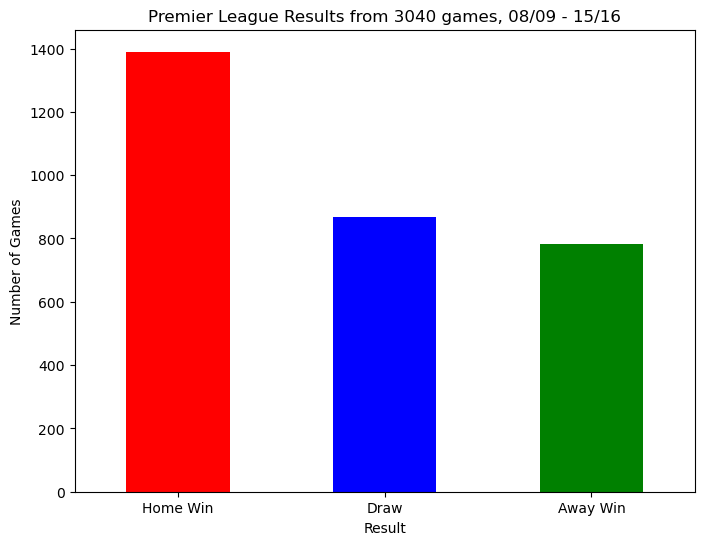

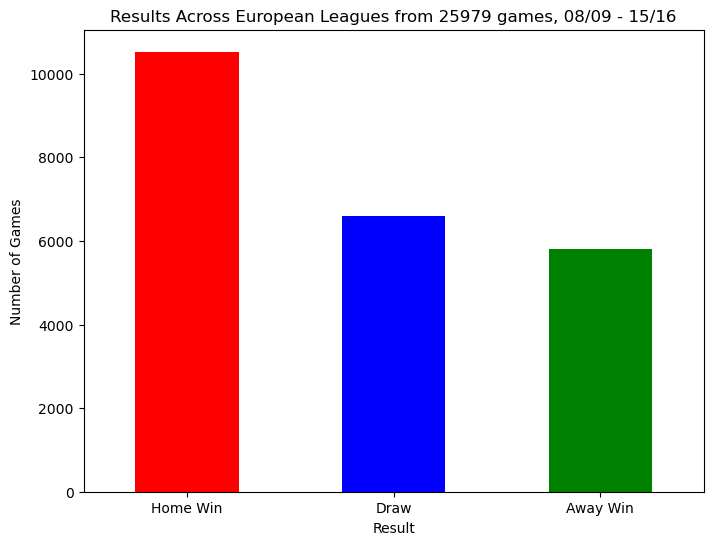

In [387]:
import matplotlib.pyplot as plt

# First figure for the 'prem' dataframe
plt.figure(figsize=(8, 6))
prem['Result'].value_counts().plot(kind='bar', color=['red', 'blue', 'green'])
plt.xticks(ticks=[0, 1, 2], labels=['Home Win', 'Draw', 'Away Win'], rotation=0)
plt.ylabel('Number of Games')
plt.title('Premier League Results from 3040 games, 08/09 - 15/16')
plt.show()

# Second figure for the 'all_matches' dataframe
plt.figure(figsize=(8, 6))
european_matches['Result'].value_counts().plot(kind='bar', color=['red', 'blue', 'green'])
plt.xticks(ticks=[0, 1, 2], labels=['Home Win', 'Draw', 'Away Win'], rotation=0)
# label y axis with total number of games - 25979
plt.ylabel('Number of Games')

# title - Results Across European Leagues from 25979 games, 08/09 - 15/16
plt.title('Results Across European Leagues from 25979 games, 08/09 - 15/16')
plt.show()


In [388]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Count the number of occurrences of each result for 'prem'
prem_result_counts = prem['Result'].value_counts()
prem_labels = ['Home Win', 'Draw', 'Away Win']
prem_values = [prem_result_counts[1], prem_result_counts[0], prem_result_counts[-1]]

# Count the number of occurrences of each result for 'all_matches'
european_matches_result_counts = european_matches['Result'].value_counts()
european_matches_labels = ['Home Win', 'Draw', 'Away Win']
european_matches_values = [european_matches_result_counts[1], european_matches_result_counts[0], european_matches_result_counts[-1]]

# Create a subplot figure with two pie charts
fig = make_subplots(
    rows=1, cols=2, 
    specs=[[{'type': 'domain'}, {'type': 'domain'}]],
    subplot_titles=[
    'Premier League Results, 3040 games, 08/09 - 15/16',
    'Europe (non-PL) Results, 22939 games, 08/09 - 15/16'
])

# Add the first pie chart (for 'prem')
fig.add_trace(
    go.Pie(
        labels=prem_labels,
        values=prem_values,
        hole=0.33,
        textinfo='label+percent',
        textposition='outside',
        showlegend=False
    ),
    row=1, col=1
)

# Add the second pie chart (for 'all_matches')
fig.add_trace(
    go.Pie(
        labels=european_matches_labels,
        values=european_matches_values,
        hole=0.33,
        textinfo='label+percent',
        textposition='outside',
        showlegend=False
    ),
    row=1, col=2
)

# Update the layout of the figure
fig.update_layout(title_text='Comparison of Match Results in England and rest of Europe', title_x=0.5)

# Show the figure
fig.show()


So we can see that Home Win is the most common result by far, almost twice as common as a draw and also far more likely than an Away Win.

These results in England and Europe are remarkably similar across tens of thousands of games in ten years. 

These are strong base rates. I will add these ad columns in the Prem dataframe for the model to see.

In [389]:
# add three columns - P(Home), P(Draw), P(Away) - the probability of each result
prem.insert(11, 'p(Home)', 0.457)
prem.insert(12, 'p(Draw)', 0.258)
prem.insert(13, 'p(Away)', 0.285)

Now we can compare the Margins - how are these distributed? What are specifically the most common results?

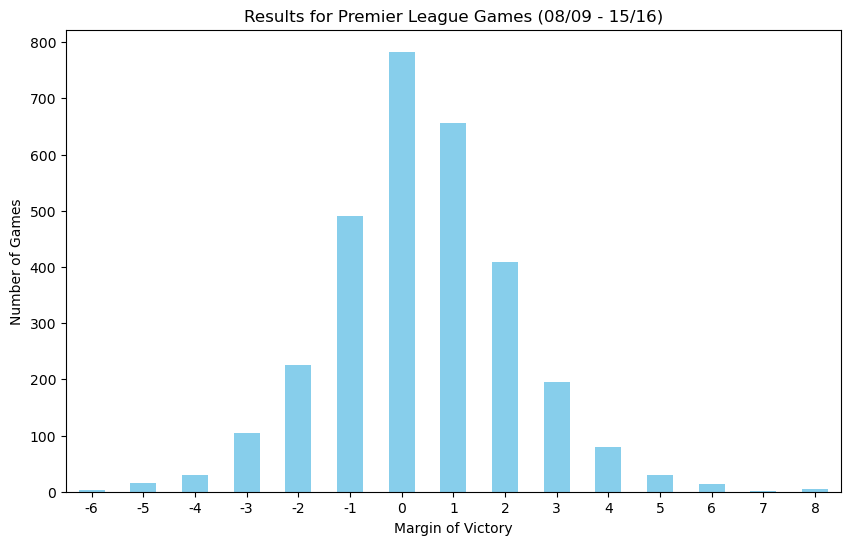

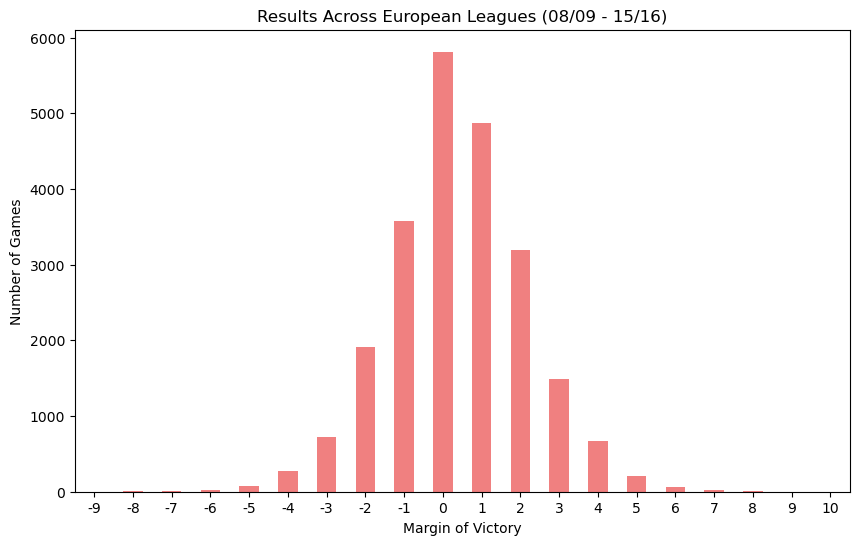

In [390]:
# First figure for the 'prem' dataframe
plt.figure(figsize=(10, 6))
prem['Margin'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xlabel('Margin of Victory')
plt.ylabel('Number of Games')
plt.title('Results for Premier League Games (08/09 - 15/16)')
plt.xticks(rotation=0)
plt.show()

# Second figure for the 'all_matches' dataframe
plt.figure(figsize=(10, 6))
european_matches['Margin'].value_counts().sort_index().plot(kind='bar', color='lightcoral')
plt.xlabel('Margin of Victory')
plt.ylabel('Number of Games')
plt.title('Results Across European Leagues (08/09 - 15/16)')
plt.xticks(rotation=0)
plt.show()


Again, the results are remarkably similar! Bear in mind that 0 here represents *all draws*, not a 0-0 draw which is how all games begin, so the tendency of a home win by 1 goal is still quite close in frequency.

We will want to tease out 0-0 draws from 1-1 draws if we want to predict the Margin later on, but that is a Stretch goal.

For now, the previous few cells show that a Home Win is nearly twice as frequent as any other result with remarkable consistency across different European football leagues.

**Base Rates**
- **Home Win: ~46%**
- **Away Win: ~28.5%**
- **Draw: ~ 25.5%**

#### Conclusions of this section
- Home wins are clearly the most common result, and because every team is home and away an equal number of times, home field advantage is a factor in this.
- Now we need to find more specific features / data to help the predictive model

## Frequency of individual results (e.g. 1-0, 2-2), Premier League and Europe
- A home win is the most common general outcome, but which specific scorelines do we see the most? 
- If the match starts at 0-0, how common are specific draw scorelines?

In [391]:
# count every unique combination of home goals vs away goals
prem_goals = prem.groupby(['Home GF', 'Away GF']).size().reset_index(name='Count')
european_matches_goals = european_matches.groupby(['Home GF', 'Away GF']).size().reset_index(name='Count')
prem_goals.head(10)

,Home GF,Away GF,Count
0,0,0,251
1,0,1,213
2,0,2,120
3,0,3,72
4,0,4,23
5,0,5,11
6,0,6,3
7,1,0,308
8,1,1,317
9,1,2,205


In [392]:
# create "Final Score" column to show the result of the match
prem_goals['Final Score'] = prem_goals['Home GF'].astype(str) + ' - ' + prem_goals['Away GF'].astype(str)
european_matches_goals['Final Score'] = european_matches_goals['Home GF'].astype(str) + ' - ' + european_matches_goals['Away GF'].astype(str)

In [393]:
prem_goals[['Home GF', 'Away GF', 'Final Score', 'Count']].sample(5)

,Home GF,Away GF,Final Score,Count
9,1,2,1 - 2,205
36,5,3,5 - 3,4
2,0,2,0 - 2,120
19,2,5,2 - 5,4
35,5,2,5 - 2,6


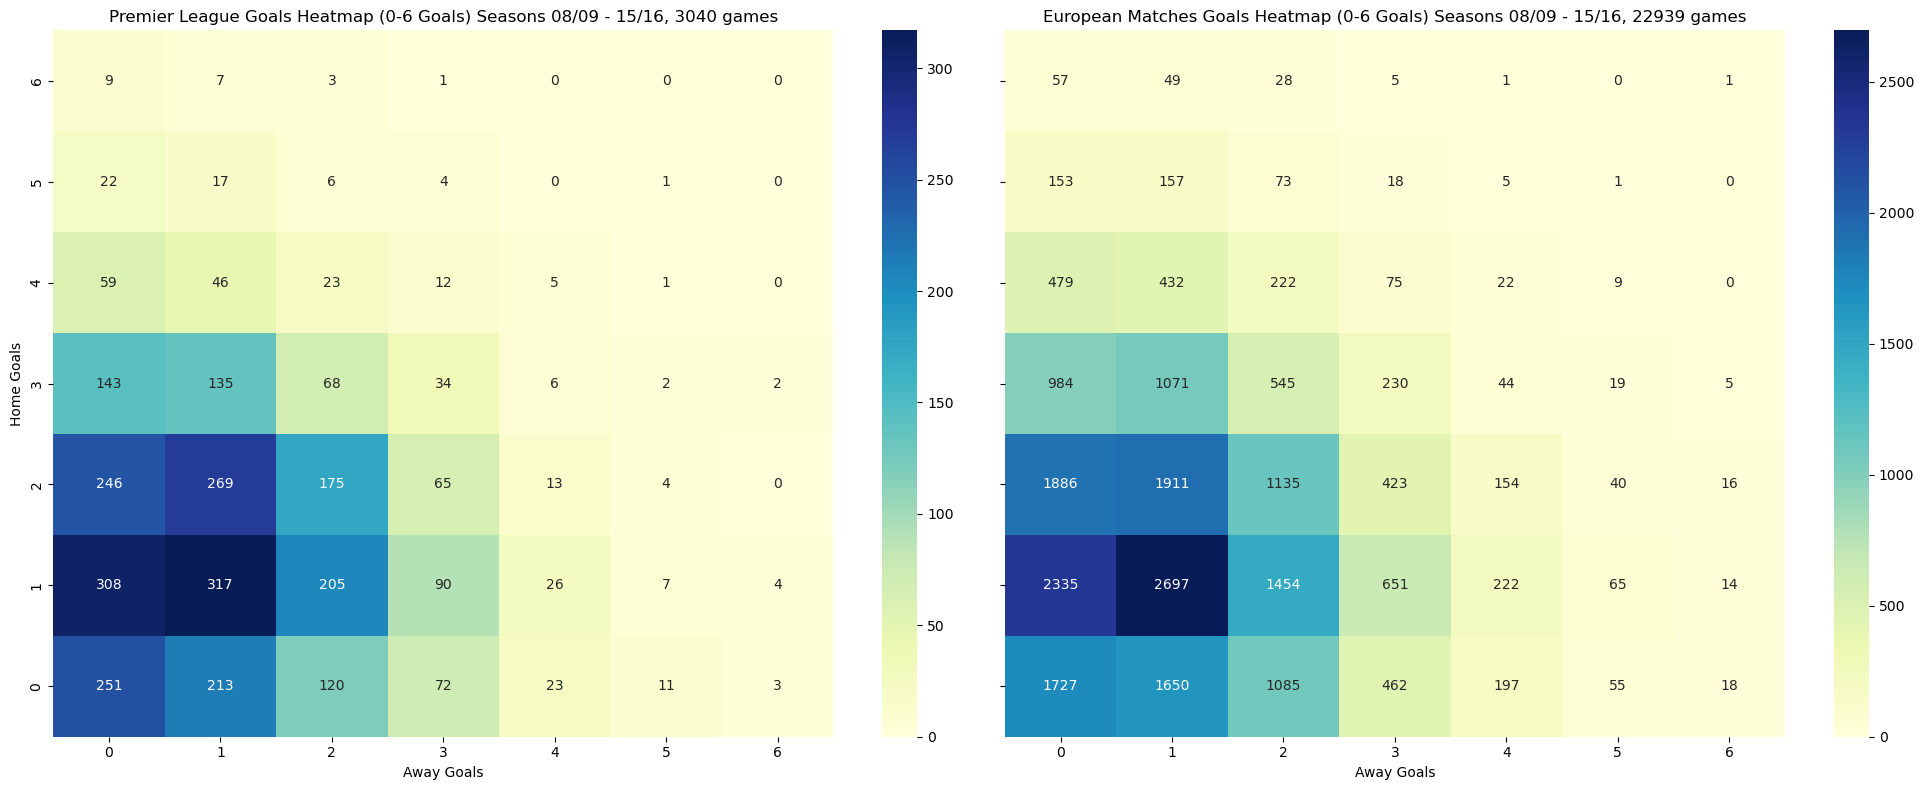

In [394]:
import numpy as np

# Define the range for Home GF and Away GF
goal_range = np.arange(0, 7)  # From 0 to 6 inclusive

# Filter the Premier League matrix to include only 0-6 goals
fixture_matrix = (
    prem_goals.pivot_table(
        index='Home GF',
        columns='Away GF',
        values='Count',
        aggfunc='sum',
        fill_value=0
    )
    .reindex(index=goal_range, columns=goal_range, fill_value=0)
)

# Filter the European Matches matrix to include only 0-6 goals
european_fixture_matrix = (
    european_matches_goals.pivot_table(
        index='Home GF',
        columns='Away GF',
        values='Count',
        aggfunc='sum',
        fill_value=0
    )
    .reindex(index=goal_range, columns=goal_range, fill_value=0)
)

# Reverse the order of rows and columns for both matrices to align (0, 0) in the bottom-left corner
fixture_matrix = fixture_matrix.iloc[::-1]
european_fixture_matrix = european_fixture_matrix.iloc[::-1]

# Create side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Heatmap for Premier League
sns.heatmap(
    fixture_matrix,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    cbar=True,
    ax=axes[0]
)
axes[0].set_title('Premier League Goals Heatmap (0-6 Goals) Seasons 08/09 - 15/16, 3040 games')
axes[0].set_xlabel('Away Goals')
axes[0].set_ylabel('Home Goals')

# Heatmap for European Matches
sns.heatmap(
    european_fixture_matrix,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    cbar=True,
    ax=axes[1]
)
axes[1].set_title('European Matches Goals Heatmap (0-6 Goals) Seasons 08/09 - 15/16, 22939 games')
axes[1].set_xlabel('Away Goals')
axes[1].set_ylabel('')  # No y-label on the second plot to avoid redundancy

# Adjust layout
plt.tight_layout()
plt.show()

We're comparing 3000 PL games to 23000 European games, so multiply the left by ~7.67 to get an equivalent on the right. We will do proportions in the donut chart below.

Things immediately jumping out here:


- 1-1 is the most likely individual score followed by 1-0 (very closely in both!) and from eyeballing this, the % of results are also strikingly close for both. 1-0 is a couple of percentage points behind 1-1 in both.
- 0-0 draws seem to be slightly more common (darker shade) in the PL than europe

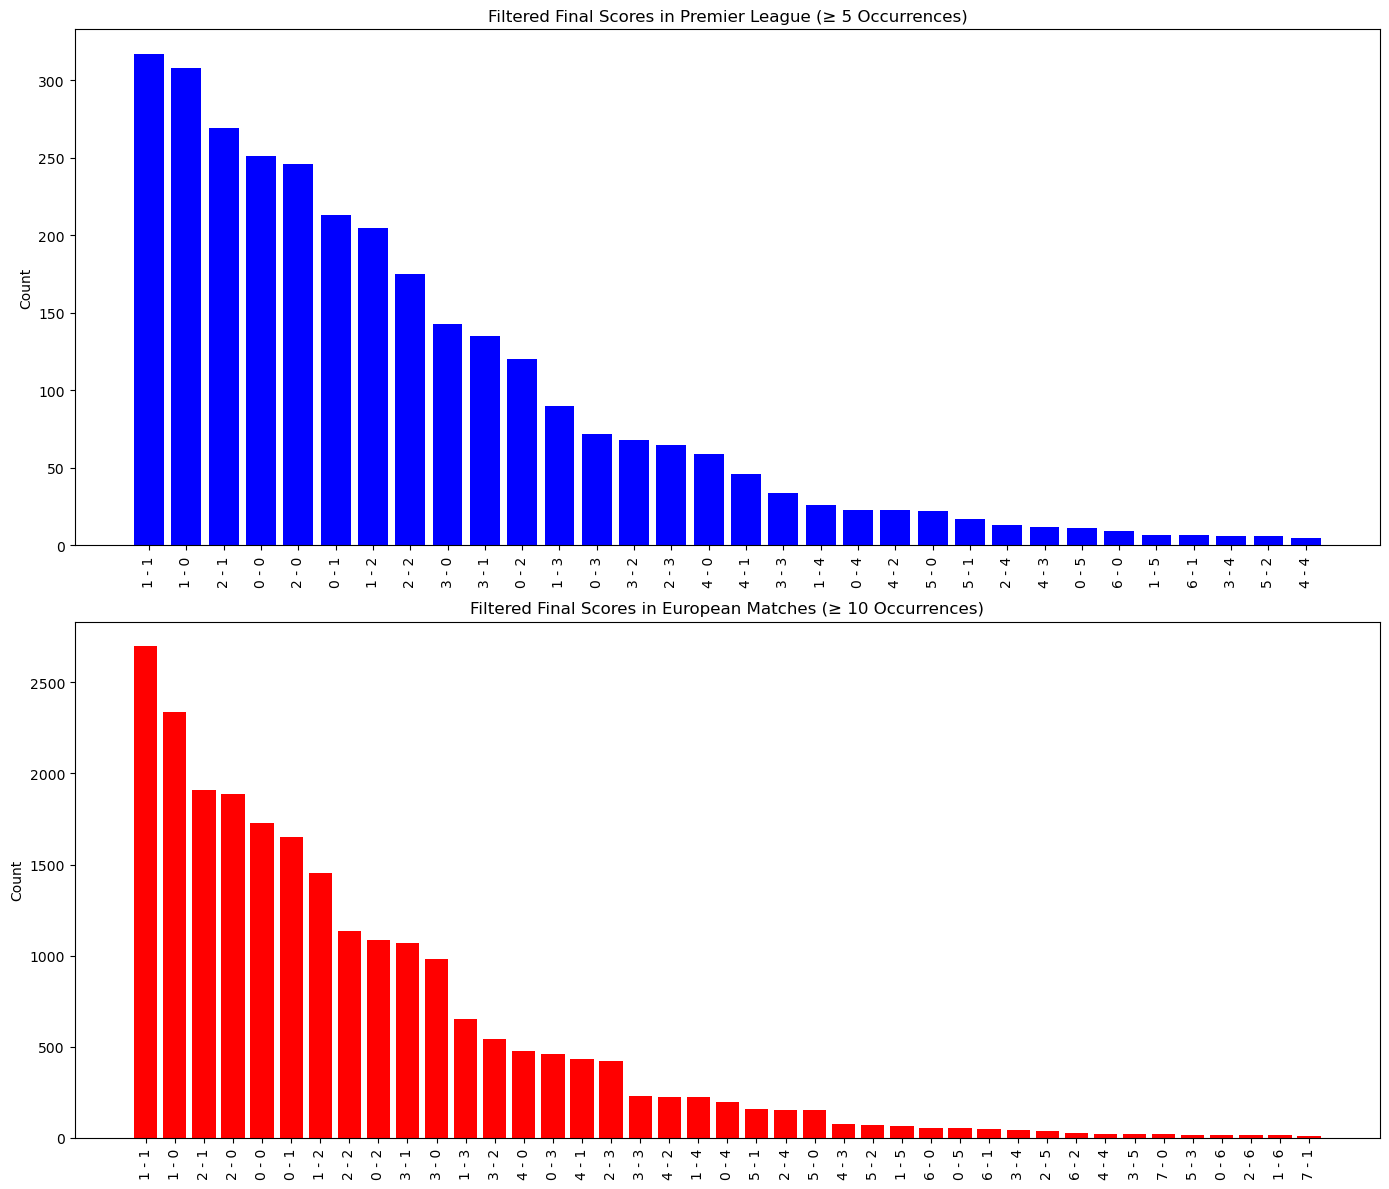

In [395]:
# Filter and sort the Premier League data - trim out the very rare scores
prem_filtered = prem_goals[prem_goals['Count'] >= 5].sort_values(by='Count', ascending=False)

# Filter and sort the European Matches data - trim out the very rare scores
european_filtered = european_matches_goals[european_matches_goals['Count'] >= 10].sort_values(by='Count', ascending=False)

# Create subplots for the filtered bar charts
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=False)

# Bar chart for Premier League
axes[0].bar(prem_filtered['Final Score'], prem_filtered['Count'], color='blue')
axes[0].set_title('Filtered Final Scores in Premier League (≥ 5 Occurrences)')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=90)

# Bar chart for European Matches
axes[1].bar(european_filtered['Final Score'], european_filtered['Count'], color='red')
axes[1].set_title('Filtered Final Scores in European Matches (≥ 10 Occurrences)')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=90)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


Some differences starting to emerge now - but 1-1, 1-0 and 2-1 still in order the most common results! 0-0 and 2-0 are reversed in Europe and the Prem, but then 0-1, 1-2 and 2-2 are the next most frequent scores in both datasets.

Let's get a % pie chart for the results

In [396]:
import plotly.express as px

# Calculate total matches for each dataset
prem_total = prem_goals['Count'].sum()
european_total = european_matches_goals['Count'].sum()

# Filter and group results for Premier League
prem_goals['Percentage'] = prem_goals['Count'] / prem_total * 100
prem_filtered = prem_goals[prem_goals['Percentage'] >= 2]
prem_other = pd.DataFrame({
    'Final Score': ['Other < 2%'],
    'Count': [prem_goals[prem_goals['Percentage'] < 2]['Count'].sum()]
})
prem_pie_data = pd.concat([prem_filtered[['Final Score', 'Count']], prem_other])

# Filter and group results for European Matches
european_matches_goals['Percentage'] = european_matches_goals['Count'] / european_total * 100
european_filtered = european_matches_goals[european_matches_goals['Percentage'] >= 2]
european_other = pd.DataFrame({
    'Final Score': ['Other < 2%'],
    'Count': [european_matches_goals[european_matches_goals['Percentage'] < 2]['Count'].sum()]
})
european_pie_data = pd.concat([european_filtered[['Final Score', 'Count']], european_other])

# Pie chart for Premier League Final Scores
prem_pie = px.pie(
    prem_pie_data,
    names='Final Score',
    values='Count',
    title='How often does the result occur in 3,000 Premier League matches? (08/09 - 15/16)',
    hole=0.3
)
prem_pie.update_traces(textinfo='label+percent', textposition='outside')
prem_pie.show()

# Pie chart for European Matches Final Scores
european_pie = px.pie(
    european_pie_data,
    names='Final Score',
    values='Count',
    title='How often does the result occur in 23,000 European league matches? (08/09 - 15/16)',
    hole=0.3
)
european_pie.update_traces(textinfo='label+percent', textposition='outside')
european_pie.show()

#### Observations
- The frequency of results across these leagues is staggering! Many individual results are only a single percentage point off each other at most
- Many results are in the same order with less than a quarter of a percentage point off in frequency is very interesting. These give a good base rate of longer term trends we can see.
    - Perhaps later we'll check out if these base rates are changing over time (is home field advantage decreasing over time, for instance?)
- 1-1 is the most common result and in the larger European sample, it is even more so than the PL. 1-0 is next, followed by 2-1 about 1.5 percent down which is close by with 2-0. 
- 0-0 draws are the fourth (PL) or fifth (Europe) most common result and a little bit more frequent in the Premier League.

#### Statistics of higher scoring teams in games

- Another interesting observation here is how rare instances of teams scoring three goals in a game are. The most common instance of one team scoring 3 goals is 4.3 - 4.7%, with 3-0 and 3-1 to the home team, followed by 3-2 (2.38%)

From anecdotal / personal observations of the best teams that are capable of scoring 3 goals in a game consistently, and the tendency to create cagey matches when they play each other, I'd like to explore the teams that frequently score 3+ goals in a game and their number of draws.

## EDA of Specific results and teams
- Can we learn patterns from teams scoring or conceding 3 goals in a game, which are rare events?
- Does playing at home or away affect the teams that happen to score 3+ in a match? Does it affect some teams more?
- Can 3+ goal exploration enhance our away win predictions down the line?
- Are draws more frequent in the busy christmas period or late season, when players are fatigued?

Coming back after my first run of the model, I need to solve the model's ability to predict draws and be better at predicting away wins.

When I saw that 3-0 or 3-1 only occurs around 4.5% of the time in the section above, and it is one of the less common results, I thought there would be potential to pick out the 'top teams' that would be more favourable for away wins, which are the ones that more frequently score 3 goals in a single match. These are the teams with the ability to easily win their home games and an attritional low-quality match, which would be a draw for most teams, would more likely be a win for them.

In [397]:
# how many matches has every unique team played in the premier league
home_team_counts = prem['home_team'].value_counts()

away_team_counts = prem['away_team'].value_counts()
appearances = home_team_counts.add(away_team_counts, fill_value=0).sort_values(ascending=False)
appearances.sample(5)

Newcastle United    266
Blackpool            38
Arsenal             304
Portsmouth           76
Middlesbrough        38
Name: count, dtype: int64

In [398]:
# find the value counts for each team for matches where the home team has scored 3 or more goals
home_3_gf = prem[prem['Home GF'] >= 3]['home_team'].value_counts()
away_3_gf = prem[prem['Away GF'] >= 3]['away_team'].value_counts()

print(home_3_gf.sample(5))
print("\n")
print(away_3_gf.sample(5))

home_team
Stoke City              20
West Bromwich Albion    19
Southampton             18
Cardiff City             3
Watford                  2
Name: count, dtype: int64


away_team
Birmingham City      1
Sunderland          15
Stoke City           5
Watford              1
Bolton Wanderers    11
Name: count, dtype: int64


I also want to see the porous teams - who is vulnerable at home and away?

In [399]:
home_3_ga = prem[prem['Away GF'] >= 3]['home_team'].value_counts()
away_3_ga = prem[prem['Home GF'] >= 3]['away_team'].value_counts()
print(home_3_ga.sample(5))
print("\n")
print(away_3_ga.sample(5))

home_team
Crystal Palace      9
Sunderland         19
Aston Villa        17
Manchester City    13
Leicester City      4
Name: count, dtype: int64


away_team
West Ham United    30
Reading             7
Blackpool           8
Birmingham City     9
Fulham             22
Name: count, dtype: int64


I ran the sample function to save scrolling but by removing .sample, you can see the full results.

From very high level you can see that teams just don't score 3+ goals away from home as much as at home. No surprises there. It looks like about twice as likely that a team will score 3+ at home than away, but some teams like Arsenal seem to be quite consistent in their tendency to produce these games (only a 20% dropoff away from home).

Let's check.

In [400]:
# Make a df with team name, appearances, home 3+ goals, away 3+ goals
three_goals = pd.DataFrame({
    'Appearances': appearances,
    'Home 3+ GF': home_3_gf,
    'Away 3+ GF': away_3_gf,
    'Home 3+ GA': home_3_ga,
    'Away 3+ GA': away_3_ga
})

In [401]:
# We'll create columns for the probability of scoring 3+ goals at home and away, dividing appearances by half
three_goals['p(Home 3+ GF)'] = round(three_goals['Home 3+ GF'] / (three_goals['Appearances'] / 2), 3)
three_goals['p(Away 3+ GF)'] = round(three_goals['Away 3+ GA'] / (three_goals['Appearances'] / 2), 3)
three_goals['p(Home 3+ GA)'] = round(three_goals['Home 3+ GA'] / (three_goals['Appearances'] / 2), 3)
three_goals['p(Away 3+ GA)'] = round(three_goals['Away 3+ GA'] / (three_goals['Appearances'] / 2), 3)

# fill na values with 0
three_goals = three_goals.fillna(0)

# make Home 3+ goals and Away 3+ goals integers
three_goals['Home 3+ GF'] = three_goals['Home 3+ GF'].astype(int)
three_goals['Away 3+ GF'] = three_goals['Away 3+ GF'].astype(int)
three_goals['Home 3+ GA'] = three_goals['Home 3+ GA'].astype(int)
three_goals['Away 3+ GA'] = three_goals['Away 3+ GA'].astype(int)

# Rename the Appearances column to seasons, and divide the values by 38 to get the number of seasons the team appeared in this period
three_goals = three_goals.rename(columns={'Appearances': 'Seasons'})
three_goals['Seasons'] = (three_goals['Seasons'] / 38)

In [402]:
# seasons column as int
three_goals['Seasons'] = three_goals['Seasons'].astype(int)

In [403]:
# just the teams with more than one season in the premier league
three_goals.sort_values(by='Seasons', ascending=False)

,Seasons,Home 3+ GF,Away 3+ GF,Home 3+ GA,Away 3+ GA,p(Home 3+ GF),p(Away 3+ GF),p(Home 3+ GA),p(Away 3+ GA)
Arsenal,8,50,39,10,20,0.329,0.132,0.066,0.132
Chelsea,8,46,38,13,15,0.303,0.099,0.086,0.099
Tottenham Hotspur,8,35,23,11,27,0.230,0.178,0.072,0.178
Sunderland,8,20,15,19,35,0.132,0.230,0.125,0.230
Stoke City,8,20,5,11,35,0.132,0.230,0.072,0.230
Aston Villa,8,20,12,17,39,0.132,0.257,0.112,0.257
Manchester City,8,69,34,13,15,0.454,0.099,0.086,0.099
Liverpool,8,48,38,7,29,0.316,0.191,0.046,0.191
Everton,8,34,20,17,19,0.224,0.125,0.112,0.125
Manchester United,8,60,35,10,16,0.395,0.105,0.066,0.105


I want to determine a few things here as I add these probability of 3 goals columns:
- The teams with less appearances (because they got relegated from the PL) still have lower probabilities of scoring 3+ goals
- the differential between home and away probability of 3 goals

I will do a correlation heatmap of the probabilities of 3+ goals home and away, with the appearances

In [404]:
# differential between home and away 3+ goals
three_goals['Difference GF'] = three_goals['p(Home 3+ GF)'] - three_goals['p(Away 3+ GF)']
three_goals['Difference GA'] = three_goals['p(Home 3+ GA)'] - three_goals['p(Away 3+ GA)']

In [405]:
three_goals.sample(10)

,Seasons,Home 3+ GF,Away 3+ GF,Home 3+ GA,Away 3+ GA,p(Home 3+ GF),p(Away 3+ GF),p(Home 3+ GA),p(Away 3+ GA),Difference GF,Difference GA
Southampton,4,18,8,9,11,0.237,0.145,0.118,0.145,0.092,-0.027
West Ham United,7,24,13,27,30,0.180,0.226,0.203,0.226,-0.046,-0.023
Blackpool,1,2,2,7,8,0.105,0.421,0.368,0.421,-0.316,-0.053
Portsmouth,2,5,1,8,7,0.132,0.184,0.211,0.184,-0.052,0.027
Burnley,2,2,4,7,14,0.053,0.368,0.184,0.368,-0.315,-0.184
Norwich City,4,10,5,11,24,0.132,0.316,0.145,0.316,-0.184,-0.171
Bournemouth,1,3,2,6,5,0.158,0.263,0.316,0.263,-0.105,0.053
Manchester United,8,60,35,10,16,0.395,0.105,0.066,0.105,0.290,-0.039
Leicester City,2,8,7,4,3,0.211,0.079,0.105,0.079,0.132,0.026
Watford,1,2,1,1,3,0.105,0.158,0.053,0.158,-0.053,-0.105


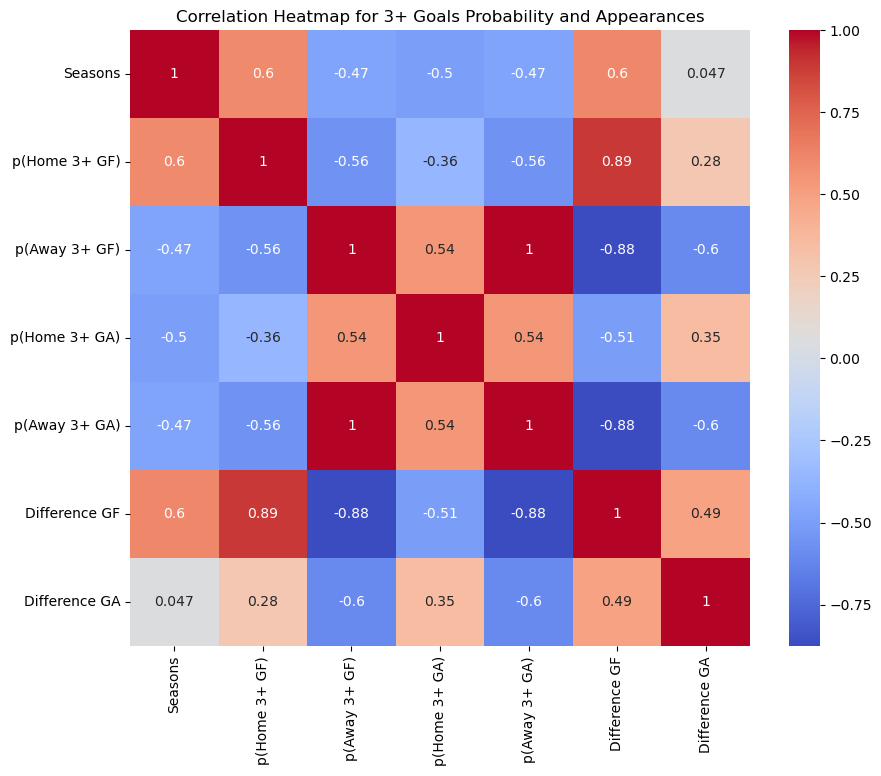

In [406]:
# correlation heatmap of the three_goals df with only the Appearance, p(Home 3+ Goals), p(Away 3+ Goals), and Difference columns
plt.figure(figsize=(10, 8))
sns.heatmap(three_goals[['Seasons', 'p(Home 3+ GF)', 'p(Away 3+ GF)', 'p(Home 3+ GA)', 'p(Away 3+ GA)', 'Difference GF', 'Difference GA']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for 3+ Goals Probability and Appearances')
plt.show()

There are a lot of strong correlations here:
- The strongest of which is p(home 3+) and p(away 3+) at 0.82. High scoring teams at home tend to also score a lot away, just on less occasions in absolute terms.
- Likewise, 0.54 corr between p(Home 3+ GA) and p(Away 3+ GA). Teams that concede a lot at home tend to also concede a lot away.
- Correlations with seasons:
    - As you might expect, fairly strong correlations between Seasons spent in the Prem and the tendency of scoring 3+ goals at home (0.6) and away (0.51)
    - In the same vein, fairly strong negative correlations between Seasons spent in the Prem and the tendency to concede 3+ goals at home (0.5) and away (0.47)
- Scoring 3 at home in a game is less negatively correlated to conceding 3 at home than conceding three away.    
    - This tells me the teams more regularly scoring 3 at home could also concede 3 at home more regularly than conceding three away.
- Ignoring the 0.6 Difference GA / p(Away 3+ GA as it's collinear)

Remember, unlike some of the other results based exploration, these are not symmetrical metrics. The individual teams outputs / performances in home and away games are recorded separately and conceptually different.

### Who built a fortress?
- Teams with the largest home / away 3+ goals differential
- Teams having noticeably better performance at home or away - good home form
- If you score 3 goals in a game, you will almost always win
- If you concede 3 goals in a game, you will almost always lose

In [407]:
# order the teams by the difference column
three_goals_gs = three_goals[['Seasons', 'Home 3+ GF', 'Away 3+ GF', 'p(Home 3+ GF)', 'p(Away 3+ GF)', 'Difference GF']].sort_values(by='Difference GF', ascending=False)
three_goals_gs

,Seasons,Home 3+ GF,Away 3+ GF,p(Home 3+ GF),p(Away 3+ GF),Difference GF
Manchester City,8,69,34,0.454,0.099,0.355
Manchester United,8,60,35,0.395,0.105,0.290
Chelsea,8,46,38,0.303,0.099,0.204
Arsenal,8,50,39,0.329,0.132,0.197
Leicester City,2,8,7,0.211,0.079,0.132
Liverpool,8,48,38,0.316,0.191,0.125
Everton,8,34,20,0.224,0.125,0.099
Southampton,4,18,8,0.237,0.145,0.092
Tottenham Hotspur,8,35,23,0.230,0.178,0.052
Swansea City,5,19,7,0.200,0.189,0.011


In [408]:
# teams most likely to score 3+ goals at home
three_goals_gs.sort_values(by='p(Home 3+ GF)', ascending=False).head(10)

,Seasons,Home 3+ GF,Away 3+ GF,p(Home 3+ GF),p(Away 3+ GF),Difference GF
Manchester City,8,69,34,0.454,0.099,0.355
Manchester United,8,60,35,0.395,0.105,0.290
Arsenal,8,50,39,0.329,0.132,0.197
Liverpool,8,48,38,0.316,0.191,0.125
Chelsea,8,46,38,0.303,0.099,0.204
Southampton,4,18,8,0.237,0.145,0.092
Tottenham Hotspur,8,35,23,0.230,0.178,0.052
Everton,8,34,20,0.224,0.125,0.099
Leicester City,2,8,7,0.211,0.079,0.132
Swansea City,5,19,7,0.200,0.189,0.011


In [409]:
# teams most likely to score three away from home
three_goals_gs.sort_values(by='p(Away 3+ GF)', ascending=False).head(10)

,Seasons,Home 3+ GF,Away 3+ GF,p(Home 3+ GF),p(Away 3+ GF),Difference GF
Blackpool,1,2,2,0.105,0.421,-0.316
Blackburn Rovers,4,12,7,0.158,0.382,-0.224
Burnley,2,2,4,0.053,0.368,-0.315
Cardiff City,1,3,1,0.158,0.368,-0.210
Reading,1,3,1,0.158,0.368,-0.210
Queens Park Rangers,3,6,4,0.105,0.351,-0.246
Norwich City,4,10,5,0.132,0.316,-0.184
Newcastle United,7,23,10,0.173,0.286,-0.113
Wolverhampton Wanderers,3,5,4,0.088,0.281,-0.193
Middlesbrough,1,1,0,0.053,0.263,-0.210


Some insights:
- **Generally, all of the Big Six dominate the home and away 3+ goals leaderboards above** but some of them are noticeably better at home: 
    - The Manchester clubs are monstrous at home! They score 3+ goals at home significantly more than their nearest chasers Liverpool, Arsenal and Chelsea.
    - They are the highest differentials, City by a huge margin and United considerably ahead of third place, Southampton.
    - By Contrast, most of the other Big Six (Arsenal, Liverpool, Chelsea and Tottenham) slightly exceed the Manchester clubs' Away 3+ goals tallies, but not enough to fully compensate for the significantly higher prolific scoring at home in Manchester.

- There seems to be a bit of a ceiling of scoring 3+ goals away from home at 25% of the time.
- There are a few exceptions but generally the biggest differentials between home & away differentials were the mainstays in the premier league during this time (being there for all 8 seasons). 

However, with some specific domain knowledge, we should look at **trajectory** of the clubs over time too.
- With the departure of legendary manager Sir Alex Ferguson in May 2013, Manchester United entered a period of relative mediocrity and I would anticipate these prolific goalscoring tendencies to begin declining
- Manchester City were bought out by an Emirati billionaire in 2008 and since then have had significant investment putting them into an upward trajectory.

### Who gets humbled?

In [410]:
# order the teams by the difference column
three_goals_ga = three_goals[['Seasons', 'Home 3+ GA', 'Away 3+ GA', 'p(Home 3+ GA)', 'p(Away 3+ GA)', 'Difference GA']].sort_values(by='p(Away 3+ GA)', ascending=False)
three_goals_ga

,Seasons,Home 3+ GA,Away 3+ GA,p(Home 3+ GA),p(Away 3+ GA),Difference GA
Blackpool,1,7,8,0.368,0.421,-0.053
Blackburn Rovers,4,6,29,0.079,0.382,-0.303
Burnley,2,7,14,0.184,0.368,-0.184
Cardiff City,1,5,7,0.263,0.368,-0.105
Reading,1,5,7,0.263,0.368,-0.105
Queens Park Rangers,3,7,20,0.123,0.351,-0.228
Norwich City,4,11,24,0.145,0.316,-0.171
Newcastle United,7,23,38,0.173,0.286,-0.113
Wolverhampton Wanderers,3,14,16,0.246,0.281,-0.035
Bournemouth,1,6,5,0.316,0.263,0.053


As you might expect the teams spending the least seasons in the PL have the higher probabilities of shipping 3+ goals. Is it more pronounced shipping home or away goals? 

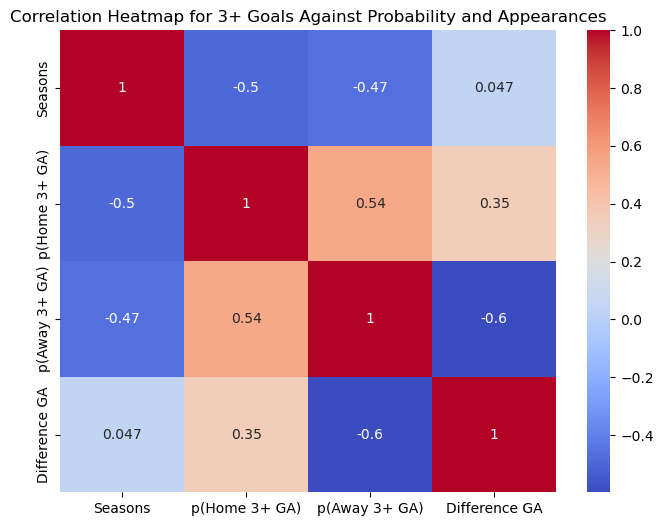

In [411]:
# correlation heatmap of three_goals_ga with seasons, p(Home 3+ Goals Against), p(Away 3+ Goals Against), and Difference GA
plt.figure(figsize=(8, 6))
sns.heatmap(three_goals_ga[['Seasons', 'p(Home 3+ GA)', 'p(Away 3+ GA)', 'Difference GA']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for 3+ Goals Against Probability and Appearances')
plt.show()

'Staying in the Premier League' is almost equally negatively correlated with the tendency to ship 3 at home or away, very slightly favouring this at home which makes sense - many small teams looking to survive build their survival on at least being hard to beat at home where they target the most wins.

### LEICESTER CITY:
- It's worth mentioning that one anomaly here is Leicester City. Leicester City won the title at the end of 2015-16 season, the last in the dataset. In the 2014-15 season, they narrowly avoided relegation. 
- They therefore have two seasons in this dataframe which are statistical Jekyll-and-Hyde, and thus we may want to have a feature that gives us points per game for the particular season, which would capture season-specific dynamics a particular team is going through.

They are a good exercise in seeing the same team having two very different seasons:

In [412]:
# find all games where Leicester City are the home team or the away team
leicester = prem[(prem['home_team'] == 'Leicester City') | (prem['away_team'] == 'Leicester City')]

# find the number of times Leicester City have scored 3+ goals in the 14/15 Season - backslash is for line continuation
leicester_3_gs_14_15 = leicester[(leicester['season'] == '14/15') & (leicester['Home GF'] >= 3) & (leicester['home_team'] == 'Leicester City')].shape[0] + \
                leicester[(leicester['season'] == '14/15') & (leicester['Away GF'] >= 3) & (leicester['away_team'] == 'Leicester City')].shape[0]

# number of times Leicester City conceded 3+ goals in the 14/15 season
leicester_3_ga_14_15 = leicester[(leicester['season'] == '14/15') & (leicester['Home GF'] >= 3) & (leicester['away_team'] == 'Leicester City')].shape[0] + \
                leicester[(leicester['season'] == '14/15') & (leicester['Away GF'] >= 3) & (leicester['home_team'] == 'Leicester City')].shape[0]

print(f'Leicester City scored 3+ goals in {leicester_3_gs_14_15} games and conceded 3+ goals in {leicester_3_ga_14_15} games in the 14/15 season.')

# find the number of times Leicester City have scored 3+ goals in the 15/16 Season
leicester_3_gs_15_16 = leicester[(leicester['season'] == '15/16') & (leicester['Home GF'] >= 3) & (leicester['home_team'] == 'Leicester City')].shape[0] + \
                leicester[(leicester['season'] == '15/16') & (leicester['Away GF'] >= 3) & (leicester['away_team'] == 'Leicester City')].shape[0]

# find the number of times Leicester City conceded 3+ goals in the 15/16 season
leicester_3_ga_15_16 = leicester[(leicester['season'] == '15/16') & (leicester['Home GF'] >= 3) & (leicester['away_team'] == 'Leicester City')].shape[0] + \
                leicester[(leicester['season'] == '15/16') & (leicester['Away GF'] >= 3) & (leicester['home_team'] == 'Leicester City')].shape[0]

print(f'Leicester City scored 3+ goals in {leicester_3_gs_15_16} games and conceded 3+ goals in {leicester_3_ga_15_16} games in the 15/16 season.')

Leicester City scored 3+ goals in 5 games and conceded 3+ goals in 6 games in the 14/15 season.
Leicester City scored 3+ goals in 10 games and conceded 3+ goals in 1 games in the 15/16 season.


Above: 14/15 was a survival season and 15/16 was a title-winning season

### Conclusions of this section:
- Scoring three at home or away will almost always get you the win, and most teams are better at home than away
- On the home form, Seasons correlates more strongly with home scoring and home conceding than it does with away - it's home form that keeps you winning and surviving in the Prem.
- Some teams are much more consistent in their tendency to score 3+ goals away or at home
- For those with the largest differential in home / away 3+ goals probability, its usually teams with outstanding home form

**What can we bring into the predictive model here?**
- % Home losses 
    - Captures how hard are this team to beat at home
    - Is the away team playing a good team or a good *home team*?
    - This rating could be predictive of good teams getting an away win or drawing.

## Points Per Game (ppg) 
- Overall PpG
- Find points per game in season so far, capturing current season's form?
- Points per game for last season, which will capture previous form and moving trajectory
- See how gradually teams change - e.g. Man City vs Man Utd

In [413]:
# variable created above: appaearances
appearances.sample(5)

Stoke City                 304
Wolverhampton Wanderers    114
Cardiff City                38
Fulham                     228
Birmingham City             76
Name: count, dtype: int64

In [414]:
# number of wins, draws, and losses for each team
home_wins = prem[prem['Result'] == 1]['home_team'].value_counts()
away_wins = prem[prem['Result'] == -1]['away_team'].value_counts()
home_draws = prem[prem['Result'] == 0]['home_team'].value_counts()
away_draws = prem[prem['Result'] == 0]['away_team'].value_counts()
home_losses = prem[prem['Result'] == -1]['home_team'].value_counts()
away_losses = prem[prem['Result'] == 1]['away_team'].value_counts()

points = (home_wins * 3).add(away_wins * 3, fill_value=0).add(home_draws, fill_value=0).add(away_draws, fill_value=0)

# now create a dataframe with all the above data and appearances
pl_points = pd.DataFrame({
    'Appearances': appearances,
    'Home Wins': home_wins,
    'Away Wins': away_wins,
    'Home Draws': home_draws,
    'Away Draws': away_draws,
    'Home Losses': home_losses,
    'Away Losses': away_losses,
    'Points': points
})

In [415]:
pl_points.head()
# points per game column
pl_points['Points per Game'] = round(pl_points['Points'] / (pl_points['Appearances']), 2)
pl_points

,Appearances,Home Wins,Away Wins,Home Draws,Away Draws,Home Losses,Away Losses,Points,Points per Game
Arsenal,304,97,73,34,39,21,40,583,1.92
Aston Villa,304,45,41,50,38,57,73,346,1.14
Birmingham City,76,14,7,17,9,7,22,89,1.17
Blackburn Rovers,152,29,13,21,18,26,45,165,1.09
Blackpool,38,5,5,5,4,9,10,39,1.03
Bolton Wanderers,152,27,16,20,13,29,47,162,1.07
Bournemouth,38,5,6,5,4,9,9,42,1.11
Burnley,76,11,4,12,6,15,28,63,0.83
Cardiff City,38,5,2,5,4,9,13,30,0.79
Chelsea,304,101,75,34,36,17,41,598,1.97


Now we have an another easy way to see performance other than net_goals per game (which was influential in the first run, but this may be even more so)


In [416]:
prem.sample(5)

,date,Venue,Gameweek / 38,home_team,Home Manager,Home GF,Away GF,away_team,Away Manager,Result,...,foulcommit,card,cross,corner,possession,Venue Code,Home Manager Code,Away Manager Code,Day,Day Code
2987,2015-08-29,bet365 Stadium,4,Stoke City,Mark Hughes,0,1,West Bromwich Albion,Tony Pulis,-1,...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>75</comment><stats...,33,45,88,Saturday,2
976,2011-03-05,Craven Cottage,29,Fulham,Mark Hughes,3,2,Blackburn Rovers,Steve Kean,1,...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>53</comment><event...,4,45,81,Saturday,2
2340,2014-12-07,Villa Park,15,Aston Villa,Paul Lambert,2,1,Leicester City,Nigel Pearson,1,...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>71</comment><event...,30,60,54,Sunday,3
271,2009-04-26,Emirates Stadium,34,Arsenal,Arsène Wenger,2,0,Middlesbrough,Gareth Southgate,1,...,<foulcommit><value><stats><foulscommitted>1</f...,<card />,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>61</comment><event...,6,7,21,Sunday,3
1193,2011-12-05,Craven Cottage,14,Fulham,Martin Jol,1,0,Liverpool,Kenny Dalglish,1,...,<foulcommit><value><stats><foulscommitted>1</f...,<card><value><comment>y</comment><stats><ycard...,<cross><value><stats><corners>1</corners></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>35</comment><event...,4,46,37,Monday,1


## Draws - when, who, why
- draws are the rarest of the three outcomes (Home, Draw, Away win) so our model will need something intelligent to predict them, otherwise it will guess at pure chance or always go for an away or home win
- Are draws more common in certain parts of the season? By top teams or weak teams?
- What else correlates with the tendency to draw games?
- **NEXT DEVELOPMENT**: Visualising which types of teams tend to draw may require a more fluid points per game measure, or medium term form, to reveal a trend

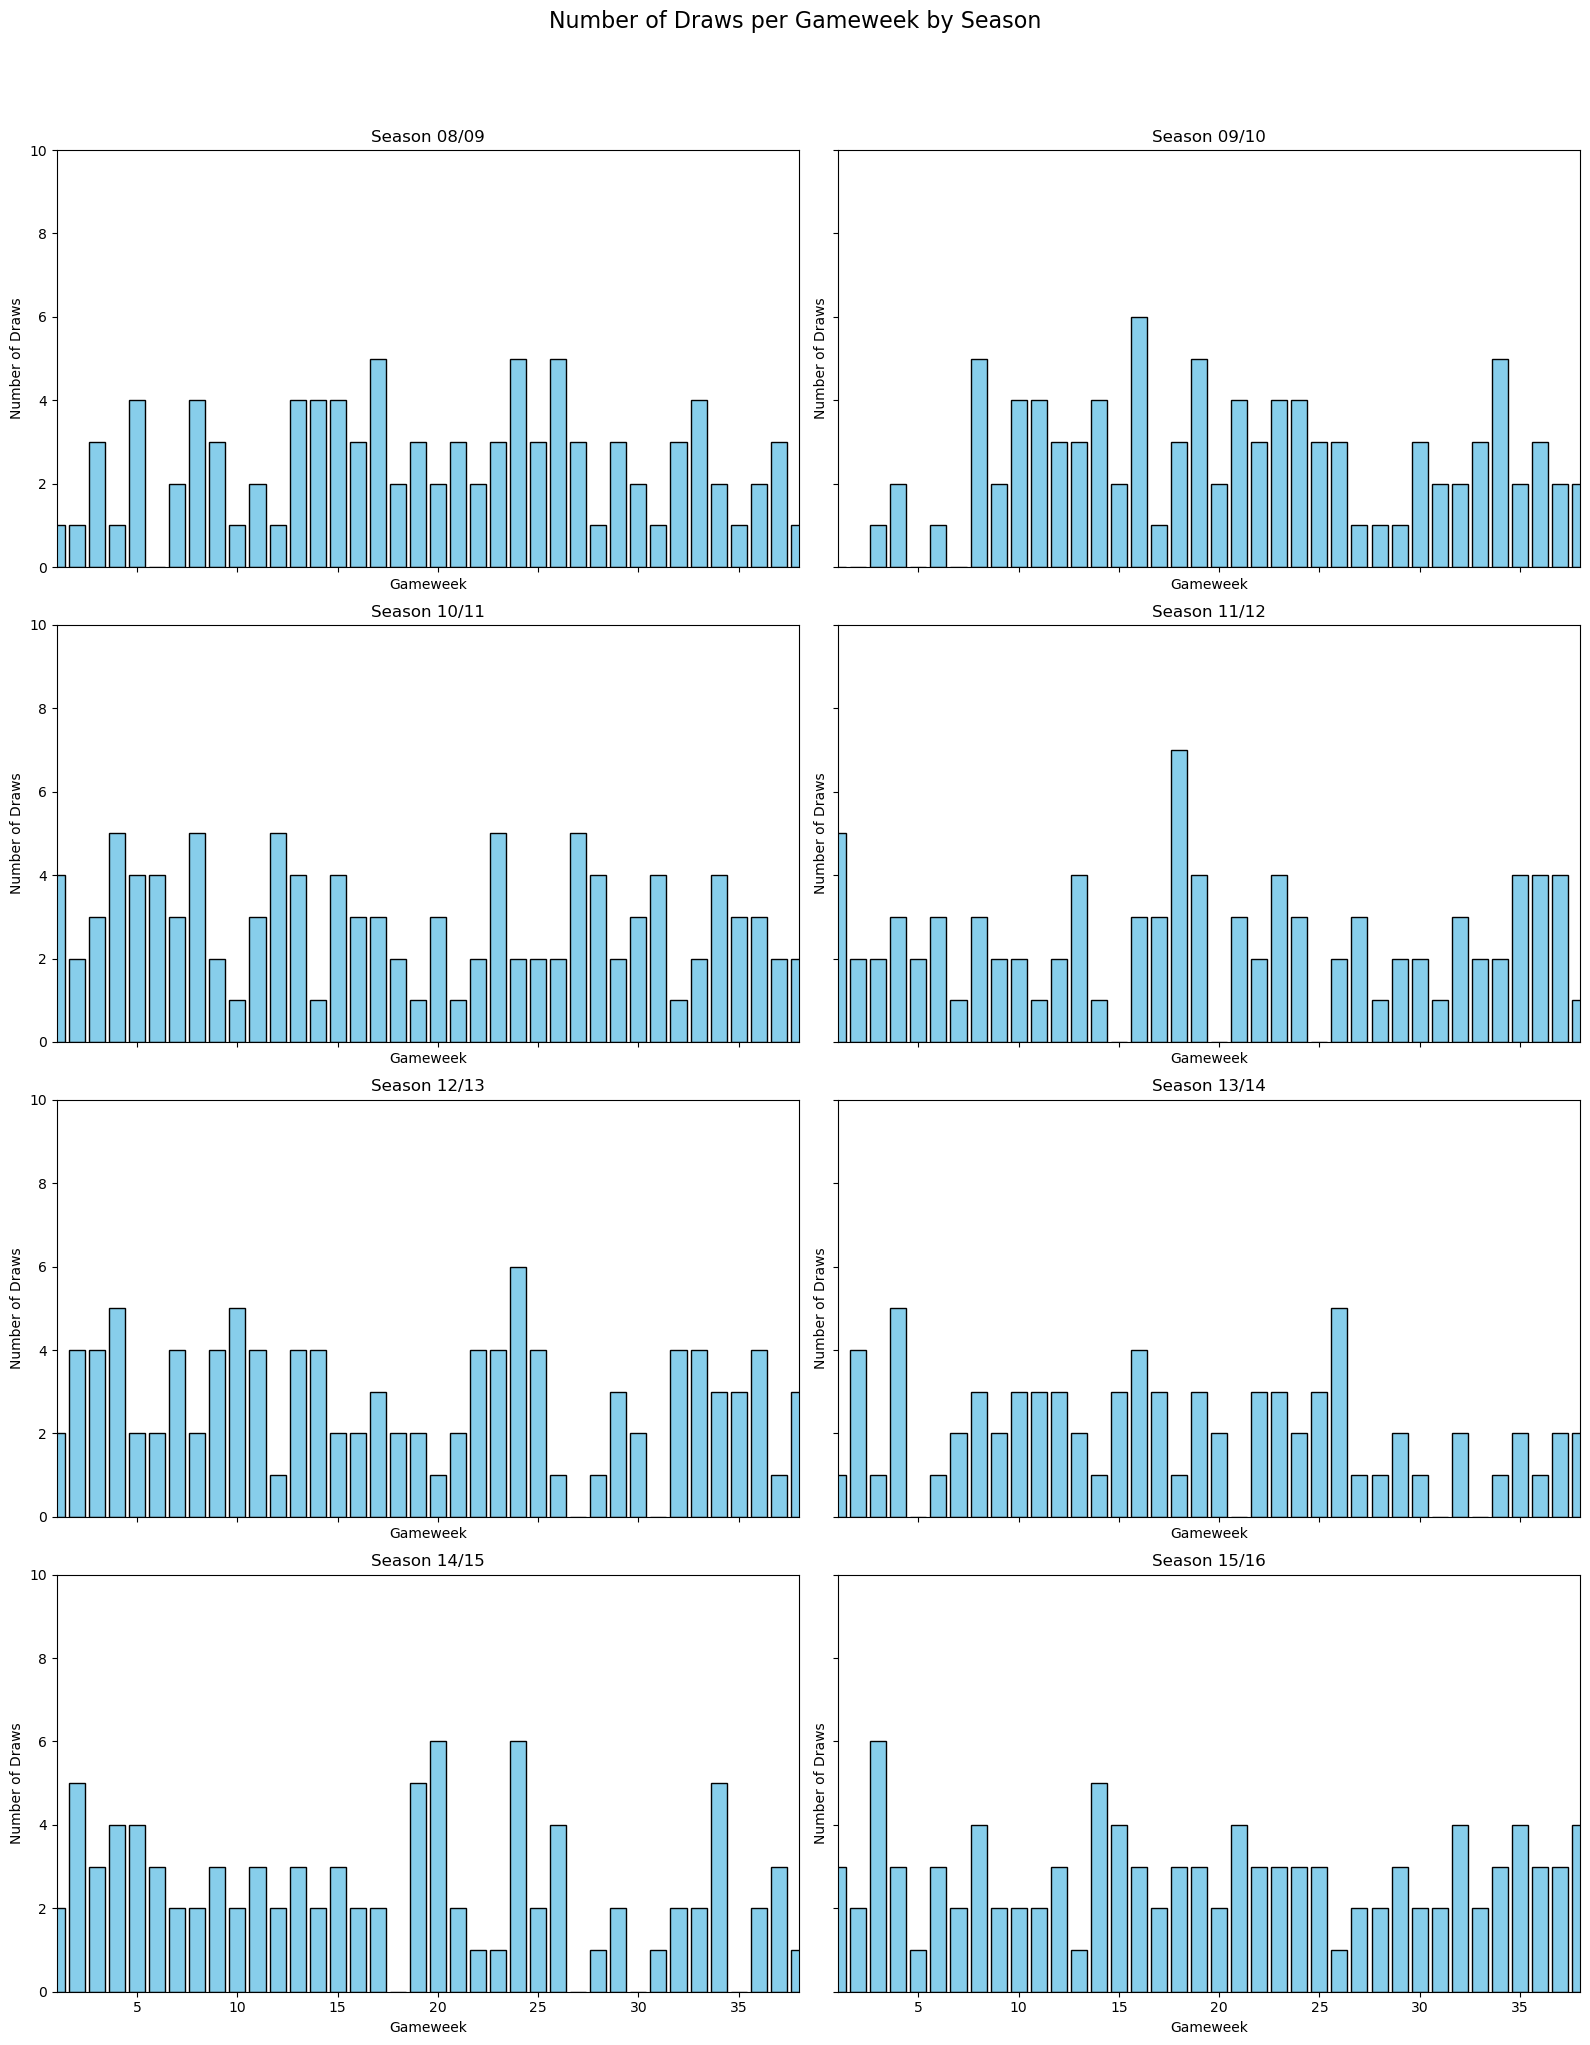

In [417]:
def plot_draws_per_gameweek(df):
    """
    Function to plot the frequency of draws per gameweek for each season.

    Parameters:
        data (pd.DataFrame): The input dataframe containing 'season', 'Gameweek / 38', and 'Result'.
    """
    import matplotlib.pyplot as plt

    # Ensure proper data types
    df['season'] = df['season'].astype(str)
    df['Gameweek / 38'] = df['Gameweek / 38'].astype(int)
    df['Result'] = df['Result'].astype(int)

    # Extract unique seasons
    seasons = df['season'].unique()

    # Initialize a figure with 8 subplots
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 20), sharex=True, sharey=True)
    axes = axes.flatten()

    # Iterate through each season
    for idx, season in enumerate(seasons):
        ax = axes[idx]

        # Filter data for the current season
        season_data = df[df['season'] == season]

        # Count the number of draws (Result == 0) for each gameweek
        draws_per_gameweek = (
            season_data[season_data['Result'] == 0]
            .groupby('Gameweek / 38')
            .size()
            .reindex(range(1, 39), fill_value=0)  # Ensure all gameweeks (1 to 38) are present
        )

        # Plot the results
        ax.bar(draws_per_gameweek.index, draws_per_gameweek.values, color='skyblue', edgecolor='black')
        ax.set_title(f"Season {season}", fontsize=12)
        ax.set_xlim(1, 38)
        ax.set_ylim(0, 10)  # Maximum 10 matches per gameweek
        ax.set_xlabel('Gameweek')
        ax.set_ylabel('Number of Draws')

    # Adjust layout and display
    plt.tight_layout()
    plt.suptitle("Number of Draws per Gameweek by Season", fontsize=16, y=1.02)
    plt.subplots_adjust(top=0.95)
    plt.show()


# Test the function with the sample data
plot_draws_per_gameweek(prem)


Nothing really jumps out from above. If we aggregate the seasons and then look we might find something

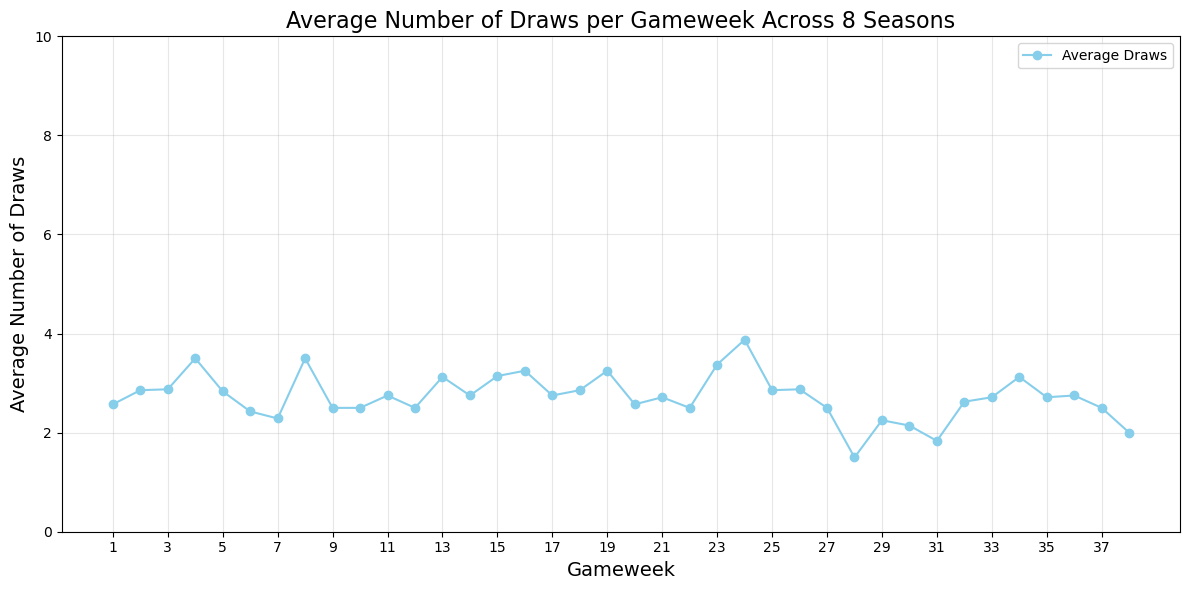

In [418]:
def plot_average_draws_per_gameweek(data):
    """
    Function to plot the average number of draws per gameweek across all seasons.

    Parameters:
        data (pd.DataFrame): The input dataframe containing 'season', 'Gameweek / 38', and 'Result'.
    """
    import matplotlib.pyplot as plt

    # Ensure proper data types
    data['season'] = data['season'].astype(str)
    data['Gameweek / 38'] = data['Gameweek / 38'].astype(int)
    data['Result'] = data['Result'].astype(int)

    # Count the number of draws (Result == 0) per gameweek for each season
    draws_per_gameweek = (
        data[data['Result'] == 0]
        .groupby(['season', 'Gameweek / 38'])
        .size()
        .reset_index(name='draw_count')
    )

    # Calculate the average number of draws per gameweek across all seasons
    average_draws = (
        draws_per_gameweek.groupby('Gameweek / 38')['draw_count']
        .mean()
        .reset_index(name='average_draws')
    )

    # Plot the average number of draws per gameweek
    plt.figure(figsize=(12, 6))
    plt.plot(
        average_draws['Gameweek / 38'], 
        average_draws['average_draws'], 
        marker='o', 
        linestyle='-', 
        color='skyblue', 
        label='Average Draws'
    )
    plt.title("Average Number of Draws per Gameweek Across 8 Seasons", fontsize=16)
    plt.xlabel("Gameweek", fontsize=14)
    plt.ylabel("Average Number of Draws", fontsize=14)
    plt.ylim(0, 10)  # Reflecting the maximum number of matches per gameweek
    plt.xticks(range(1, 39, 2))  # Show every other gameweek for better readability
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Test the function with the sample data
plot_average_draws_per_gameweek(prem)


Again nothing really jumping out about draws being more common at certain points of the season. There is a **slight** increase into gameweeks 13 through 25 ish and general decline after, but this is marginal and it is still essentially two or three games per round end in a draw. 

**Who is drawing PL matches??**

### Points per game (over entire timeline) - EDA

I will use a dataframe pl_points I made below for points per game, to clearly show strong and weak teams, to do initial EDA

In [419]:
pl_points[pl_points['Appearances'] == 304]

,Appearances,Home Wins,Away Wins,Home Draws,Away Draws,Home Losses,Away Losses,Points,Points per Game
Arsenal,304,97,73,34,39,21,40,583,1.92
Aston Villa,304,45,41,50,38,57,73,346,1.14
Chelsea,304,101,75,34,36,17,41,598,1.97
Everton,304,76,45,43,57,33,50,463,1.52
Liverpool,304,86,64,43,33,23,55,526,1.73
Manchester City,304,113,62,18,43,21,47,586,1.93
Manchester United,304,116,76,16,41,20,35,633,2.08
Stoke City,304,69,29,43,43,40,80,380,1.25
Sunderland,304,49,29,47,45,56,78,326,1.07
Tottenham Hotspur,304,88,63,36,38,28,51,527,1.73


For fairness let's start by comparing the teams who spent all 8 seasons in the premier league (appearances = 304). We can do a correlation heatmap and scatter plot.

We obviously expect wins to correlate with ppg, but I want to see if draws correlate negatively or positively with ppg

What about finding the combined points per game between two teams, and checking the tendency of results? That would show if two big teams are more likely to draw than two weak teams

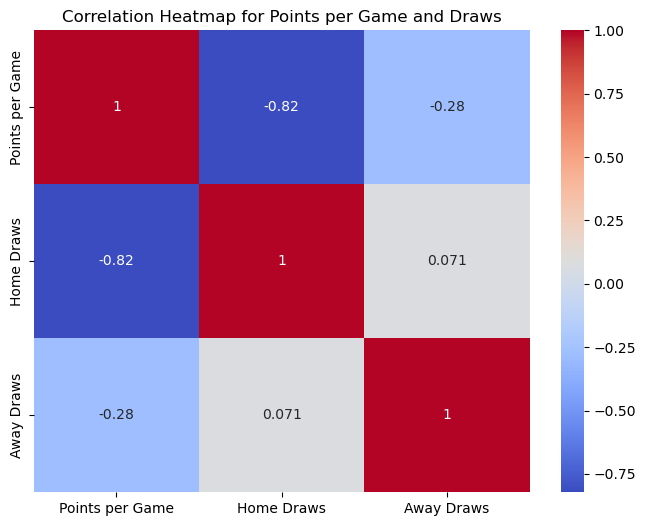

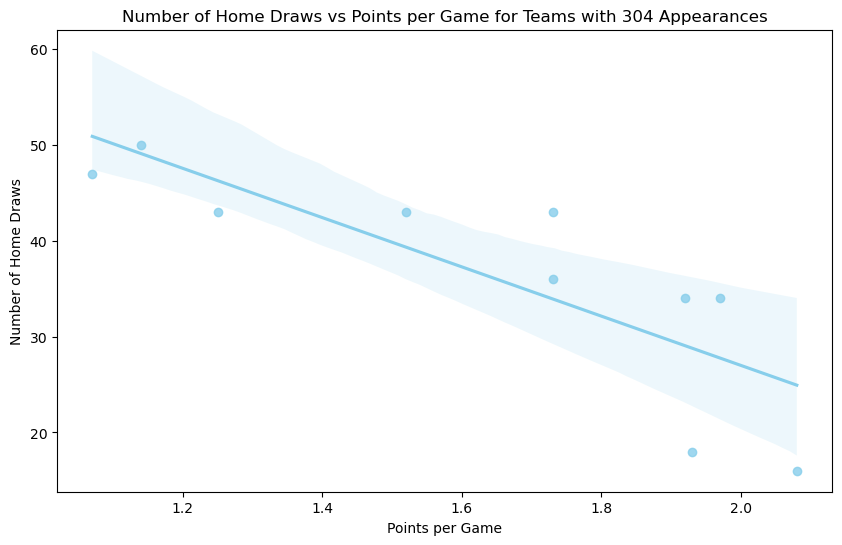

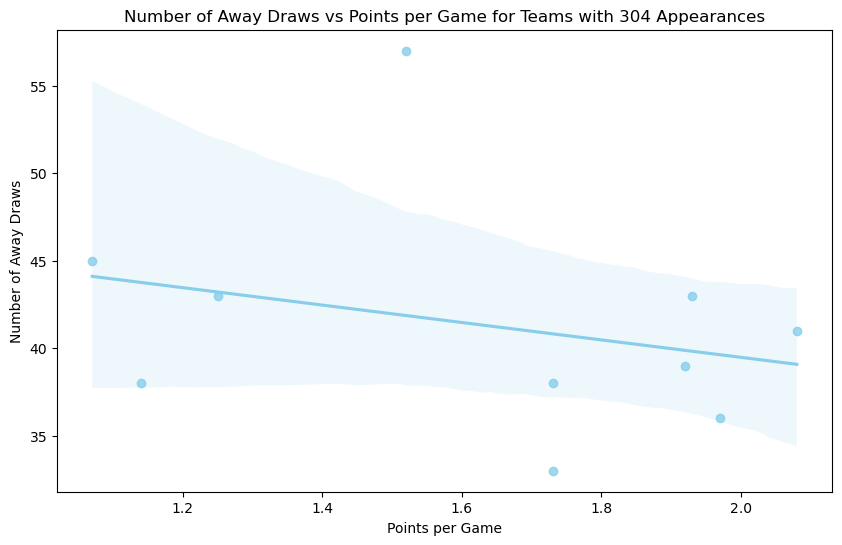

In [420]:
# create a subset of pl_points with only teams with 304 appearances
pl_points_304 = pl_points[pl_points['Appearances'] == 304]

# correlation heatmap of pl_points_304 with Points per Game, Home Draws, and Away Draws
plt.figure(figsize=(8, 6))
sns.heatmap(pl_points_304[['Points per Game', 'Home Draws', 'Away Draws']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Points per Game and Draws')
plt.show()


# plot the number of home draws, against points per game, add trendline
plt.figure(figsize=(10, 6))
sns.regplot(data=pl_points_304, x='Points per Game', y='Home Draws', color='skyblue')
plt.title('Number of Home Draws vs Points per Game for Teams with 304 Appearances')
plt.xlabel('Points per Game')
plt.ylabel('Number of Home Draws')
plt.show()


# plot the number of away draws combined, against points per game, add trendline
plt.figure(figsize=(10, 6))
sns.regplot(data=pl_points_304, x='Points per Game', y='Away Draws', color='skyblue')
plt.title('Number of Away Draws vs Points per Game for Teams with 304 Appearances')
plt.xlabel('Points per Game')
plt.ylabel('Number of Away Draws')
plt.show()

The anomaly in away draws with 57 is Everton - a Premier League stalwart and draw merchant that has been consistently average during this period!

We can see that home draws are strongly correlated against for teams with high ppg. this is probably just illustrating the 3 pt win / 1 pt draw gap, doubly important compared to the draw / loss points difference.

But this shows the average teams that survived the whole period vs the top teams that turned draws into wins, and the away draws also dry up at higher ppg.

Let's bring in the other teams and help compare them with probabilities based on total games

In [421]:
# create p(Home Win), p(Away Win), p(Home Draw), p(Away Draw), p(Home Loss), p(Away Loss) columns by dividing the respective columns by the number in the Appearances column
pl_points['p(Home Win)'] = pl_points['Home Wins'] / pl_points['Appearances']
pl_points['p(Away Win)'] = pl_points['Away Wins'] / pl_points['Appearances']
pl_points['p(Home Draw)'] = pl_points['Home Draws'] / pl_points['Appearances']
pl_points['p(Away Draw)'] = pl_points['Away Draws'] / pl_points['Appearances']
pl_points['p(Home Loss)'] = pl_points['Home Losses'] / pl_points['Appearances']
pl_points['p(Away Loss)'] = pl_points['Away Losses'] / pl_points['Appearances']


So we are trying to assess the different impact of home draws vs away draws. Conventional wisdom says a team drawing at home is 'dropping two points', a team drawing away is usually a good result. Even though both award 1 point

Correlation heatmap of ppg and home and away draws

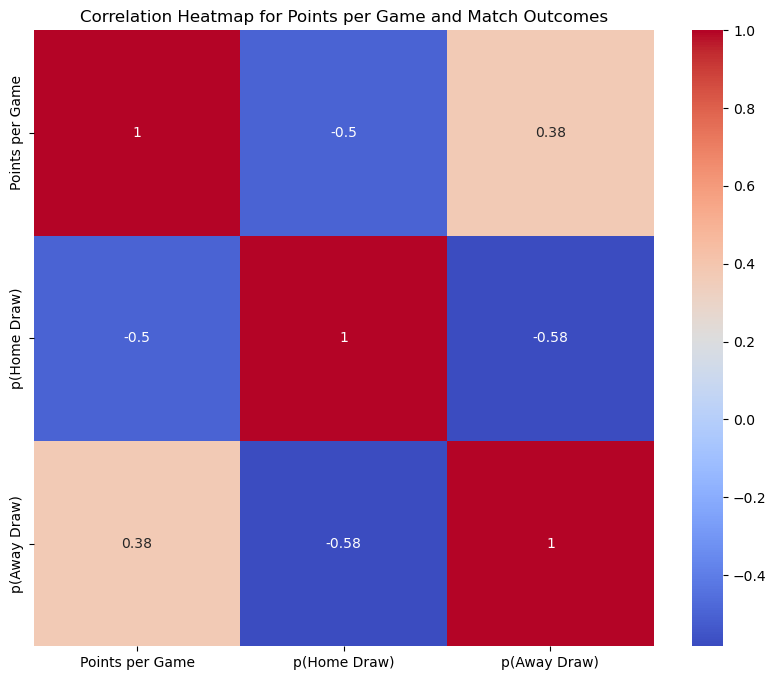

In [422]:
# correlation heatmap of pl_points with Points per Game, p(Home Win), p(Away Win), p(Home Draw), p(Away Draw), p(Home Loss), p(Away Loss)
plt.figure(figsize=(10, 8))
sns.heatmap(pl_points[['Points per Game', 'p(Home Draw)', 'p(Away Draw)']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Points per Game and Match Outcomes')
plt.show()

**Now we've added all PL appearing teams, p(away draw) is now moderately positively correlated +0.38 with PpG.** It was stronger in the negative correlation -0.5 with just the 10 Premier League mainstays.

For me, this shows that home draws are universally sub-optimal results but away draws are beneficial, and are of unique note to most teams that are not among the highest PpG

Now we'll plot the probability of draws against the points per game. We are looking more at the home away differentials, so we can overlay the two home and away

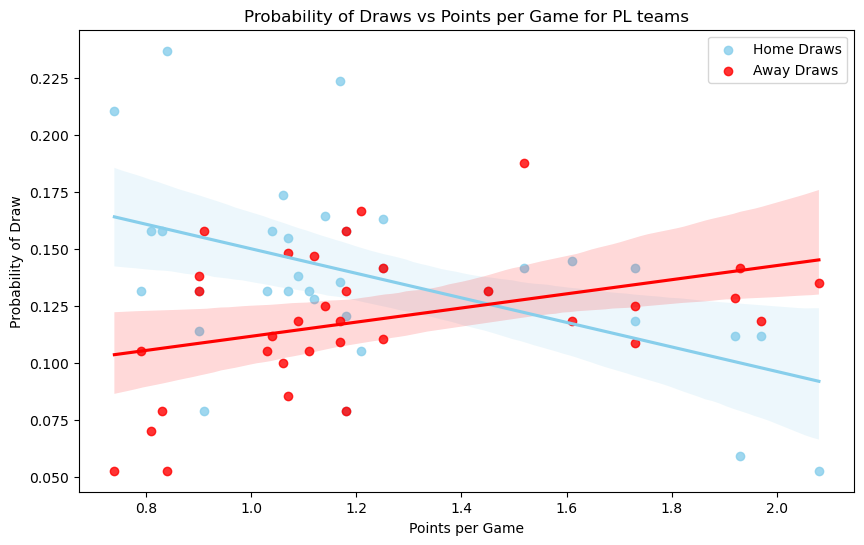

In [423]:
# plot the probability of home draws and probability of away draws against points per game, same figure and subplot, different colours, add trendlines for both
plt.figure(figsize=(10, 6))
sns.regplot(data=pl_points, x='Points per Game', y='p(Home Draw)', color='skyblue', label='Home Draws')
sns.regplot(data=pl_points, x='Points per Game', y='p(Away Draw)', color='red', label='Away Draws')
plt.title('Probability of Draws vs Points per Game for PL teams')
plt.xlabel('Points per Game')
plt.ylabel('Probability of Draw')
plt.legend()
plt.show()

This last graph shows the fundamentally different result an away draw is from a home draw, away wins being generally beneficial as teams improve losing away to grinding out a draw. Conversely, they work to turn home draws into wins.

Next we should look at **the probability of draws based on the quality of the home and away teams**. Answer questions like:
- Are good teams 1.5+ PpG drawing with each other more than weaker teams (0.8 - 1.1)?

Function below allows us to add home and away team points per game into the match data

In [424]:
def add_points_per_game(df, points):
    """
    Add points per game for home and away teams to the prem_draws dataframe.

    Parameters:
        prem_draws (pd.DataFrame): DataFrame containing match data with home and away team names.
        pl_points (pd.DataFrame): DataFrame with team names as the index and a 'Points per Game' column.

    Returns:
        pd.DataFrame: Updated prem_draws with 'home_team_ppg' and 'away_team_ppg' columns added.
    """
    # Merge home team points per game
    df = df.merge(
        points[['Points per Game']],
        how='left',
        left_on='home_team',  # Match the home team column
        right_index=True,  # Use the index of pl_points
        suffixes=('', '_home')
    ).rename(columns={'Points per Game': 'home_team_ppg'})

    # Merge away team points per game
    df = df.merge(
        points[['Points per Game']],
        how='left',
        left_on='away_team',  # Match the away team column
        right_index=True,  # Use the index of pl_points
        suffixes=('', '_away')
    ).rename(columns={'Points per Game': 'away_team_ppg'})

    return df

In [425]:
add_points_per_game(prem, pl_points).sample(1)

,date,Venue,Gameweek / 38,home_team,Home Manager,Home GF,Away GF,away_team,Away Manager,Result,...,cross,corner,possession,Venue Code,Home Manager Code,Away Manager Code,Day,Day Code,home_team_ppg,away_team_ppg
2272,2013-10-26,Selhurst Park,9,Crystal Palace,Keith Millen (caretaker),0,2,Arsenal,Arsène Wenger,-1,...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>21</comment><event...,19,36,7,Saturday,2,1.18,1.92


In [426]:
prem = add_points_per_game(prem, pl_points)

In [427]:
prem.sample(3)

,date,Venue,Gameweek / 38,home_team,Home Manager,Home GF,Away GF,away_team,Away Manager,Result,...,cross,corner,possession,Venue Code,Home Manager Code,Away Manager Code,Day,Day Code,home_team_ppg,away_team_ppg
1716,2013-02-23,Loftus Road,27,Queens Park Rangers,Harry Redknapp,0,2,Manchester United,Sir Alex Ferguson,-1,...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>50</comment><event...,12,28,77,Saturday,2,0.81,2.08
1334,2012-03-04,St James' Park,27,Newcastle United,Alan Pardew,1,1,Sunderland,Martin O'Neill,0,...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>46</comment><event...,21,2,47,Sunday,3,1.17,1.07
79,2008-12-06,MKM Stadium,16,Hull City,Phil Brown,2,1,Middlesbrough,Gareth Southgate,1,...,<cross><value><stats><crosses>1</crosses></sta...,<corner><value><stats><corners>1</corners></st...,<possession><value><comment>41</comment><event...,13,62,21,Saturday,2,0.90,0.84


I now want to see if there are more draws among weaker or stronger teams playing each other. 

A scatter plot would be good here because clustering will be easily visible, each point represents a draw. It would reveal clusters if draws tend to happen with a weak home / strong away team, strong home and away teams or weak home and away teams. I will also do a heat map.

However, we need to normalize matches based on PPG first - there are more average teams than top teams, so we are going to observe more draws between average teams than top teams by sheer volume, not football related reasons.

We can use the full prem dataframe and the filtered prem dataframe with only draws. Then we'll divide the number of draws by the total number of matches in each category to find the **draw probability**

We can also bin or group teams by a PpG category:

- **<1 is Low** for relegation strugglers
- **1 - 1.4 is Medium** for mid table where 1.0 ppg is essentially safety from relegation, and 1.4 ppg is top half of the table, pushing for European places
- **1.4 - 1.8 is High**, European places and close to pushing for UCL

- **1.8+ is Elite**, UCL qualification and title chasing

In [428]:
# create a prem_draws subset of prem with only draws, where Result == 0
prem_draws = prem[prem['Result'] == 0]

In [429]:
def categorize_ppg(ppg, bins=[0, 1.0, 1.4, 1.8, float('inf')], labels=['Low', 'Medium', 'High', 'Elite']): 
    """
    Categorize points per game (PPG) into bins.
    """
    return pd.cut(ppg, bins=bins, labels=labels, right=False)

In [430]:
def calculate_draw_probabilities_normalized(prem, prem_draws):
    """
    Calculate the normalized probability of a draw for each combination of home and away PPG categories.

    Parameters:
        prem (pd.DataFrame): Full DataFrame containing all results with home and away PPG.
        prem_draws (pd.DataFrame): Subset DataFrame containing only draws.

    Returns:
        pd.DataFrame: DataFrame with probabilities of a draw for each PPG combination.
    """
    # Categorize PPG for both datasets
    prem['home_ppg_category'] = categorize_ppg(prem['home_team_ppg'])
    prem['away_ppg_category'] = categorize_ppg(prem['away_team_ppg'])
    prem_draws['home_ppg_category'] = categorize_ppg(prem_draws['home_team_ppg'])
    prem_draws['away_ppg_category'] = categorize_ppg(prem_draws['away_team_ppg'])

    # Count total matches for each PPG category combination
    total_matches = prem.groupby(['home_ppg_category', 'away_ppg_category']).size().reset_index(name='total_matches')

    # Count total draws for each PPG category combination
    total_draws = prem_draws.groupby(['home_ppg_category', 'away_ppg_category']).size().reset_index(name='total_draws')

    # Merge to calculate probabilities
    draw_stats = total_matches.merge(total_draws, on=['home_ppg_category', 'away_ppg_category'], how='left')
    draw_stats['total_draws'] = draw_stats['total_draws'].fillna(0)  # Fill NaN draws with 0
    draw_stats['draw_probability'] = draw_stats['total_draws'] / draw_stats['total_matches']

    return draw_stats


In [431]:
def visualize_draw_probabilities(draw_stats):
    """
    Visualize draw probabilities for each home and away PPG category combination.

    Parameters:
        draw_stats (pd.DataFrame): DataFrame with draw probabilities and PPG categories.

    Returns:
        None: Displays a heatmap with home team PPG on the x-axis and away team PPG on the y-axis.
    """
    # Pivot the data for heatmap
    heatmap_data = draw_stats.pivot(
        index='away_ppg_category',  # Away team PPG on the y-axis
        columns='home_ppg_category',  # Home team PPG on the x-axis
        values='draw_probability'
    )

    # reverse plotted one axis below - elite / elite is in the top right
    heatmap_data = heatmap_data.iloc[::-1, ::]

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        heatmap_data, 
        annot=True, 
        cmap='Blues', 
        fmt='.2f', 
        linewidths=0.5, 
        cbar_kws={'label': 'Probability of Draw'}
    )
    plt.title("Normalized draw probability Based on Pts Per Game", fontsize=16)
    plt.xlabel("Home Team PPG Category", fontsize=14)
    plt.ylabel("Away Team PPG Category", fontsize=14)
    plt.tight_layout()
    plt.show()

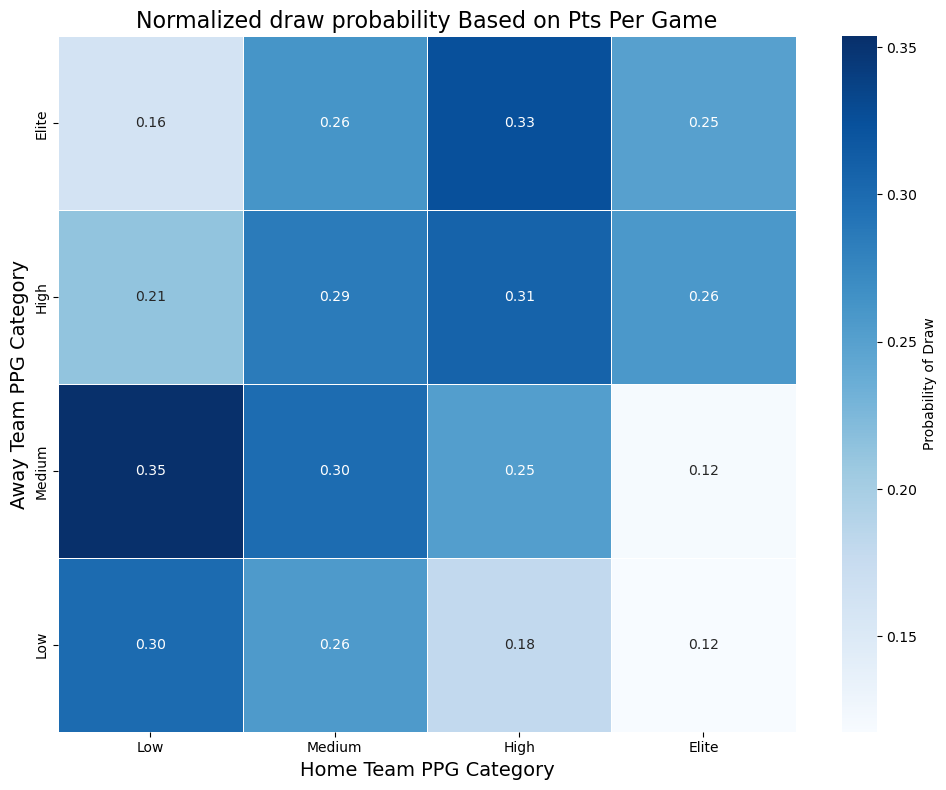

In [432]:
# Calculate draw probabilities
draw_stats = calculate_draw_probabilities_normalized(prem, prem_draws)

# Visualize the probabilities
visualize_draw_probabilities(draw_stats)

The general view above is that its slightly 'hotter' above the diagonal line than below it which reflects home field advantage leading to draws for weaker teams.
- For example in home/away matches between Low/Medium there's a 35% chance of a draw, Low/Low 30%, Med/Low 26%
- For matches between equal teams, Elite/Elite is actually the least likely to be a draw. High/Elite is 33% likely to be a draw.

### Points Per game - season so far.

- Looking to use a more fluid measure of points per game (not just entire PpG over the 8 year period in the PL) which may make visualising any draw trends easier, given team form fluctuates.

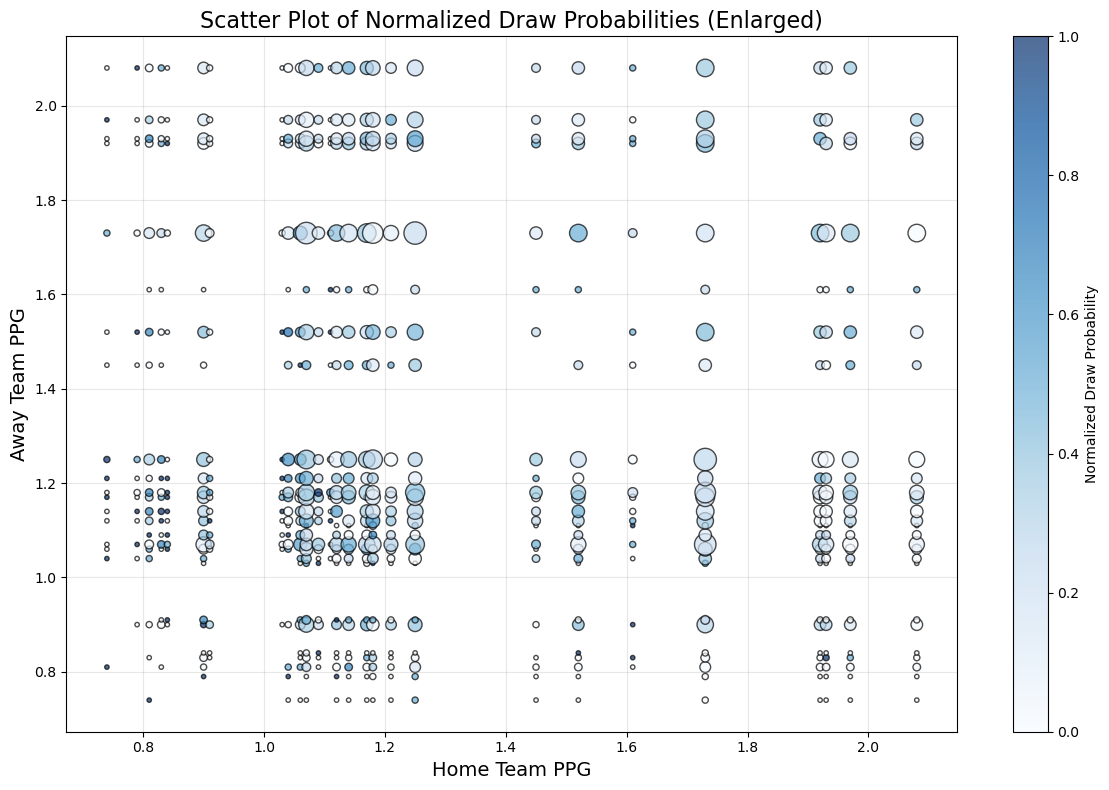

In [433]:
def plot_scatter_draw_probability(prem, prem_draws, size_factor=10):
    """
    Create a scatter plot for normalized draw probabilities based on home and away PPG.

    Parameters:
        prem (pd.DataFrame): Full DataFrame containing all results with home and away PPG.
        prem_draws (pd.DataFrame): Subset DataFrame containing only draws.
        size_factor (int): Factor to scale the size of the points (default: 50).

    Returns:
        None: Displays a scatter plot.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Count total matches
    total_matches = prem.groupby(['home_team_ppg', 'away_team_ppg']).size().reset_index(name='total_matches')

    # Count total draws
    total_draws = prem_draws.groupby(['home_team_ppg', 'away_team_ppg']).size().reset_index(name='total_draws')

    # Merge and normalize
    draw_stats = total_matches.merge(total_draws, on=['home_team_ppg', 'away_team_ppg'], how='left')
    draw_stats['total_draws'] = draw_stats['total_draws'].fillna(0)  # Fill NaN draws with 0
    draw_stats['draw_probability'] = draw_stats['total_draws'] / draw_stats['total_matches']

    # Check for non-empty data
    if draw_stats.empty:
        print("No data available for plotting.")
        return

    # Scale dot size by total matches and a size factor
    draw_stats['scaled_size'] = draw_stats['total_matches'] * size_factor

    # Create scatter plot
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        draw_stats['home_team_ppg'],
        draw_stats['away_team_ppg'],
        c=draw_stats['draw_probability'],  # Color by draw probability
        s=draw_stats['scaled_size'],  # Scaled size by total matches
        cmap='Blues',
        alpha=0.7,
        edgecolor='black'
    )
    plt.colorbar(scatter, label='Normalized Draw Probability')
    plt.title("Scatter Plot of Normalized Draw Probabilities (Enlarged)", fontsize=16)
    plt.xlabel("Home Team PPG", fontsize=14)
    plt.ylabel("Away Team PPG", fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_scatter_draw_probability(prem, prem_draws)


#### Guide to above plot:
- **Point size = number of matches** for that PpG combination
    - The discrete lines it makes are because it's specific teams with that PpG across the 8 year period. We could make this more granular by giving the teams a more fluid PpG rather than one over the entire 8 year period
- **Dot colour = normalized draw probability**

- The dots appear in discrete lines up and across the graph because they represent the PpG average of each unique team during their entire stay in the PL data, however long that might be. That is probably why the darkest dots tend to be the smallest (1 matchup, 1 draw)

We can see a lot more white dots on the bottom right (weak away team, strong home team) than the top left (weak home team, stronger away team) so with this and the heatmap we can *generally* say that home field advatage compensates for a moderate gap in quality.

In [434]:
# delete the ppg_category columns now
prem = prem.drop(['home_ppg_category', 'away_ppg_category'], axis=1)

### Note on heatmap binning and discrete scatter plot above - it may be slightly misleading

The binning of teams by those PpG categories may cause some edge cases to magnify one bin over another. The scatter plot is also a little dense to read in its current state, as it's trying to balance out the larger sample size of matches between weaker teams compared to better ones.

Below is a density probability plot which can show the continuous shift more easily.

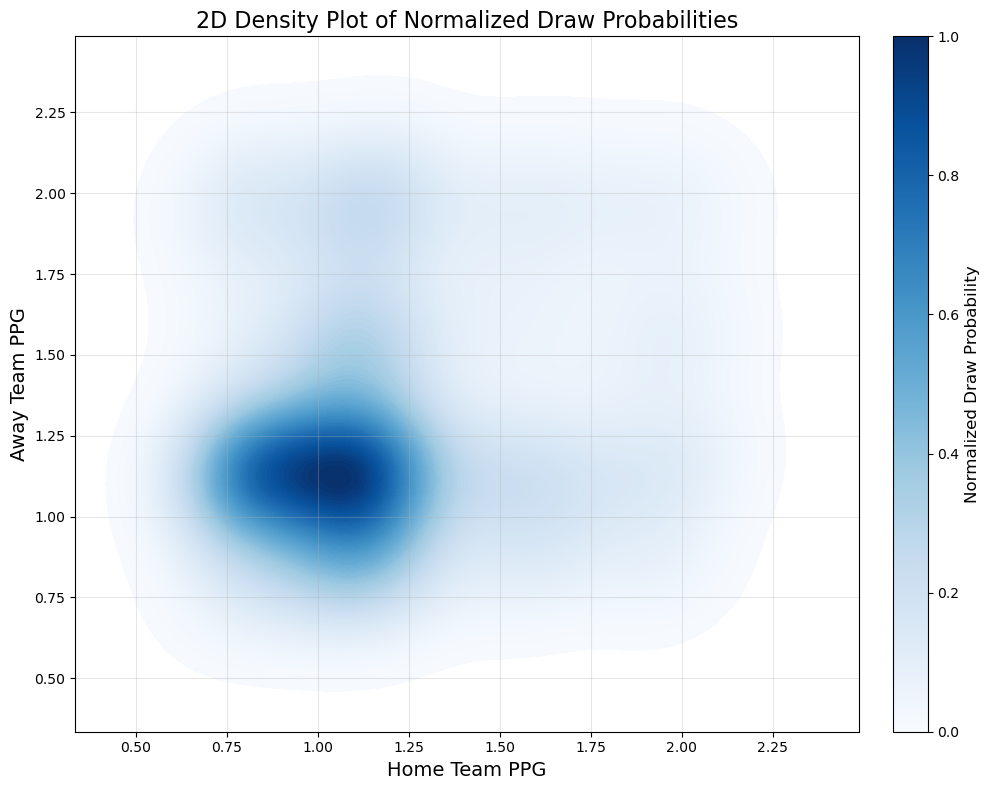

In [435]:
def plot_density_draw_probability(prem, prem_draws):
    """
    Create a 2D density plot for normalized draw probabilities based on home and away PPG.

    Parameters:
        prem (pd.DataFrame): Full DataFrame containing all results with home and away PPG.
        prem_draws (pd.DataFrame): Subset DataFrame containing only draws.

    Returns:
        None: Displays a 2D density plot with a color bar.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Count total matches
    total_matches = prem.groupby(['home_team_ppg', 'away_team_ppg']).size().reset_index(name='total_matches')

    # Count total draws
    total_draws = prem_draws.groupby(['home_team_ppg', 'away_team_ppg']).size().reset_index(name='total_draws')

    # Merge and normalize
    draw_stats = total_matches.merge(total_draws, on=['home_team_ppg', 'away_team_ppg'], how='left')
    draw_stats['total_draws'] = draw_stats['total_draws'].fillna(0)  # Fill NaN draws with 0
    draw_stats['draw_probability'] = draw_stats['total_draws'] / draw_stats['total_matches']

    # Check for non-empty data
    if draw_stats.empty:
        print("No data available for plotting.")
        return

    # Create a 2D density plot
    plt.figure(figsize=(10, 8))
    density = sns.kdeplot(
        x=draw_stats['home_team_ppg'],
        y=draw_stats['away_team_ppg'],
        weights=draw_stats['draw_probability'],
        cmap='Blues',
        fill=True,
        thresh=0.01,  # Slight threshold to remove insignificant regions
        levels=100
    )

    # Add color bar
    sm = plt.cm.ScalarMappable(cmap='Blues')
    sm.set_array(draw_stats['draw_probability'])
    cbar = plt.colorbar(sm, ax=density.get_figure().axes[-1], fraction=0.046, pad=0.04)
    cbar.set_label('Normalized Draw Probability', fontsize=12)

    # Plot adjustments
    plt.title("2D Density Plot of Normalized Draw Probabilities", fontsize=16)
    plt.xlabel("Home Team PPG", fontsize=14)
    plt.ylabel("Away Team PPG", fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_density_draw_probability(prem, prem_draws)

It does seem like draws are more common at the lower end. 

The big cloud sits around 1.05 PpG Home - 1.15 PpG Away, approximately, with the drag left showing the home team's PpG can dip lower and still hold a slightly stronger opponent to a draw.

With the knowledge that it is noticeably when the home team is slightly weaker that draws are forced, and this seems to be true with a few angles of viewing this, we can engineer a **combined PpG of teams in a given match**.

We need to be careful to tease out the makeup of this combined statistic. Is the PpG made up of one excellent and one poor team, or two medium quality teams?

To pull this off we should use a PpG difference metric too.

In [436]:
prem.columns

Index(['date', 'Venue', 'Gameweek / 38', 'home_team', 'Home Manager',
       'Home GF', 'Away GF', 'away_team', 'Away Manager', 'Result', 'Home Win',
       'p(Home)', 'p(Draw)', 'p(Away)', 'Margin', 'id', 'season', 'Home ID',
       'Away ID', 'home_player_1', 'home_player_2', 'home_player_3',
       'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7',
       'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11',
       'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
       'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8',
       'away_player_9', 'away_player_10', 'away_player_11', 'goal', 'shoton',
       'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession',
       'Venue Code', 'Home Manager Code', 'Away Manager Code', 'Day',
       'Day Code', 'home_team_ppg', 'away_team_ppg'],
      dtype='object')

In [437]:
def plot_combined_ppg_vs_ppg_difference(prem, prem_draws, size_factor=10):
    """
    Create a scatter plot of combined PPG vs PPG difference with draw probabilities.

    Parameters:
        prem (pd.DataFrame): Full DataFrame containing all results with home and away PPG.
        prem_draws (pd.DataFrame): Subset DataFrame containing only draws.
        size_factor (int): Factor to scale the size of the points (default: 50).

    Returns:
        Scatter Plot display.
    """
    import matplotlib.pyplot as plt

    # Count total matches
    total_matches = prem.groupby(['home_team_ppg', 'away_team_ppg']).size().reset_index(name='total_matches')

    # Count total draws
    total_draws = prem_draws.groupby(['home_team_ppg', 'away_team_ppg']).size().reset_index(name='total_draws')

    # Merge and normalize
    draw_stats = total_matches.merge(total_draws, on=['home_team_ppg', 'away_team_ppg'], how='left')
    draw_stats['total_draws'] = draw_stats['total_draws'].fillna(0)  # Fill NaN draws with 0
    draw_stats['draw_probability'] = draw_stats['total_draws'] / draw_stats['total_matches']

    # Create new features
    draw_stats['combined_ppg'] = draw_stats['home_team_ppg'] + draw_stats['away_team_ppg']
    draw_stats['ppg_difference'] = abs(draw_stats['home_team_ppg'] - draw_stats['away_team_ppg'])
    draw_stats['scaled_size'] = draw_stats['total_matches'] * size_factor

    # Scatter plot
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        draw_stats['combined_ppg'],
        draw_stats['ppg_difference'],
        c=draw_stats['draw_probability'],  # Color by draw probability
        s=draw_stats['scaled_size'],  # Size by total matches
        cmap='Blues',
        alpha=0.7,
        edgecolor='black'
    )
    plt.colorbar(scatter, label='Normalized Draw Probability')
    plt.title("Scatter Plot of Combined PPG vs PPG Difference", fontsize=16)
    plt.xlabel("Combined PPG (Home + Away)", fontsize=14)
    plt.ylabel("PPG Difference (|Home - Away|)", fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

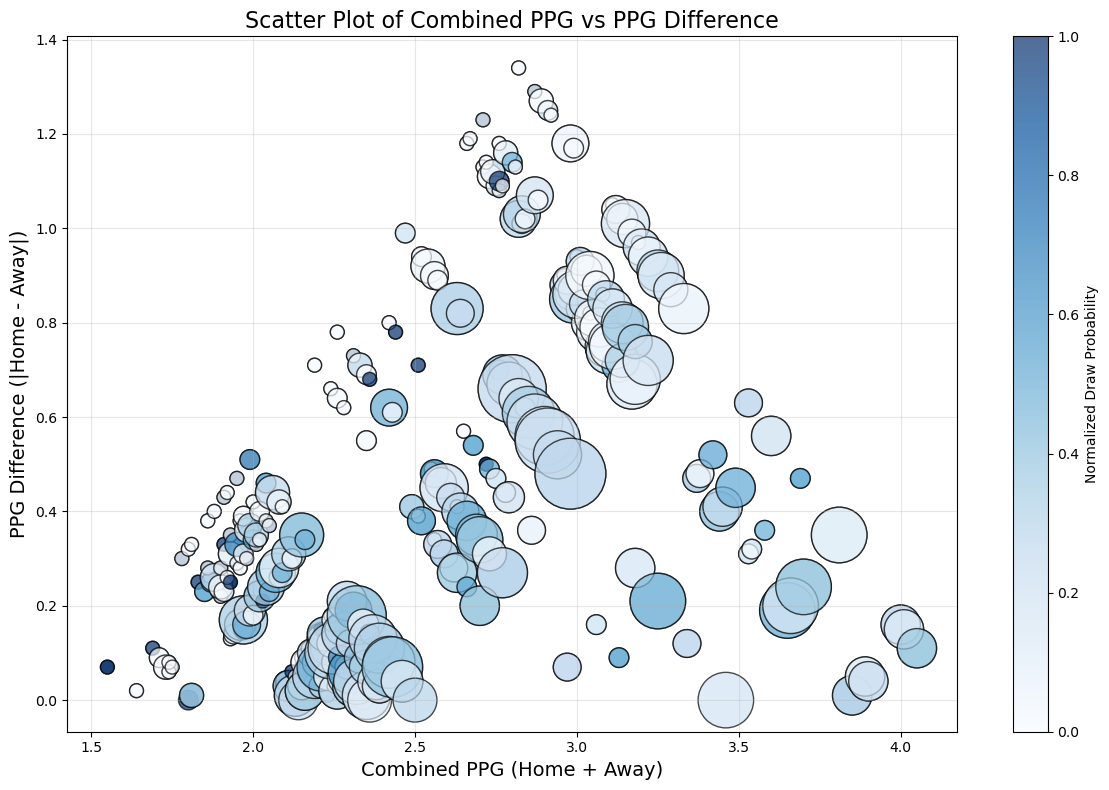

In [438]:
plot_combined_ppg_vs_ppg_difference(prem, prem_draws, size_factor=100)

The graph makes specific 'streaks' like this across the figure because each dot is a specific team playing one specific other team to produce a distinct (precise) combined PpG.

If we were able to capture a more dynamic points per game from the season so far, or something over the medium term that was fluid, the graph may be easier to interpret.
This would produce a graph without these 'streaks' and most dots would be small as they represent the combination of PpGs which are dynamically moving, as results come in now.

### Trying to visualize ppg_season for draw tendency

In [439]:
calculate_team_metrics(prem_draws)

Processing season: 08/09...
Processing season: 09/10...
Processing season: 10/11...
Processing season: 11/12...
Processing season: 12/13...
Processing season: 13/14...
Processing season: 14/15...
Processing season: 15/16...


,date,Venue,Gameweek / 38,home_team,Home Manager,Home GF,Away GF,away_team,Away Manager,Result,...,Day,Day Code,home_team_ppg,away_team_ppg,home_ppg_category,away_ppg_category,home_ppg_season,home_pts_last_5,away_ppg_season,away_pts_last_5
0,2008-08-17,Old Trafford,1,Manchester United,Sir Alex Ferguson,1,1,Newcastle United,Kevin Keegan,0,...,Sunday,3,2.08,1.17,Elite,Medium,0.0,0,0.0,0
11,2008-10-29,Emirates Stadium,10,Arsenal,Arsène Wenger,4,4,Tottenham Hotspur,Harry Redknapp,0,...,Wednesday,6,1.92,1.73,Elite,High,1.0,1,1.0,2
23,2008-11-01,Riverside Stadium,11,Middlesbrough,Gareth Southgate,1,1,West Ham United,Gianfranco Zola,0,...,Saturday,2,0.84,1.18,Low,Medium,1.0,1,0.0,0
26,2008-11-01,The Hawthorns,11,West Bromwich Albion,Tony Mowbray,2,2,Blackburn Rovers,Paul Ince,0,...,Saturday,2,1.12,1.09,Medium,Medium,1.0,1,1.0,3
39,2008-11-08,DW Stadium,12,Wigan Athletic,Steve Bruce,0,0,Stoke City,Tony Pulis,0,...,Saturday,2,1.06,1.25,Medium,Medium,1.0,2,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3025,2015-10-04,Goodison Park,8,Everton,Roberto Martínez,1,1,Liverpool,Brendan Rodgers,0,...,Sunday,3,1.52,1.73,High,High,1.0,3,1.0,2
3028,2015-10-03,Stadium of Light,8,Sunderland,Dick Advocaat,2,2,West Ham United,Slaven Bilić,0,...,Saturday,2,1.07,1.18,Medium,Medium,1.0,2,1.0,1
3029,2015-10-04,Swansea.com Stadium,8,Swansea City,Garry Monk,2,2,Tottenham Hotspur,Mauricio Pochettino,0,...,Sunday,3,1.25,1.73,Medium,High,1.0,3,1.0,3
3035,2015-10-17,St Mary's Stadium,9,Southampton,Ronald Koeman,2,2,Leicester City,Claudio Ranieri,0,...,Saturday,2,1.45,1.61,High,High,1.0,3,1.0,3


In [440]:
def plot_combined_ppg_season_vs_ppg_difference(prem, prem_draws, size_factor=10):
    """
    Create a scatter plot of combined PPG vs PPG difference with draw probabilities.

    Parameters:
        prem (pd.DataFrame): Full DataFrame containing all results with home and away PPG.
        prem_draws (pd.DataFrame): Subset DataFrame containing only draws.
        size_factor (int): Factor to scale the size of the points (default: 50).

    Returns:
        Scatter Plot display.
    """
    import matplotlib.pyplot as plt

    # Count total matches
    total_matches = prem.groupby(['home_ppg_season', 'away_ppg_season']).size().reset_index(name='total_matches')

    # Count total draws
    total_draws = prem_draws.groupby(['home_ppg_season', 'away_ppg_season']).size().reset_index(name='total_draws')

    # Merge and normalize
    draw_stats = total_matches.merge(total_draws, on=['home_ppg_season', 'away_ppg_season'], how='left')
    draw_stats['total_draws'] = draw_stats['total_draws'].fillna(0)  # Fill NaN draws with 0
    draw_stats['draw_probability'] = draw_stats['total_draws'] / draw_stats['total_matches']

    # Filter out rows where both home_ppg_season and away_ppg_season are 0
    draw_stats = draw_stats[
        ~((draw_stats['home_ppg_season'] == 0) & (draw_stats['away_ppg_season'] == 0))
    ]

    # Create new features
    draw_stats['combined_ppg_season'] = draw_stats['home_ppg_season'] + draw_stats['away_ppg_season']
    draw_stats['ppg_season_difference'] = abs(draw_stats['home_ppg_season'] - draw_stats['away_ppg_season'])
    draw_stats['scaled_size'] = draw_stats['total_matches'] * size_factor

    # Scatter plot
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(
        draw_stats['combined_ppg_season'],
        draw_stats['ppg_season_difference'],
        c=draw_stats['draw_probability'],  # Color by draw probability
        s=draw_stats['scaled_size'],  # Size by total matches
        cmap='Blues',
        alpha=0.7,
        edgecolor='black'
    )
    plt.colorbar(scatter, label='Normalized Draw Probability')
    plt.title("Scatter Plot of Combined PPG vs PPG Difference on current season so far", fontsize=16)
    plt.xlabel("Combined PPG (Home + Away)", fontsize=14)
    plt.ylabel("PPG Difference (|Home - Away|)", fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [441]:
# error at this time
# 
# plot_combined_ppg_season_vs_ppg_difference(prem, prem_draws, size_factor=10)

This is also not very helpful as the (0, 0.0) result dwarfs everything and the plot as it stands, seems to be skewed off by the (2,0.0) result which is essentially game 2 where game 1 was a draw for both sides (hence a clean 1 pt / 1 game = 1 PpG). This needs cleaning up later. Maybe by binning the PpGs

### Conclusions from this section

It's been a little frustrating trying to tease out the general probability of draws based on the team's overall points per game, attempting through categorisation & binning, dealing with a varied sample size and visualisation to try to overcome that. 

Draws seem to be occasionally rare events that can pop up across the board, however we can say that draws tend to occur more with a slightly weaker home team compared to the away team, which combined with home field advantage can force stalemates.

## The team's form this season (PpG season, last 5 results)
The EDA around Leicester City having two completely different seasons in terms of performance shows that a lot of model performance will be in capturing the current season dynamics of the team. This can mean:
- Points per game so far this season, (for this season where gameweek is less than the current record, find the win/draw/losses of the team)
- Last 5 league results (how to encode this? Let's first try the sum of points in the last 5 games
- Try it first with ten games of one season in a small df

In [442]:
# trial small prem df for the function. All columns except season, date, gameweek / 38, home team, home GF, away GF, away team, result, margin 
prem_trial = prem[['season', 'date', 'Gameweek / 38', 'home_team', 'Home GF', 'Away GF', 'away_team', 'Result', 'Margin']]

# filter the dataframe so only season 15/16 is there
prem_trial = prem_trial[prem_trial['season'] == '15/16']

prem_trial.sort_values(by='date')

,season,date,Gameweek / 38,home_team,Home GF,Away GF,away_team,Result,Margin
2661,15/16,2015-08-08,1,Bournemouth,0,1,Aston Villa,-1,-1
2662,15/16,2015-08-08,1,Chelsea,2,2,Swansea City,0,0
2663,15/16,2015-08-08,1,Everton,2,2,Watford,0,0
2664,15/16,2015-08-08,1,Leicester City,4,2,Sunderland,1,2
2665,15/16,2015-08-08,1,Manchester United,1,0,Tottenham Hotspur,1,1
...,...,...,...,...,...,...,...,...,...
2972,15/16,2016-05-15,38,Everton,3,0,Norwich City,1,3
2971,15/16,2016-05-15,38,Chelsea,1,1,Leicester City,0,0
2970,15/16,2016-05-15,38,Arsenal,4,0,Aston Villa,1,4
2975,15/16,2016-05-15,38,Southampton,4,1,Crystal Palace,1,3


Calculating Points per game and last 5 below:

In [443]:
def calculate_team_metrics(df):
    """
    Add columns for home and away team metrics ('ppg_season' and 'pts_last_5').

    Parameters:
        df (pd.DataFrame): DataFrame containing match data with 'season', 'Gameweek / 38',
                           'home_team', 'away_team', 'Home GF', and 'Away GF'.

    Returns:
        pd.DataFrame: Updated DataFrame with new columns:
                      'home_ppg_season', 'away_ppg_season', 'home_pts_last_5', 'away_pts_last_5'.
    """
    # Initialize new columns
    df['home_ppg_season'] = 0.0
    df['home_pts_last_5'] = 0
    df['away_ppg_season'] = 0.0
    df['away_pts_last_5'] = 0

    # Iterate over each unique season
    for season in df['season'].unique():
        season_df = df[df['season'] == season]
        print(f"Processing season: {season}...")

        # Create dictionaries to track points history for teams
        team_points = {team: [] for team in pd.concat([season_df['home_team'], season_df['away_team']]).unique()}

        # Iterate over records sorted by gameweek
        for _, row in season_df.sort_values(by='Gameweek / 38').iterrows():
            home_team = row['home_team']
            away_team = row['away_team']

            # Calculate points for the current match
            if row['Home GF'] > row['Away GF']:
                home_points = 3  # Home win
                away_points = 0  # Away loss
            elif row['Home GF'] == row['Away GF']:
                home_points = 1  # Draw
                away_points = 1  # Draw
            else:
                home_points = 0  # Home loss
                away_points = 3  # Away win

            # Calculate 'home_ppg_season'
            if len(team_points[home_team]) > 0:
                df.loc[row.name, 'home_ppg_season'] = sum(team_points[home_team]) / len(team_points[home_team])
            else:
                df.loc[row.name, 'home_ppg_season'] = 0.0  # No prior games

            # Calculate 'away_ppg_season'
            if len(team_points[away_team]) > 0:
                df.loc[row.name, 'away_ppg_season'] = sum(team_points[away_team]) / len(team_points[away_team])
            else:
                df.loc[row.name, 'away_ppg_season'] = 0.0  # No prior games

            # Calculate 'home_pts_last_5' (sum of last 5 games, excluding current match)
            df.loc[row.name, 'home_pts_last_5'] = sum(team_points[home_team][-5:])

            # Calculate 'away_pts_last_5' (sum of last 5 games, excluding current match)
            df.loc[row.name, 'away_pts_last_5'] = sum(team_points[away_team][-5:])

            # Append current match points to team points history
            team_points[home_team].append(home_points)
            team_points[away_team].append(away_points)

    # Round the columns after all calculations
    df['home_pts_last_5'] = df['home_pts_last_5'].round(2)
    df['away_pts_last_5'] = df['away_pts_last_5'].round(2)

    return df


In [444]:
calculate_team_metrics(prem_trial)

Processing season: 15/16...


,season,date,Gameweek / 38,home_team,Home GF,Away GF,away_team,Result,Margin,home_ppg_season,home_pts_last_5,away_ppg_season,away_pts_last_5
2660,15/16,2015-08-09,1,Arsenal,0,2,West Ham United,-1,-2,0.000,0,0.000,0
2661,15/16,2015-08-08,1,Bournemouth,0,1,Aston Villa,-1,-1,0.000,0,0.000,0
2662,15/16,2015-08-08,1,Chelsea,2,2,Swansea City,0,0,0.000,0,0.000,0
2663,15/16,2015-08-08,1,Everton,2,2,Watford,0,0,0.000,0,0.000,0
2664,15/16,2015-08-08,1,Leicester City,4,2,Sunderland,1,2,0.000,0,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,15/16,2015-10-17,9,Southampton,2,2,Leicester City,0,0,1.500,10,1.875,8
3036,15/16,2015-10-19,9,Swansea City,0,1,Stoke City,-1,-1,1.250,5,1.125,7
3037,15/16,2015-10-17,9,Tottenham Hotspur,0,0,Liverpool,0,0,1.625,11,1.500,5
3038,15/16,2015-10-17,9,Watford,0,3,Arsenal,-1,-3,1.250,7,2.000,12


In [445]:
prem_trial.sample(6)

,season,date,Gameweek / 38,home_team,Home GF,Away GF,away_team,Result,Margin,home_ppg_season,home_pts_last_5,away_ppg_season,away_pts_last_5
2854,15/16,2016-02-27,27,Southampton,1,2,Chelsea,-1,-1,1.538462,13,1.269231,9
2724,15/16,2015-12-06,15,Newcastle United,2,0,Liverpool,1,2,0.714286,4,1.642857,10
2740,15/16,2015-12-21,17,Arsenal,2,1,Manchester City,1,1,2.062500,8,2.000000,7
2662,15/16,2015-08-08,1,Chelsea,2,2,Swansea City,0,0,0.000000,0,0.000000,0
2806,15/16,2016-01-16,22,Southampton,3,0,West Bromwich Albion,1,3,1.285714,6,1.285714,7
2790,15/16,2016-01-12,21,Aston Villa,1,0,Crystal Palace,1,1,0.400000,2,1.550000,8


This looks great and seems ready for implementing on the main prem data!

In [446]:
calculate_team_metrics(prem)

Processing season: 08/09...
Processing season: 09/10...
Processing season: 10/11...
Processing season: 11/12...
Processing season: 12/13...
Processing season: 13/14...
Processing season: 14/15...
Processing season: 15/16...


,date,Venue,Gameweek / 38,home_team,Home Manager,Home GF,Away GF,away_team,Away Manager,Result,...,Home Manager Code,Away Manager Code,Day,Day Code,home_team_ppg,away_team_ppg,home_ppg_season,home_pts_last_5,away_ppg_season,away_pts_last_5
0,2008-08-17,Old Trafford,1,Manchester United,Sir Alex Ferguson,1,1,Newcastle United,Kevin Keegan,0,...,77,39,Sunday,3,2.08,1.17,0.000,0,0.000,0
1,2008-08-16,Emirates Stadium,1,Arsenal,Arsène Wenger,1,0,West Bromwich Albion,Tony Mowbray,1,...,7,87,Saturday,2,1.92,1.12,0.000,0,0.000,0
2,2008-08-16,Stadium of Light,1,Sunderland,Roy Keane,0,1,Liverpool,Rafael Benítez,-1,...,72,64,Saturday,2,1.07,1.73,0.000,0,0.000,0
3,2008-08-16,Upton Park,1,West Ham United,Alan Curbishley,2,1,Wigan Athletic,Steve Bruce,1,...,0,79,Saturday,2,1.18,1.06,0.000,0,0.000,0
4,2008-08-17,Villa Park,1,Aston Villa,Martin O'Neill,4,2,Manchester City,Mark Hughes,1,...,47,45,Sunday,3,1.14,1.93,0.000,0,0.000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,2015-10-17,St Mary's Stadium,9,Southampton,Ronald Koeman,2,2,Leicester City,Claudio Ranieri,0,...,70,15,Saturday,2,1.45,1.61,1.500,10,1.875,8
3036,2015-10-19,Swansea.com Stadium,9,Swansea City,Garry Monk,0,1,Stoke City,Mark Hughes,-1,...,22,45,Monday,1,1.25,1.25,1.250,5,1.125,7
3037,2015-10-17,White Hart Lane,9,Tottenham Hotspur,Mauricio Pochettino,0,0,Liverpool,Jürgen Klopp,0,...,48,35,Saturday,2,1.73,1.73,1.625,11,1.500,5
3038,2015-10-17,Vicarage Road,9,Watford,Quique Sánchez Flores,0,3,Arsenal,Arsène Wenger,-1,...,63,7,Saturday,2,1.18,1.92,1.250,7,2.000,12


In [447]:
# using prem, create a subset of matches gameweek 10 and onward - momentum for season established
prem_momentum = prem[prem['Gameweek / 38'] >= 5]

In [448]:
# create a pts_last_5_diff column by subtracting away_pts_last_5 from home_pts_last_5
prem_momentum['pts_last_5_diff'] = prem_momentum['home_pts_last_5'] - prem_momentum['away_pts_last_5']

Above: we create a column to compare the recent form of the home and away team, the difference in points gained in last 5 games. 

Below we heatmap this to show correlation between the difference and result. We can also add in the home and away team's individual form - maybe home form is more influential than away form, or vice versa?

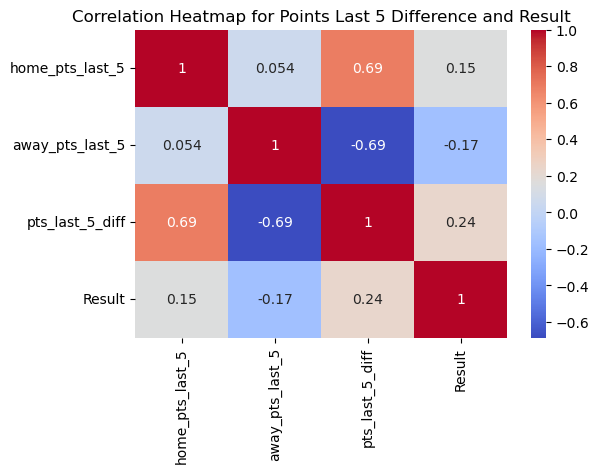

In [449]:
# correlation between pts_last_5_diff and result
plt.figure(figsize=(6, 4))
sns.heatmap(prem_momentum[['home_pts_last_5', 'away_pts_last_5','pts_last_5_diff', 'Result']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Points Last 5 Difference and Result')
plt.show()

There is some obvious collinearity in the home/away teams points and the differential, but we can see the differential with 0.24 correlation with the result, and almost equal (0.15 and -0.17) correlation in opposite direction for home and away form.

The last 5 games for both sides, and the differential should be taken forward in the prem dataframe

In [450]:
prem['pts_last_5_diff'] = prem['home_pts_last_5'] - prem['away_pts_last_5']

In [451]:
prem

,date,Venue,Gameweek / 38,home_team,Home Manager,Home GF,Away GF,away_team,Away Manager,Result,...,Away Manager Code,Day,Day Code,home_team_ppg,away_team_ppg,home_ppg_season,home_pts_last_5,away_ppg_season,away_pts_last_5,pts_last_5_diff
0,2008-08-17,Old Trafford,1,Manchester United,Sir Alex Ferguson,1,1,Newcastle United,Kevin Keegan,0,...,39,Sunday,3,2.08,1.17,0.000,0,0.000,0,0
1,2008-08-16,Emirates Stadium,1,Arsenal,Arsène Wenger,1,0,West Bromwich Albion,Tony Mowbray,1,...,87,Saturday,2,1.92,1.12,0.000,0,0.000,0,0
2,2008-08-16,Stadium of Light,1,Sunderland,Roy Keane,0,1,Liverpool,Rafael Benítez,-1,...,64,Saturday,2,1.07,1.73,0.000,0,0.000,0,0
3,2008-08-16,Upton Park,1,West Ham United,Alan Curbishley,2,1,Wigan Athletic,Steve Bruce,1,...,79,Saturday,2,1.18,1.06,0.000,0,0.000,0,0
4,2008-08-17,Villa Park,1,Aston Villa,Martin O'Neill,4,2,Manchester City,Mark Hughes,1,...,45,Sunday,3,1.14,1.93,0.000,0,0.000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,2015-10-17,St Mary's Stadium,9,Southampton,Ronald Koeman,2,2,Leicester City,Claudio Ranieri,0,...,15,Saturday,2,1.45,1.61,1.500,10,1.875,8,2
3036,2015-10-19,Swansea.com Stadium,9,Swansea City,Garry Monk,0,1,Stoke City,Mark Hughes,-1,...,45,Monday,1,1.25,1.25,1.250,5,1.125,7,-2
3037,2015-10-17,White Hart Lane,9,Tottenham Hotspur,Mauricio Pochettino,0,0,Liverpool,Jürgen Klopp,0,...,35,Saturday,2,1.73,1.73,1.625,11,1.500,5,6
3038,2015-10-17,Vicarage Road,9,Watford,Quique Sánchez Flores,0,3,Arsenal,Arsène Wenger,-1,...,7,Saturday,2,1.18,1.92,1.250,7,2.000,12,-5


What about the ppg_season? Does this have a correlation with the result? Remember in each record, it should be a value of the previous results, not the one in the same record

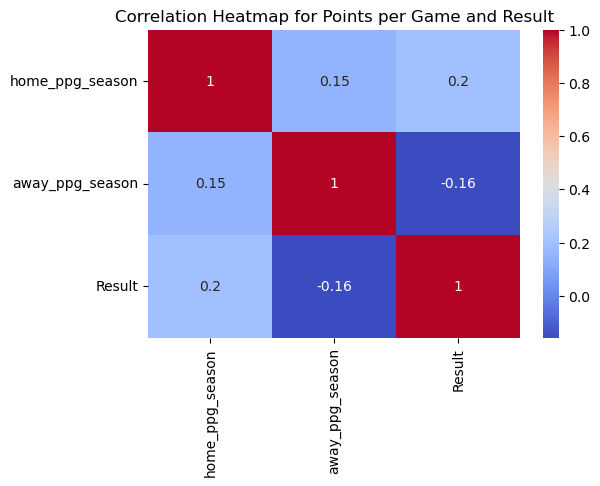

In [452]:
# plot a heatmap of home_ppg_season and away_ppg_season with result
plt.figure(figsize=(6, 4))
sns.heatmap(prem[['home_ppg_season', 'away_ppg_season', 'Result']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap for Points per Game and Result')
plt.show()

home points per game has 0.2 correlation and away_ppg_season has a negative correlation. Because these are somewhat zero sum in nature, the correlations may be cancelling each other out somewhat. But they are clearly somewhat correlated with the result so they ought to stay

## HTML of the match stats columns

In [453]:
prem['goal'].iloc[0]

'<goal><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>406</event_incident_typefk><elapsed>22</elapsed><player2>38807</player2><subtype>header</subtype><player1>37799</player1><sortorder>5</sortorder><team>10261</team><id>378998</id><n>295</n><type>goal</type><goal_type>n</goal_type></value><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>393</event_incident_typefk><elapsed>24</elapsed><player2>24154</player2><subtype>shot</subtype><player1>24148</player1><sortorder>4</sortorder><team>10260</team><id>379019</id><n>298</n><type>goal</type><goal_type>n</goal_type></value></goal>'

In [454]:
# check the record with id column 4766 in the goal column - a 0-0 draw
prem[prem['id'] == 4766]['goal']

3037    <goal />
Name: goal, dtype: object

In [455]:
# check where it's a 1-0 win just one entry - the last entry in the data
prem['goal'].iloc[-1]

'<goal><value><comment>n</comment><stats><goals>1</goals><shoton>1</shoton></stats><event_incident_typefk>649</event_incident_typefk><coordinates><value>21</value><value>2</value></coordinates><elapsed>54</elapsed><subtype>tap_in</subtype><player1>239807</player1><sortorder>4</sortorder><team>8659</team><id>4910256</id><n>559</n><type>goal</type><goal_type>n</goal_type></value></goal>'

It's very hard to read without seeing the nesting. We can use BeautifulSoup to parse this and see what is actually in here, is it anything more detailed than what we see in the goals scored column already?

In [456]:
from bs4 import BeautifulSoup

# prettify the HTML content from a dataframe
def prettify_column(col):
    soup = BeautifulSoup(col, 'html.parser')
    return soup.prettify()

# Applying the function to the goal column
prem['goal_parsed'] = prem['goal'].apply(prettify_column)

# Now, you can print an example entry to see the formatted HTML
print(prem['goal_parsed'].iloc[0])


<goal>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   406
  </event_incident_typefk>
  <elapsed>
   22
  </elapsed>
  <player2>
   38807
  </player2>
  <subtype>
   header
  </subtype>
  <player1>
   37799
  </player1>
  <sortorder>
   5
  </sortorder>
  <team>
   10261
  </team>
  <id>
   378998
  </id>
  <n>
   295
  </n>
  <type>
   goal
  </type>
  <goal_type>
   n
  </goal_type>
 </value>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   393
  </event_incident_typefk>
  <elapsed>
   24
  </elapsed>
  <player2>
   24154
  </player2>
  <subtype>
   shot
  </subtype>
  <player1>
   24148
  </player1>
  <sortorder>
   4
  </sortorder>
  <team>
   10260
  </team>
  <id>
   379019
  </id>
  <n>
   298
  </n>
  <type>
   goal
  </type>
  <goal_type>
   n
  </goal_type>
 </value>
</goal>



In [457]:
print(prem['goal_parsed'].iloc[-1])

<goal>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   649
  </event_incident_typefk>
  <coordinates>
   <value>
    21
   </value>
   <value>
    2
   </value>
  </coordinates>
  <elapsed>
   54
  </elapsed>
  <subtype>
   tap_in
  </subtype>
  <player1>
   239807
  </player1>
  <sortorder>
   4
  </sortorder>
  <team>
   8659
  </team>
  <id>
   4910256
  </id>
  <n>
   559
  </n>
  <type>
   goal
  </type>
  <goal_type>
   n
  </goal_type>
 </value>
</goal>



### goal column contains:
- a < goal /> tag if there are no goals

- a value tag for every goal
    - within this value tag, there is a comment tag which has mostly 'n' but also other letters. I don't know the meaning of it yet
    - elapsed, which may be the minute of the game it was scored,
    - **goal subtype** including header, tap-in, good data here!
    - **coordinates** which must be X and Y, e.g. the tap-in has coordinates value 21, 2 (2 yards out from the goal?)
    - team id
    - id which I assume is a goal_id?

I want to extract:
- goal subtype and see what types they have recorded
- comment, to see if it can be entirely ignored if it's just 'n'
- later on, we will get elapsed, assuming this is time the goal was scored

In [458]:
# Function to extract <comment> and <subtype> values, with a check for <value> tags
def extract_comment_and_subtype(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Check if there is a <goal> tag and if it contains <value> tags
    goal_tag = soup.find('goal')
    if not goal_tag or not goal_tag.find_all('value'):
        return [], []  # Return empty lists if <goal> or <value> is not found
    
    # Extract all <comment> and <subtype> values within each <value> tag
    comments = [value_tag.find('comment').get_text() for value_tag in goal_tag.find_all('value') if value_tag.find('comment')]
    subtypes = [value_tag.find('subtype').get_text() for value_tag in goal_tag.find_all('value') if value_tag.find('subtype')]
    
    return comments, subtypes

# Apply the function to extract <comment> and <subtype> values from the 'goal' column
prem['goal_comments'], prem['goal_subtypes'] = zip(*prem['goal'].apply(extract_comment_and_subtype))

# Flatten the lists and get unique values
unique_comments = set([comment for sublist in prem['goal_comments'] for comment in sublist])
unique_subtypes = set([subtype for sublist in prem['goal_subtypes'] for subtype in sublist])

# Print the unique comments and subtypes
print("Unique Comments:", unique_comments)
print("Unique Subtypes:", unique_subtypes)


Unique Comments: {'rp', 'npm', 'n', 'dg', 'p', 'o', 'psm'}
Unique Subtypes: {'crossbar', 'post', 'volley', 'direct_freekick', 'indirect freekick', 'loose_ball', 'header', 'bicycle_kick', 'backheel', 'deflected', 'saved', 'shot', 'missed', 'lob', 'distance', 'saved_back_into_play', 'tap_in'}


We can see a lot of different subtypes including 'saved' or 'missed' which doesn't make sense. Let's see which fields have those

In [459]:
# check goal_subtypes for entries containing 'missed' and 'saved'
missed = prem[prem['goal_subtypes'].apply(lambda x: 'missed' in x or 'saved' in x)]

missed

,date,Venue,Gameweek / 38,home_team,Home Manager,Home GF,Away GF,away_team,Away Manager,Result,...,home_team_ppg,away_team_ppg,home_ppg_season,home_pts_last_5,away_ppg_season,away_pts_last_5,pts_last_5_diff,goal_parsed,goal_comments,goal_subtypes
41,2008-11-15,Emirates Stadium,13,Arsenal,Arsène Wenger,0,2,Aston Villa,Martin O'Neill,-1,...,1.92,1.14,1.916667,10,1.666667,7,3,<goal>\n <value>\n <comment>\n npm\n </com...,"[npm, o, n]","[saved, shot]"
158,2009-01-28,Ewood Park,23,Blackburn Rovers,Sam Allardyce,2,2,Bolton Wanderers,Gary Megson,0,...,1.09,1.07,1.090909,11,1.045455,3,8,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n, npm, n]","[shot, shot, shot, saved, shot]"
223,2008-08-30,Upton Park,3,West Ham United,Alan Curbishley,4,1,Blackburn Rovers,Paul Ince,1,...,1.18,1.09,1.500000,3,2.000000,4,-1,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, o, n, dg, npm, n, n]","[header, shot, shot, saved, shot, shot]"
225,2008-08-30,Goodison Park,3,Everton,David Moyes,0,3,Portsmouth,Harry Redknapp,-1,...,1.52,0.91,1.500000,3,0.000000,0,3,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, npm, n]","[shot, shot, saved, distance]"
232,2009-03-21,St James' Park,30,Newcastle United,Chris Hughton,1,3,Arsenal,Arsène Wenger,-1,...,1.17,1.92,1.000000,5,1.793103,9,-4,<goal>\n <value>\n <comment>\n npm\n </com...,"[npm, n, n, n, n]","[saved, header, loose_ball, shot, shot]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2752,2015-12-26,Stamford Bridge,18,Chelsea,Guus Hiddink,2,2,Watford,Quique Sánchez Flores,0,...,1.97,1.18,1.058824,7,1.647059,12,-5,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, p, o, n, npm]","[volley, shot, missed]"
2754,2015-12-26,Etihad Stadium,18,Manchester City,Manuel Pellegrini,4,1,Sunderland,Sam Allardyce,1,...,1.93,1.07,1.882353,6,0.705882,6,0,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n, n, n, npm]","[header, distance, header, shot, shot, missed]"
2888,2015-08-23,The Hawthorns,3,West Bromwich Albion,Tony Pulis,2,3,Chelsea,José Mourinho,-1,...,1.12,1.97,0.500000,1,0.500000,1,0,<goal>\n <value>\n <comment>\n npm\n </com...,"[npm, n, n, n, n, n]","[saved, shot, tap_in, volley, shot, header]"
2939,2016-04-16,The Hawthorns,34,West Bromwich Albion,Tony Pulis,0,1,Watford,Quique Sánchez Flores,-1,...,1.12,1.18,1.212121,4,1.151515,1,3,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, npm, npm]","[volley, saved_back_into_play, saved]"


I was manually trying to compare the sum of Home GF + Away GF with the number of goal subtypes and there are some inconsistencies where saved and missed are involved. We can:

- spot check some records with those and see if goal has a value of 1 or 0
- run a pandas query for these where the sum of goals should add up to the length of the goal_subtypes list

In [460]:
print(missed['goal_parsed'].iloc[-1])

<goal>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   393
  </event_incident_typefk>
  <coordinates>
   <value>
    23
   </value>
   <value>
    6
   </value>
  </coordinates>
  <elapsed>
   5
  </elapsed>
  <player2>
   103419
  </player2>
  <subtype>
   shot
  </subtype>
  <player1>
   286119
  </player1>
  <sortorder>
   6
  </sortorder>
  <team>
   8197
  </team>
  <id>
   5581005
  </id>
  <n>
   301
  </n>
  <type>
   goal
  </type>
  <goal_type>
   n
  </goal_type>
 </value>
 <value>
  <comment>
   n
  </comment>
  <stats>
   <goals>
    1
   </goals>
   <shoton>
    1
   </shoton>
  </stats>
  <event_incident_typefk>
   80
  </event_incident_typefk>
  <coordinates>
   <value>
    25
   </value>
   <value>
    7
   </value>
  </coordinates>
  <elapsed>
   33
  </elapsed>
  <subtype>
   shot
  </subtype>
  <player1>
   103419
  </player1>
  <sortorder>
   2
  </sortorder>
  <tea

As of V3 (01 Dec 2024) Paused for now.

## SQL Queries for Team and individual player attributes

SQL is going to be a lot easier to bring in information like how many goals on average did a given team score this season, team OVR rating for the season, player OVR ratings etc...

Before going for types of goals, possession etc etc I should be looking at high level team information, which is definitely going to impact the predictive power of the model.

The SQL query to be built is:
- Overall Rating From Player_Attributes, join their name
    - we need code to match the player's OVR ability to the year the match takes place e.g. 2015 match takes the player's 2015 OVR
- Joined by their player_api_id to Match table, which has player ID

In [461]:
# import the database file
with sqlite3.connect('/Users/thomasdoherty/Desktop/football-project/football-data/database.sqlite') as conn:
    # countries = pd.read_sql_query("SELECT England FROM Country", conn) # we don't need it for now, other than country id 1729

    matches = pd.read_sql_query("SELECT * FROM Match WHERE country_id IS 1729", conn)

    # leagues = pd.read_sql_query("SELECT * FROM League", conn) - we don't need this right now

    team = pd.read_sql_query("SELECT * FROM Team", conn)

    team_attr = pd.read_sql_query("""
                                  SELECT Team.team_api_id, team_long_name, date, buildUpPlaySpeed, buildUpPlayPassing, chanceCreationPassing, chanceCreationCrossing, chanceCreationShooting, defencePressure, defenceAggression
                                  FROM Team_Attributes
                                  INNER JOIN Team ON Team.team_api_id = Team_Attributes.team_api_id
                                  """, conn)

    player_attr = pd.read_sql_query("""
                                    SELECT Player.player_api_id, player_name, date, overall_rating 
                                    FROM Player_Attributes 
                                    INNER JOIN Player ON Player.player_api_id = Player_Attributes.player_api_id
                                    """, conn)

    player = pd.read_sql_query("SELECT * FROM Player", conn)

## Preparing the player_attribute table

- Better teams win more matches
- a more static measure of ability as these ratings only move slightly unless it is very young player. May be more a reflection of longer term prior performance
- We can take the average rating of the team's starting 11

The goal is to have the player id, their overall rating and the year in which it was assigned. This information will let the player easily be joined in to the matches table with their overall rating which is close to the time of the match in question.
    - We can then later create an average OVR rating of the team in the starting 11.

There are many instances of the same player having a new rating multiple times a year, so we will take an average of the overall rating that was given in each rating across each year.

In [462]:
player_attr[player_attr['player_api_id'] == 23021].head() # before preparation

,player_api_id,player_name,date,overall_rating
21897,23021,Boaz Myhill,2016-02-11 00:00:00,72.0
21898,23021,Boaz Myhill,2015-09-21 00:00:00,72.0
21899,23021,Boaz Myhill,2014-05-16 00:00:00,72.0
21900,23021,Boaz Myhill,2014-03-14 00:00:00,72.0
21901,23021,Boaz Myhill,2013-09-20 00:00:00,72.0


In [463]:
# cast date to datetime
player_attr['date'] = pd.to_datetime(player_attr['date'])

# extract just the year from the date
player_attr['date'] = player_attr['date'].dt.year

In [464]:
# now average the overall_rating for each player for each year, group by player_api_id and date
player_attr = player_attr.groupby(['player_api_id', 'player_name', 'date'])['overall_rating'].mean().reset_index()

# round the overall_rating to 1 decimal place
player_attr['overall_rating'] = player_attr['overall_rating'].round(1)

In [465]:
player_attr.dtypes

player_api_id       int64
player_name        object
date                int32
overall_rating    float64
dtype: object

In [466]:
player_attr.sample(5) # after preparation

,player_api_id,player_name,date,overall_rating
65838,299886,Kevin Lasagna,2007,55.0
19508,34485,Franco Costanzo,2015,64.2
63322,265275,Naldo,2011,69.0
11095,27364,Marc-Andre Kruska,2015,64.7
46254,128045,Luis Alberto,2010,70.5


### Preparing the team_attribute columns

The goal is to have the team statistics for that year that the match took place. We may only bring in the team name but extra columns related to the style of play will be brought in too. 

I dropped buildUpPlayDribbling / chanceCreationDribbling because it only began getting recorded in 2014 - near the end of the data

Other notes:
- It looks like all teams get one annual rating for team_attr, so all we need to process is extract the year

- Spot check West Ham (long ball) vs Arsenal (short possession based) - it appears the **larger values for passing indicate longer passing distance**, e.g. long-ball teams have a larger buildUpPlaySpeed and buildUpPlayPassing

In [467]:
#teams[teams['team_api_id'] == 8654]

In [468]:
team_attr.sample(5) # before processing

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
1118,9853,AS Saint-Étienne,2010-02-22 00:00:00,65,65,55,60,60,30,30
411,4087,Évian Thonon Gaillard FC,2012-02-22 00:00:00,53,44,52,52,64,47,56
1356,10238,Vitória Setúbal,2013-09-20 00:00:00,56,42,54,52,52,37,37
215,9788,Borussia Mönchengladbach,2010-02-22 00:00:00,65,45,50,70,65,55,40
229,8678,Bournemouth,2015-09-10 00:00:00,47,47,49,45,47,48,50


In [469]:
team_attr.columns

Index(['team_api_id', 'team_long_name', 'date', 'buildUpPlaySpeed',
       'buildUpPlayPassing', 'chanceCreationPassing', 'chanceCreationCrossing',
       'chanceCreationShooting', 'defencePressure', 'defenceAggression'],
      dtype='object')

In [470]:
# spot check a team to see how this changes - West Ham United and Arsenal
team_attr[team_attr['team_long_name'].isin(['West Ham United', 'Arsenal'])]

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
70,9825,Arsenal,2010-02-22 00:00:00,66,30,30,45,35,30,40
71,9825,Arsenal,2011-02-22 00:00:00,75,40,40,45,65,50,40
72,9825,Arsenal,2012-02-22 00:00:00,25,32,41,34,30,57,57
73,9825,Arsenal,2013-09-20 00:00:00,30,29,41,55,39,64,54
74,9825,Arsenal,2014-09-19 00:00:00,59,26,28,55,64,51,44
75,9825,Arsenal,2015-09-10 00:00:00,59,30,28,44,46,51,44
1384,8654,West Ham United,2010-02-22 00:00:00,58,30,31,70,50,30,70
1385,8654,West Ham United,2011-02-22 00:00:00,35,35,30,45,45,45,45
1386,8654,West Ham United,2012-02-22 00:00:00,63,64,44,60,55,30,34
1387,8654,West Ham United,2013-09-20 00:00:00,72,73,61,74,32,30,37


In [471]:
# cast date to datetime
team_attr['date'] = pd.to_datetime(team_attr['date'])

# extract just the year from the date
team_attr['date'] = team_attr['date'].dt.year

In [472]:
team_attr.sample(5)

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
716,8197,Leicester City,2014,63,48,47,62,69,58,62
1,9930,FC Aarau,2014,52,56,54,63,64,47,44
735,9989,Lierse SK,2015,69,58,56,52,61,38,49
1011,8640,PSV,2014,67,40,53,53,55,50,62
1027,8548,Rangers,2013,55,45,38,52,60,48,48


### Big SQL Query - team match results in England

I want to create a df which has aggregated the win/loss/draw and avg goals scored for all teams in England (where the matches recorded are all from the Premier League).

We will use CASE logic to match the team id only when it is specifically home or away to count the goals scored and the goals per match
We can make it more granular later e.g. home wins/losses, away wins/losses if we want.

We can also adjust the below code to add other leagues for if we wanted to check which teams are most dominant in their leagues.

In [473]:
sql_query = """
SELECT
    Team.team_api_id,
    Team.team_long_name AS name,
    League.name AS league,
    COUNT(Match.id) AS total_matches,
    SUM(CASE
                WHEN Match.home_team_api_id = Team.team_api_id THEN Match.home_team_goal
                WHEN Match.away_team_api_id = Team.team_api_id THEN Match.away_team_goal
                ELSE 0
        END) AS total_GF,
    SUM(CASE
                WHEN Match.home_team_api_id = Team.team_api_id THEN Match.away_team_goal
                WHEN Match.away_team_api_id = Team.team_api_id THEN Match.home_team_goal
                ELSE 0
        END) AS total_GA,
    SUM(CASE 
                WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal > Match.away_team_goal THEN 1
                WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal > Match.home_team_goal THEN 1
                ELSE 0 
        END) AS total_wins,
    SUM(CASE
                WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal = Match.away_team_goal THEN 1
                WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal = Match.home_team_goal THEN 1
                ELSE 0
        END) AS total_draws,
    SUM(CASE
                WHEN Match.home_team_api_id = Team.team_api_id AND Match.home_team_goal < Match.away_team_goal THEN 1
                WHEN Match.away_team_api_id = Team.team_api_id AND Match.away_team_goal < Match.home_team_goal THEN 1
                ELSE 0
        END) AS total_losses,
    ROUND(AVG(CASE
                WHEN Match.home_team_api_id = Team.team_api_id THEN Match.home_team_goal
                WHEN Match.away_team_api_id = Team.team_api_id THEN Match.away_team_goal
                ELSE 0
        END), 2) AS avg_GF_per_match,
    ROUND(AVG(CASE
                WHEN Match.home_team_api_id = Team.team_api_id THEN Match.away_team_goal
                WHEN Match.away_team_api_id = Team.team_api_id THEN Match.home_team_goal
                ELSE 0
        END), 2) AS avg_GA_per_match

FROM Team

LEFT JOIN Match ON Team.team_api_id IN (Match.home_team_api_id, Match.away_team_api_id)

JOIN League ON League.id = Match.league_id

WHERE Team.team_api_id IS NOT NULL AND League.id = 1729

GROUP BY Team.team_long_name

ORDER BY total_wins DESC;
"""

In [474]:
# SQL query run

big_stats = pd.read_sql_query(sql_query, conn)

In [475]:
big_stats

,team_api_id,name,league,total_matches,total_GF,total_GA,total_wins,total_draws,total_losses,avg_GF_per_match,avg_GA_per_match
0,10260,Manchester United,England Premier League,304,582,280,192,57,55,1.91,0.92
1,8455,Chelsea,England Premier League,304,583,286,176,70,58,1.92,0.94
2,8456,Manchester City,England Premier League,304,606,307,175,61,68,1.99,1.01
3,9825,Arsenal,England Premier League,304,573,320,170,73,61,1.88,1.05
4,8586,Tottenham Hotspur,England Premier League,304,481,358,151,74,79,1.58,1.18
5,8650,Liverpool,England Premier League,304,531,337,150,76,78,1.75,1.11
6,8668,Everton,England Premier League,304,439,355,121,100,83,1.44,1.17
7,10194,Stoke City,England Premier League,304,322,401,98,86,120,1.06,1.32
8,10252,Aston Villa,England Premier League,304,335,462,86,88,130,1.10,1.52
9,10261,Newcastle United,England Premier League,266,324,422,82,65,119,1.22,1.59


In [476]:
big_stats.dtypes # types look good

team_api_id           int64
name                 object
league               object
total_matches         int64
total_GF              int64
total_GA              int64
total_wins            int64
total_draws           int64
total_losses          int64
avg_GF_per_match    float64
avg_GA_per_match    float64
dtype: object

In [477]:
# close the SQL connection
conn.close()

## Progress Check - SQL and Pandas

We have:

- `player_attr` player overall attribute for every year, which can be summed and averaged in the match data table, with player_api to connect to the team
- `team_attr` team statistics, with team_api_id and the date. If we have issues with nulls, we may want to start with just the 2010 - 2015 or 2016 years as some team attribute data is missing from 2008-2009
- `big_stats` aggregated team results for the 33 teams who have competed in the premier league in this 2008-2016 window
- `prem` which is a modified match table where all of this will be aggregated.

In [478]:
# spot check the team_attr for teams that could be pulled in
team_attr[team_attr['team_long_name'].isin(['Middlesbrough', 'Fulham'])]

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
478,9879,Fulham,2010,60,70,70,70,50,40,35
479,9879,Fulham,2011,50,55,45,55,40,45,35
480,9879,Fulham,2012,48,45,38,62,54,38,38
481,9879,Fulham,2013,52,49,49,56,59,39,39
482,9879,Fulham,2014,52,56,58,41,54,29,28
483,9879,Fulham,2015,52,48,39,54,59,29,30
829,8549,Middlesbrough,2010,70,70,70,70,50,30,70
830,8549,Middlesbrough,2011,66,51,64,64,48,54,44
831,8549,Middlesbrough,2012,60,72,40,56,72,38,42
832,8549,Middlesbrough,2013,60,40,40,56,57,38,42


### Sample Pulse Check for the four dfs

In [479]:
prem.sample(7)

,date,Venue,Gameweek / 38,home_team,Home Manager,Home GF,Away GF,away_team,Away Manager,Result,...,home_team_ppg,away_team_ppg,home_ppg_season,home_pts_last_5,away_ppg_season,away_pts_last_5,pts_last_5_diff,goal_parsed,goal_comments,goal_subtypes
567,2010-02-10,Villa Park,26,Aston Villa,Martin O'Neill,1,1,Manchester United,Sir Alex Ferguson,0,...,1.14,2.08,1.760000,9,2.240000,13,-4,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, o]",[header]
396,2009-10-24,Molineux Stadium,10,Wolverhampton Wanderers,Mick McCarthy,1,1,Aston Villa,Martin O'Neill,0,...,0.90,1.14,0.888889,4,1.777778,10,-6,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, p]",[shot]
2407,2015-01-01,bet365 Stadium,20,Stoke City,Mark Hughes,1,1,Manchester United,Louis van Gaal,0,...,1.25,2.08,1.315789,10,1.894737,11,-1,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n]","[shot, shot]"
755,2009-10-17,Villa Park,9,Aston Villa,Martin O'Neill,2,1,Chelsea,Carlo Ancelotti,1,...,1.14,1.97,1.625000,10,2.625000,12,-2,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n, n]","[distance, header, header]"
1486,2011-09-25,Loftus Road,6,Queens Park Rangers,Neil Warnock,1,1,Aston Villa,Alex McLeish,0,...,0.81,1.14,1.400000,7,1.400000,7,0,<goal>\n <value>\n <comment>\n p\n </comme...,"[p, o]",[]
22,2008-11-01,Goodison Park,11,Everton,David Moyes,1,0,Fulham,Roy Hodgson,1,...,1.52,1.21,1.200000,5,1.100000,5,0,<goal>\n <value>\n <comment>\n n\n </comme...,[n],[header]
535,2010-01-26,Reebok Stadium,23,Bolton Wanderers,Owen Coyle,1,0,Burnley,Brian Laws,1,...,1.07,0.83,0.863636,3,0.954545,2,1,<goal>\n <value>\n <comment>\n n\n </comme...,[n],[shot]


In [480]:
player_attr.sample(7)

,player_api_id,player_name,date,overall_rating
36962,69616,Bartosz Iwan,2015,65.0
52013,166660,Pieter Nys,2008,58.0
14808,30940,Blerim Dzemaili,2009,73.0
14979,30977,Dariusz Dudka,2012,71.0
17711,33468,Stephane Sessegnon,2009,81.5
29818,41103,Olivier Veigneau,2012,67.0
62274,243827,Pelle Jensen,2012,62.0


In [481]:
team_attr.sample(7)

,team_api_id,team_long_name,date,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression
670,8306,UD Las Palmas,2015,48,44,53,42,53,53,39
595,8226,TSG 1899 Hoffenheim,2015,69,53,66,62,59,63,61
598,8667,Hull City,2012,61,48,38,60,54,38,42
1408,10265,Wisła Kraków,2010,40,35,55,35,70,70,70
108,8583,AJ Auxerre,2012,64,49,51,63,50,34,45
737,8639,LOSC Lille,2011,65,65,50,80,50,55,55
215,9788,Borussia Mönchengladbach,2010,65,45,50,70,65,55,40


In [482]:
big_stats.sample(7)

,team_api_id,name,league,total_matches,total_GF,total_GA,total_wins,total_draws,total_losses,avg_GF_per_match,avg_GA_per_match
17,8559,Bolton Wanderers,England Premier League,152,181,253,43,33,76,1.19,1.66
10,8654,West Ham United,England Premier League,266,326,383,80,74,112,1.23,1.44
5,8650,Liverpool,England Premier League,304,531,337,150,76,78,1.75,1.11
22,8667,Hull City,England Premier League,152,144,243,32,41,79,0.95,1.60
0,10260,Manchester United,England Premier League,304,582,280,192,57,55,1.91,0.92
3,9825,Arsenal,England Premier League,304,573,320,170,73,61,1.88,1.05
26,8462,Portsmouth,England Premier League,76,72,123,17,18,41,0.95,1.62


## Combining the dataframes

The goal is:
- In the Prem dataframe, we can replace the home_player_x and away_player_x which are currently just IDs with overall ability values using player_attr
- We will also add in an average OVR for both team's starting 11
    - V2 - added the best player's overall rating
    - Later we can add some other team's statistics
- We may want to add the team's avg GF and GA, but might this be a problem of collinearity with the classification result?
- Then we are set for our target column for the result of the match

In [483]:
prem.sample(5)

,date,Venue,Gameweek / 38,home_team,Home Manager,Home GF,Away GF,away_team,Away Manager,Result,...,home_team_ppg,away_team_ppg,home_ppg_season,home_pts_last_5,away_ppg_season,away_pts_last_5,pts_last_5_diff,goal_parsed,goal_comments,goal_subtypes
942,2011-02-05,Villa Park,26,Aston Villa,Gérard Houllier,2,2,Fulham,Mark Hughes,0,...,1.14,1.21,1.120000,5,1.160000,10,-5,<goal>\n <value>\n <comment>\n o\n </comme...,"[o, n, n, n]","[header, distance, header]"
2125,2013-08-31,Etihad Stadium,3,Manchester City,Manuel Pellegrini,2,0,Hull City,Steve Bruce,1,...,1.93,0.90,1.500000,3,1.500000,3,0,<goal>\n <value>\n <comment>\n n\n </comme...,"[n, n]","[header, direct_freekick]"
249,2009-04-04,MKM Stadium,31,Hull City,Phil Brown,0,0,Portsmouth,Paul Hart,0,...,0.90,0.91,1.100000,4,1.066667,5,-1,<goal>\n</goal>\n,[],[]
541,2010-01-30,DW Stadium,24,Wigan Athletic,Roberto Martínez,0,1,Everton,David Moyes,-1,...,1.06,1.52,1.000000,4,1.391304,11,-7,<goal>\n <value>\n <comment>\n n\n </comme...,[n],[header]
2510,2015-03-21,Villa Park,30,Aston Villa,Tim Sherwood,0,1,Swansea City,Garry Monk,-1,...,1.14,1.25,0.965517,6,1.379310,6,0,<goal>\n <value>\n <comment>\n n\n </comme...,[n],[shot]


In [484]:
prem.columns

Index(['date', 'Venue', 'Gameweek / 38', 'home_team', 'Home Manager',
       'Home GF', 'Away GF', 'away_team', 'Away Manager', 'Result', 'Home Win',
       'p(Home)', 'p(Draw)', 'p(Away)', 'Margin', 'id', 'season', 'Home ID',
       'Away ID', 'home_player_1', 'home_player_2', 'home_player_3',
       'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7',
       'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11',
       'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
       'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8',
       'away_player_9', 'away_player_10', 'away_player_11', 'goal', 'shoton',
       'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession',
       'Venue Code', 'Home Manager Code', 'Away Manager Code', 'Day',
       'Day Code', 'home_team_ppg', 'away_team_ppg', 'home_ppg_season',
       'home_pts_last_5', 'away_ppg_season', 'away_pts_last_5',
       'pts_last_5_diff', 'goal_parsed', 'goa

### Adding Player Ratings and Team statistics to prem df

In [485]:
# Convert the 'date' columns to datetime and extract the year
prem['date'] = pd.to_datetime(prem['date'])
prem['year'] = prem['date'].dt.year

player_attr['date'] = pd.to_datetime(player_attr['date'])
player_attr['year'] = player_attr['date'].dt.year

# Function to merge and find the nearest year if an exact match is not available
def merge_with_nearest_year(prem_df, player_attr_df, player_col, rating_col_prefix):
    # Sort player_attr by player_id and year
    player_attr_df = player_attr_df.sort_values(['player_api_id', 'year'])
    
    # Initialize a list to hold the rating data
    ratings = []

    # Iterate over each row in prem_df
    for _, row in prem_df.iterrows():
        player_id = row[player_col]
        match_year = row['year']

        # Filter player_attr for the current player_id
        player_data = player_attr_df[player_attr_df['player_api_id'] == player_id]

        # Find the closest year if there are any records for the player
        if not player_data.empty:
            closest_year = player_data.iloc[(player_data['year'] - match_year).abs().argsort()[:1]].squeeze()
            ratings.append(closest_year['overall_rating'])
        else:
            ratings.append(None)  # Append None if no data is available

    # Add the ratings to the prem_df
    prem_df[rating_col_prefix] = ratings

# Apply the function for home and away players
for n in range(1, 12):
    merge_with_nearest_year(prem, player_attr, f'home_player_{n}', f'home_player_{n}_rating')
    merge_with_nearest_year(prem, player_attr, f'away_player_{n}', f'away_player_{n}_rating')

# adding the team statistics to the prem df
prem = prem.merge(
    big_stats[['team_api_id', 'total_matches', 'avg_GF_per_match', 'avg_GA_per_match']],
    left_on='Home ID',
    right_on='team_api_id',
    how='left'
).rename(columns={
    'total_matches': 'home_total_matches',
    'avg_GF_per_match': 'home_avg_GF_per_match',
    'avg_GA_per_match': 'home_avg_GA_per_match'
}).drop(columns='team_api_id')

prem = prem.merge(
    big_stats[['team_api_id', 'total_matches', 'avg_GF_per_match', 'avg_GA_per_match']],
    left_on='Away ID',
    right_on='team_api_id',
    how='left'
).rename(columns={
    'total_matches': 'away_total_matches',
    'avg_GF_per_match': 'away_avg_GF_per_match',
    'avg_GA_per_match': 'away_avg_GA_per_match'
}).drop(columns='team_api_id')

In [486]:
prem.sample(10)

,date,Venue,Gameweek / 38,home_team,Home Manager,Home GF,Away GF,away_team,Away Manager,Result,...,home_player_10_rating,away_player_10_rating,home_player_11_rating,away_player_11_rating,home_total_matches,home_avg_GF_per_match,home_avg_GA_per_match,away_total_matches,away_avg_GF_per_match,away_avg_GA_per_match
1243,2011-12-30,Anfield,19,Liverpool,Kenny Dalglish,3,1,Newcastle United,Alan Pardew,1,...,80.0,75.5,62.0,65.0,304,1.75,1.11,266,1.22,1.59
647,2010-04-03,Reebok Stadium,33,Bolton Wanderers,Owen Coyle,0,1,Aston Villa,Martin O'Neill,-1,...,77.5,74.0,82.5,78.0,152,1.19,1.66,304,1.10,1.52
1842,2012-09-17,Goodison Park,4,Everton,David Moyes,2,2,Newcastle United,Alan Pardew,0,...,76.0,67.0,67.0,77.0,304,1.44,1.17,266,1.22,1.59
1176,2011-11-19,Swansea.com Stadium,12,Swansea City,Brendan Rodgers,0,1,Manchester United,Sir Alex Ferguson,-1,...,59.0,91.5,71.0,57.0,190,1.23,1.35,304,1.91,0.92
1333,2012-03-03,Etihad Stadium,27,Manchester City,Roberto Mancini,2,0,Bolton Wanderers,Owen Coyle,1,...,80.0,68.0,78.0,61.0,304,1.99,1.01,152,1.19,1.66
1001,2011-04-02,Upton Park,31,West Ham United,Avram Grant,2,4,Manchester United,Sir Alex Ferguson,-1,...,73.0,78.0,65.0,91.5,266,1.23,1.44,304,1.91,0.92
717,2009-09-12,Fratton Park,5,Portsmouth,Paul Hart,2,3,Bolton Wanderers,Gary Megson,-1,...,69.0,78.5,74.5,77.5,76,0.95,1.62,152,1.19,1.66
2215,2014-05-11,Carrow Road,38,Norwich City,Neil Adams,0,2,Arsenal,Arsène Wenger,-1,...,59.0,85.0,82.5,56.0,152,1.05,1.66,304,1.88,1.05
1155,2011-10-29,Stadium of Light,10,Sunderland,Steve Bruce,2,2,Aston Villa,Alex McLeish,0,...,73.0,75.0,64.0,83.5,304,1.10,1.45,304,1.10,1.52
2617,2014-09-20,Swansea.com Stadium,5,Swansea City,Garry Monk,0,1,Southampton,Ronald Koeman,-1,...,72.0,68.0,56.0,67.0,190,1.23,1.35,152,1.42,1.18


It looks quite good - lots and lots of columns that need shaving somehow, but we got these in!

Let's check if any nulls are there.

In [487]:
# check every column for nulls by the columns with the most first
prem.isnull().sum().sort_values(ascending=False).head(20)

away_player_2_rating     8
away_player_10           8
away_player_10_rating    8
away_player_2            8
home_player_8_rating     7
home_player_2_rating     7
home_player_2            7
away_player_7            7
away_player_5_rating     7
home_player_8            7
away_player_5            7
home_player_10_rating    7
away_player_7_rating     7
home_player_10           7
away_player_9_rating     6
away_player_9            6
home_player_7_rating     5
away_player_11_rating    5
away_player_11           5
home_player_7            5
dtype: int64

We can see from the above that there are a handful of empty/null ratings because there's a null in the player_id column itself. e.g. away 10 and away 2 both have 8 nulls in the id and the rating.

There are onyl single digit number of nulls across over 3,000 games. For completeness, we can just fill the nulls ratings with the average of the respective team e.g. if away 10_rating is null, give him the average rating of the team around him.

In [488]:
# fill the home_player_x and away_player_x rating columns, if null, with the mean of the team's overall_rating
for n in range(1, 12):
    # Calculate the mean of the other players' ratings for the home team, each row
    home_rating_cols = [f'home_player_{i}_rating' for i in range(1, 12) if i != n] # if i != n is to exclude the current player in case the null is here
    prem[f'home_player_{n}_rating'] = prem.apply(
        lambda row: row[home_rating_cols].mean() if pd.isnull(row[f'home_player_{n}_rating']) else row[f'home_player_{n}_rating'],
        axis=1
    ) # for every row, run through the home player ratings and take the mean if the rating is null

    # same for away team
    away_rating_cols = [f'away_player_{i}_rating' for i in range(1, 12) if i != n]
    prem[f'away_player_{n}_rating'] = prem.apply(
        lambda row: row[away_rating_cols].mean() if pd.isnull(row[f'away_player_{n}_rating']) else row[f'away_player_{n}_rating'],
        axis=1
    )

In [489]:
# check for nulls again - only the IDs, not the ratings!
prem.isnull().sum().sort_values(ascending=False).head()

away_player_10    8
away_player_2     8
home_player_10    7
home_player_8     7
away_player_5     7
dtype: int64

In [490]:
prem.sample(6)

,date,Venue,Gameweek / 38,home_team,Home Manager,Home GF,Away GF,away_team,Away Manager,Result,...,home_player_10_rating,away_player_10_rating,home_player_11_rating,away_player_11_rating,home_total_matches,home_avg_GF_per_match,home_avg_GA_per_match,away_total_matches,away_avg_GF_per_match,away_avg_GA_per_match
222,2008-08-31,Stadium of Light,3,Sunderland,Roy Keane,0,3,Manchester City,Mark Hughes,-1,...,81.5,70.0,82.0,81.0,304,1.10,1.45,304,1.99,1.01
2076,2014-02-08,St Mary's Stadium,25,Southampton,Mauricio Pochettino,2,2,Stoke City,Mark Hughes,0,...,44.0,46.0,49.0,77.0,152,1.42,1.18,304,1.06,1.32
666,2010-04-17,Craven Cottage,35,Fulham,Roy Hodgson,0,0,Wolverhampton Wanderers,Mick McCarthy,0,...,77.0,54.5,75.0,75.5,228,1.16,1.40,114,1.04,1.79
1755,2013-03-16,bet365 Stadium,30,Stoke City,Tony Pulis,0,0,West Bromwich Albion,Steve Clarke,0,...,46.0,68.5,77.0,74.0,304,1.06,1.32,266,1.15,1.52
617,2010-03-13,Reebok Stadium,30,Bolton Wanderers,Owen Coyle,4,0,Wigan Athletic,Roberto Martínez,1,...,77.5,59.0,82.5,73.0,152,1.19,1.66,190,1.05,1.68
1460,2011-09-10,Emirates Stadium,4,Arsenal,Arsène Wenger,1,0,Swansea City,Brendan Rodgers,1,...,83.0,71.0,85.5,59.0,304,1.88,1.05,190,1.23,1.35


## Joins and merges complete - Further cleaning & Feature Engineering of the prem dataframe

### Summary so far and plans ahead:

We have created a master `prem` dataframe which has all the matches from 08/09 to 15/16. Columns of value include
- Match data such as:
    - Team IDs, 
    - date of the fixture,
    - match week of 38. Probably not relevant for predicting the result, but maybe for details match stats later.

- Player data for the home and away players such as:
    - Individual player's overall ratings on both teams, that are recent to the match date

- Team data for the home and away team such as:
    - Team's total number of matches in the league in the reference period. 
    - Teams avg goals scored (GF) and goals against (GA) per game in the time window.
    - These might be a complicated one because that's gathering future information if we are predicting a game early on in the time window.
    
- Details match information like shots, types of goal scored, possession, bookings etc etc but these are heavily nested in columns which we need to dig out later.

Now we can clean a number of unneccessary columns and add one important one:
- Create an average 'team' rating for each match. I think this will be the best way to construct a simple model with some predictive power before complicating things with 22 individual player ratings.

- Remove the individual player IDs, match_api_id

- **For now** remove the Round / 38 aka gameweek, home and away_total matches


### Removing currently (MVP) unnecessary columns

In [491]:
prem.columns

Index(['date', 'Venue', 'Gameweek / 38', 'home_team', 'Home Manager',
       'Home GF', 'Away GF', 'away_team', 'Away Manager', 'Result', 'Home Win',
       'p(Home)', 'p(Draw)', 'p(Away)', 'Margin', 'id', 'season', 'Home ID',
       'Away ID', 'home_player_1', 'home_player_2', 'home_player_3',
       'home_player_4', 'home_player_5', 'home_player_6', 'home_player_7',
       'home_player_8', 'home_player_9', 'home_player_10', 'home_player_11',
       'away_player_1', 'away_player_2', 'away_player_3', 'away_player_4',
       'away_player_5', 'away_player_6', 'away_player_7', 'away_player_8',
       'away_player_9', 'away_player_10', 'away_player_11', 'goal', 'shoton',
       'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession',
       'Venue Code', 'Home Manager Code', 'Away Manager Code', 'Day',
       'Day Code', 'home_team_ppg', 'away_team_ppg', 'home_ppg_season',
       'home_pts_last_5', 'away_ppg_season', 'away_pts_last_5',
       'pts_last_5_diff', 'goal_parsed', 'goa

In [492]:
# drop the Gameweek / 38 column, id, home_total_matches, away_total_matches, year
prem = prem.drop(['id', 'home_total_matches', 'away_total_matches', 'year'], axis=1)

# drop the home/away_player_X columns but NOT the ratings
prem = prem.drop(prem.filter(regex='^(home|away)_player_[1-9]$|^(home|away)_player_10$|^(home|away)_player_11$').columns, axis=1)

# remove the match detail columns - goal, shoton, shotoff, foulcommit, card, cross, corner, possession, goal_parsed, goal_comments, goal_subtypes
prem = prem.drop(['goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner', 'possession', 'goal_parsed', 'goal_comments', 'goal_subtypes'], axis=1)

In [493]:
prem.columns

Index(['date', 'Venue', 'Gameweek / 38', 'home_team', 'Home Manager',
       'Home GF', 'Away GF', 'away_team', 'Away Manager', 'Result', 'Home Win',
       'p(Home)', 'p(Draw)', 'p(Away)', 'Margin', 'season', 'Home ID',
       'Away ID', 'Venue Code', 'Home Manager Code', 'Away Manager Code',
       'Day', 'Day Code', 'home_team_ppg', 'away_team_ppg', 'home_ppg_season',
       'home_pts_last_5', 'away_ppg_season', 'away_pts_last_5',
       'pts_last_5_diff', 'home_player_1_rating', 'away_player_1_rating',
       'home_player_2_rating', 'away_player_2_rating', 'home_player_3_rating',
       'away_player_3_rating', 'home_player_4_rating', 'away_player_4_rating',
       'home_player_5_rating', 'away_player_5_rating', 'home_player_6_rating',
       'away_player_6_rating', 'home_player_7_rating', 'away_player_7_rating',
       'home_player_8_rating', 'away_player_8_rating', 'home_player_9_rating',
       'away_player_9_rating', 'home_player_10_rating',
       'away_player_10_rating', 'home

### Creating a home and away team match-day overall rating

In [494]:
# Calculate the average overall rating for the home team players
home_rating_cols = [f'home_player_{n}_rating' for n in range(1, 12)]
prem['home_avg_rating'] = prem[home_rating_cols].mean(axis=1)

# Calculate the average overall rating for the away team players
away_rating_cols = [f'away_player_{n}_rating' for n in range(1, 12)]
prem['away_avg_rating'] = prem[away_rating_cols].mean(axis=1)

In [495]:
prem.columns

Index(['date', 'Venue', 'Gameweek / 38', 'home_team', 'Home Manager',
       'Home GF', 'Away GF', 'away_team', 'Away Manager', 'Result', 'Home Win',
       'p(Home)', 'p(Draw)', 'p(Away)', 'Margin', 'season', 'Home ID',
       'Away ID', 'Venue Code', 'Home Manager Code', 'Away Manager Code',
       'Day', 'Day Code', 'home_team_ppg', 'away_team_ppg', 'home_ppg_season',
       'home_pts_last_5', 'away_ppg_season', 'away_pts_last_5',
       'pts_last_5_diff', 'home_player_1_rating', 'away_player_1_rating',
       'home_player_2_rating', 'away_player_2_rating', 'home_player_3_rating',
       'away_player_3_rating', 'home_player_4_rating', 'away_player_4_rating',
       'home_player_5_rating', 'away_player_5_rating', 'home_player_6_rating',
       'away_player_6_rating', 'home_player_7_rating', 'away_player_7_rating',
       'home_player_8_rating', 'away_player_8_rating', 'home_player_9_rating',
       'away_player_9_rating', 'home_player_10_rating',
       'away_player_10_rating', 'home

the average team ability is important, and so is the best player in the team. 

Create 2 columns: best_home_player and best_away_player ratings - other individual ratings will be dropped for V2 and V3

In [496]:
# add column for best home player rating and best away player rating
prem['best_home_player_rating'] = prem[home_rating_cols].max(axis=1)
prem['best_away_player_rating'] = prem[away_rating_cols].max(axis=1)

In [497]:
prem.sample(10)

,date,Venue,Gameweek / 38,home_team,Home Manager,Home GF,Away GF,away_team,Away Manager,Result,...,home_player_11_rating,away_player_11_rating,home_avg_GF_per_match,home_avg_GA_per_match,away_avg_GF_per_match,away_avg_GA_per_match,home_avg_rating,away_avg_rating,best_home_player_rating,best_away_player_rating
2223,2013-09-14,MKM Stadium,4,Hull City,Steve Bruce,1,1,Cardiff City,Malky Mackay,0,...,59.0,74.0,0.95,1.60,0.84,1.95,66.000000,61.181818,74.5,74.0
1778,2013-04-07,White Hart Lane,32,Tottenham Hotspur,André Villas-Boas,2,2,Everton,David Moyes,0,...,79.0,70.5,1.58,1.18,1.44,1.17,68.590909,71.863636,82.0,80.0
2743,2015-12-19,Old Trafford,17,Manchester United,Louis van Gaal,1,2,Norwich City,Alex Neil,-1,...,91.5,74.0,1.91,0.92,1.05,1.66,67.909091,61.136364,91.5,75.5
1797,2013-04-21,White Hart Lane,34,Tottenham Hotspur,André Villas-Boas,3,1,Manchester City,Roberto Mancini,1,...,79.0,64.0,1.58,1.18,1.99,1.01,69.727273,75.545455,82.0,87.5
2354,2014-12-15,Goodison Park,16,Everton,Roberto Martínez,3,1,Queens Park Rangers,Harry Redknapp,1,...,74.0,56.0,1.44,1.17,1.01,1.75,72.727273,65.727273,80.0,81.0
1916,2013-11-02,St James' Park,10,Newcastle United,Alan Pardew,2,0,Chelsea,José Mourinho,1,...,67.0,87.0,1.22,1.59,1.92,0.94,64.363636,74.681818,77.0,90.5
2056,2014-01-29,Stadium of Light,23,Sunderland,Gus Poyet,1,0,Stoke City,Mark Hughes,1,...,70.0,77.0,1.10,1.45,1.06,1.32,67.772727,63.181818,79.5,79.5
3020,2015-10-04,Emirates Stadium,8,Arsenal,Arsène Wenger,3,0,Manchester United,Louis van Gaal,1,...,74.0,58.0,1.88,1.05,1.91,0.92,71.818182,69.090909,89.0,91.5
1224,2011-12-21,Villa Park,17,Aston Villa,Alex McLeish,1,2,Arsenal,Arsène Wenger,-1,...,74.0,68.5,1.10,1.52,1.88,1.05,72.000000,70.181818,83.0,86.0
2527,2015-04-05,Stadium of Light,31,Sunderland,Dick Advocaat,1,0,Newcastle United,John Carver,1,...,64.0,60.0,1.10,1.45,1.22,1.59,68.863636,62.590909,83.5,75.5


## Simplifying the dataframe

### Drop individual player ratings

In [498]:
# drop the home/away_player_X_rating columns
prem = prem.drop(prem.filter(regex='^(home|away)_player_[1-9]_rating$|^(home|away)_player_10_rating$|^(home|away)_player_11_rating$').columns, axis=1)

Home / Away net goals - this should standardize around 0 for teams that score and concede equally, and negative for 'weak' teams while positive for 'good' teams

In [500]:
# create a new net goals column for both teams: home_avg_GS_per_match - home_avg_GA_per_match and away_avg_GS_per_match - away_avg_GA_per_match
prem['home_net_goals'] = prem['home_avg_GF_per_match'] - prem['home_avg_GA_per_match']
prem['away_net_goals'] = prem['away_avg_GF_per_match'] - prem['away_avg_GA_per_match']

In [501]:
# drop the home_avg_GS_per_match, home_avg_GA_per_match, away_avg_GS_per_match, away_avg_GA_per_match
prem = prem.drop(['home_avg_GF_per_match', 'home_avg_GA_per_match', 'away_avg_GF_per_match', 'away_avg_GA_per_match'], axis=1)

In [502]:
prem.columns

Index(['date', 'Venue', 'Gameweek / 38', 'home_team', 'Home Manager',
       'Home GF', 'Away GF', 'away_team', 'Away Manager', 'Result', 'Home Win',
       'p(Home)', 'p(Draw)', 'p(Away)', 'Margin', 'season', 'Home ID',
       'Away ID', 'Venue Code', 'Home Manager Code', 'Away Manager Code',
       'Day', 'Day Code', 'home_team_ppg', 'away_team_ppg', 'home_ppg_season',
       'home_pts_last_5', 'away_ppg_season', 'away_pts_last_5',
       'pts_last_5_diff', 'home_avg_rating', 'away_avg_rating',
       'best_home_player_rating', 'best_away_player_rating', 'home_net_goals',
       'away_net_goals'],
      dtype='object')

In [504]:
prem.sample(3)

,date,Venue,Gameweek / 38,home_team,Home Manager,Home GF,Away GF,away_team,Away Manager,Result,...,home_pts_last_5,away_ppg_season,away_pts_last_5,pts_last_5_diff,home_avg_rating,away_avg_rating,best_home_player_rating,best_away_player_rating,home_net_goals,away_net_goals
2788,2016-01-02,The Hawthorns,20,West Bromwich Albion,Tony Pulis,2,1,Stoke City,Mark Hughes,1,...,5,1.526316,10,-5,65.772727,62.818182,77.0,76.0,-0.37,-0.26
1289,2012-01-21,Molineux Stadium,22,Wolverhampton Wanderers,Mick McCarthy,2,3,Aston Villa,Alex McLeish,-1,...,4,1.142857,5,-1,61.636364,74.318182,72.0,85.0,-0.75,-0.42
2252,2013-10-05,MKM Stadium,7,Hull City,Steve Bruce,0,0,Aston Villa,Paul Lambert,0,...,10,1.500000,6,4,67.272727,62.090909,74.5,77.0,-0.65,-0.42


In [506]:
# Use the sample above to round columns to appropriate decimal places

# Round points per game columns to 2 decimal places
prem['home_team_ppg'] = prem['home_team_ppg'].round(2)
prem['away_team_ppg'] = prem['away_team_ppg'].round(2)
prem['home_ppg_season'] = prem['home_ppg_season'].round(2)
prem['away_ppg_season'] = prem['away_ppg_season'].round(2)

# round average ratings to 1 decimal place
prem['home_avg_rating'] = prem['home_avg_rating'].round(1)
prem['away_avg_rating'] = prem['away_avg_rating'].round(1)


In [507]:
prem.sample(3)

,date,Venue,Gameweek / 38,home_team,Home Manager,Home GF,Away GF,away_team,Away Manager,Result,...,home_pts_last_5,away_ppg_season,away_pts_last_5,pts_last_5_diff,home_avg_rating,away_avg_rating,best_home_player_rating,best_away_player_rating,home_net_goals,away_net_goals
2902,2016-03-19,Goodison Park,31,Everton,Roberto Martínez,0,2,Arsenal,Arsène Wenger,-1,...,3,1.83,7,-4,67.2,64.1,81.5,73.0,0.27,0.83
960,2011-04-20,White Hart Lane,28,Tottenham Hotspur,Harry Redknapp,3,3,Arsenal,Arsène Wenger,0,...,11,2.07,13,-2,75.5,73.6,86.0,85.5,0.40,0.83
1972,2013-12-14,Stamford Bridge,16,Chelsea,José Mourinho,2,1,Crystal Palace,Tony Pulis,1,...,10,0.87,10,0,74.2,63.2,90.5,80.0,0.98,-0.28


## Correlation tests

In [ ]:
prem.sample(5)

,home_team,home_team_ppg,home_ppg_season,home_pts_last_5,home_avg_rating,best_home_player_rating,home_net_goals,away_team,away_team_ppg,away_ppg_season,away_pts_last_5,away_avg_rating,best_away_player_rating,away_net_goals,Result,p(Home),p(Draw),p(Away)
841,Tottenham Hotspur,1.73,1.62,11,73.2,83.5,0.40,Chelsea,1.97,1.88,5,80.2,90.5,0.98,0,0.457,0.258,0.285
379,Chelsea,1.97,2.50,13,83.5,90.5,0.98,Liverpool,1.73,2.50,13,81.5,88.5,0.64,-1,0.457,0.258,0.285
978,Bolton Wanderers,1.07,1.32,7,72.0,82.5,-0.47,Aston Villa,1.14,1.18,8,69.0,83.5,-0.42,1,0.457,0.258,0.285
470,Arsenal,1.92,2.06,7,76.4,85.0,0.83,Hull City,0.90,1.00,6,68.0,79.5,-0.65,1,0.457,0.258,0.285
266,Portsmouth,0.91,1.06,6,76.4,80.0,-0.67,Bolton Wanderers,1.07,1.16,4,73.6,82.5,-0.47,1,0.457,0.258,0.285


Preparing the data by scaling it below

#### Notes for V2 run 
for v2 I will take ppg_season, not the other ppg (home_team_ppg or away_team_ppg, these are the multi year averages)

Below, I can see the **best player rating correlates better with Result than the average team rating, so home/away_avg_rating will be removed from this v2 run**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Example: Select relevant columns for collinearity analysis
features = ['home_net_goals', 'away_net_goals', 'home_ppg_season', 'away_ppg_season','home_pts_last_5', 'away_pts_last_5', 'best_home_player_rating', 'best_away_player_rating', 'p(Home)', 'p(Draw)', 'p(Away)']
X = prem[features]  # Exclude the 'Result' column (that's the target variable)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

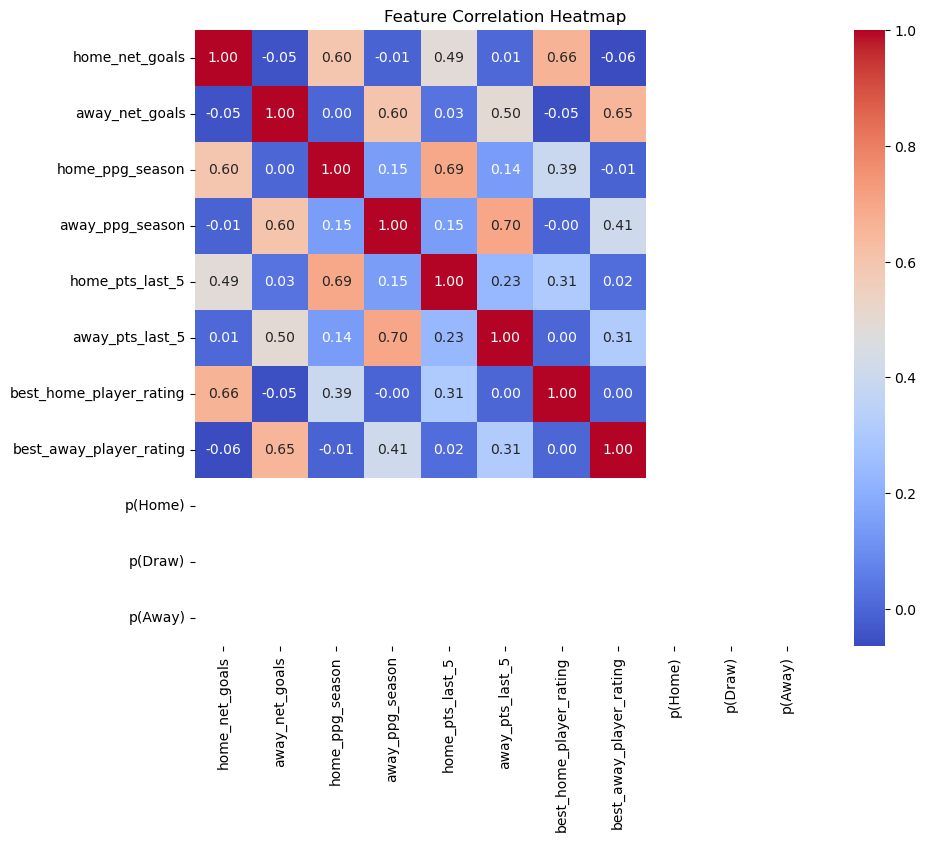

In [ ]:
# Calculate correlation matrix
correlation_matrix = pd.DataFrame(X_scaled, columns=features).corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

Notes:
- I can see that the best player rating correlates more with the net_goals than the average team rating for home and away.
- home_pts_last_5 correlates very strongly with ppg_season suggesting that very recent form tends not to deviate much from season long form (dramatic turnarounds/flops are rare)

### Why does home_avg_rating correlate with away_avg_rating? - Structural Symmetry in team data

There are some sensible correlations here like away average rating and away net goals being 0.45 correlated.

But notice that the home net goals and home avg rating is also 0.45 - is it a coincidence?

What about the fact that home_avg_rating and away_avg_rating are 0.35 correlated? On face value, this is saying that better teams means are more likely to play each other. This doesn't make sense in the Premier League format where every team must play every other team twice every season... **home and away.**

In this data, every team appears as the home team and the away team an equal number of times (every team plays 19 home games and 19 away games every season) so there is a natural symmetry in the away and home team data at the highest level.

So we should be mindful of symmetry in this dataset, this is a correlation but the rating of the away team and the home team are conceptually distinct.

## PCA examining importance of columns

In [ ]:
# Perform PCA
pca = PCA(n_components=len(features))  # Use all components initially
pca.fit(X_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

# Loadings (feature contributions to components)
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(len(features))], index=features)

# Display loadings
print(loadings)

Explained Variance Ratio: [0.3445326  0.30938553 0.11425678 0.08558323 0.04502204 0.03866548
 0.03353777 0.02901657 0.         0.         0.        ]
                              PC1       PC2       PC3       PC4       PC5  \
home_net_goals           0.315573 -0.435648  0.262789 -0.147521  0.339647   
away_net_goals           0.354664  0.397509  0.257963  0.152085  0.352185   
home_ppg_season          0.382614 -0.357833 -0.233039  0.308378  0.349709   
away_ppg_season          0.411945  0.325994 -0.188521 -0.326034  0.313875   
home_pts_last_5          0.382406 -0.299498 -0.372290  0.395041 -0.414908   
away_pts_last_5          0.398441  0.276505 -0.359567 -0.417193 -0.386142   
best_home_player_rating  0.261925 -0.367181  0.516341 -0.440818 -0.337454   
best_away_player_rating  0.291446  0.341914  0.489952  0.478837 -0.323516   
p(Home)                  0.000000  0.000000 -0.000000 -0.000000  0.000000   
p(Draw)                  0.000000  0.000000 -0.000000 -0.000000  0.000000   
p(A

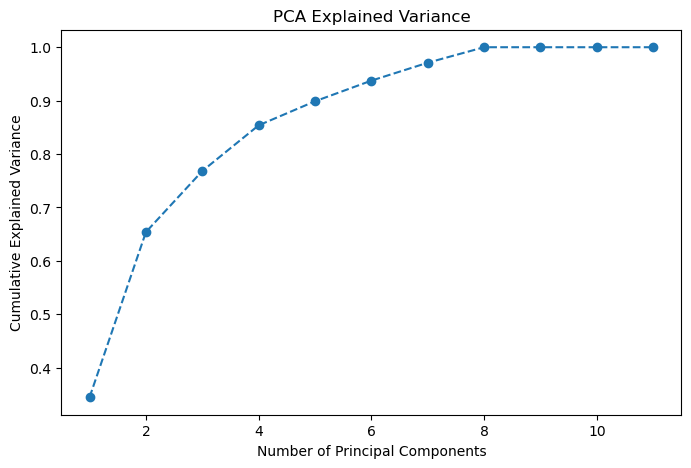

In [ ]:
# visualizing the PCA results

# Cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(features) + 1), explained_variance.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

### Analysis of PCA Results / Loadings

#### (V2)

The key piece to PCA in V2 is even after engineering new features like points per game this season so far, points accrued in last 5 games... The principal component 2 still has home and away positive and negative respectively, which tells me that the differential between the to teams metrics is the important feature to carry forward.

We can take four PCs forward in  v2

#### (V1)

1. PC1 is very highly loaded onto the home and away team average ratings, almost identially so, as well to the home and away goals - again, almost identically so.
    - This is because of the structural symmetry identified before. PC1 captures 40% (0.395) of the variance in the feature set, which is heavily influenced by the team's rating, and it applies equally to the home and away team.

2. PC2 is symmetrical but is now distinguishing between the home and the away teams. PC2 captures 35% (0.352) of the data variance. Essentially, the home vs away team comparison.
    - We are being told that the rating and net goals of a team, *as it moves in the other direction of the opposition*, captures a lot of variance

3. PC3 is dominated by net goals, suggesting the performance specific variance that doesn't depend on the team's average rating

**With 3 principal components we have explained around 91% of the variance in the data set.** The prior probabilities p(home), p(away) and p(draw) are disregartded by PCA because they're constants that do not provide any variance to the dataset, but they are still important to the classification.

**IMPORTANT:** This is not explaining the variance in Results, it's variance in the dataset minus the results because PCA did not see the Result column. This is capturing overall variance in this data set. However, high variance features tend to be predictive and PCA has identified these, which we could use in our model or take learnings from the loadings of PC1, 2 and 3 and engineer our own.

The Principal Components here are representations of the original data columns and their variance. If we include them, we don't need to keep the home_avg_rating, home_net_goals and away equivalents. This *might* make the model perform better in classification tasks, but we will lose interpretability. There is also the risk that PCA is prioritizing variance in features that aren't predictive of the result, which is a lose-lose: less interpretability, and a weaker model.

Ideally we have both interpretability and good model performance and we can keep the interpretability by feature engineering information that PCA revealed was important, such as the differential between net goals of the home and away team, and the differential of the team's overall ratings. 

If the performance here is poor, we can fall back on PC1, 2 and 3 and make another model. PCA is still valuable for supervised learning because it has guided our feature engineering here, and has allowed us to go from four features (home/away_avg_rating/net_goals) to two features (**rating_diff and net_goals_diff**).

#### **The advantage of this feature engineering is that the zero-sum nature of matches allow a natural mean/equality of 0 and any positive values indicate favour for the home team, and any negative indivates away team favour.**



## Next Steps for building the model

1. Manual Run with feature engineering differential columns (and prior probabilities), using a logistic regression algorithm. We will create these features and save the csv for model building in another workbook.

2. PCA run with PC1-3 and prior probabilities using another algorithm (possibly random forest?). We'll add the PCA columns and save a separate csv for this separate model building in another workbook.

### 1. Manual Run - saved and model built on *logistic_reg_prem.ipynb*

In [ ]:
# v2 with more features - make the differential columns for each feature
prem['ppg_diff'] = prem['home_team_ppg'] - prem['away_team_ppg']
prem['ppg_season_diff'] = prem['home_ppg_season'] - prem['away_ppg_season']
prem['pts_last_5_diff'] = prem['home_pts_last_5'] - prem['away_pts_last_5']
prem['avg_rating_diff'] = prem['home_avg_rating'] - prem['away_avg_rating']
prem['best_player_diff'] = prem['best_home_player_rating'] - prem['best_away_player_rating']
prem['net_goals_diff'] = prem['home_net_goals'] - prem['away_net_goals']

prem.sample(5)

,home_team,home_team_ppg,home_ppg_season,home_pts_last_5,home_avg_rating,best_home_player_rating,home_net_goals,away_team,away_team_ppg,away_ppg_season,...,Result,p(Home),p(Draw),p(Away),ppg_diff,ppg_season_diff,pts_last_5_diff,avg_rating_diff,best_player_diff,net_goals_diff
2779,West Ham United,1.18,3.00,3,61.0,77.0,-0.21,Leicester City,1.61,3.00,...,-1,0.457,0.258,0.285,-0.43,0.00,0,-0.4,-2.5,-0.51
1210,Aston Villa,1.14,1.27,7,70.5,83.0,-0.42,Liverpool,1.73,1.73,...,-1,0.457,0.258,0.285,-0.59,-0.46,-1,-0.8,-1.0,-1.06
2844,Crystal Palace,1.18,1.28,1,59.8,79.0,-0.28,Watford,1.18,1.32,...,-1,0.457,0.258,0.285,0.00,-0.04,-3,-6.5,-2.0,-0.01
1410,Arsenal,1.92,1.94,12,74.7,85.5,0.83,Wigan Athletic,1.06,0.94,...,-1,0.457,0.258,0.285,0.86,1.00,2,6.8,10.5,1.46
2829,Everton,1.52,1.26,3,67.6,81.5,0.27,Newcastle United,1.17,0.91,...,1,0.457,0.258,0.285,0.35,0.35,-1,6.8,4.0,0.64


Rather than drop the old columns we'll create a manual_run_df and just not include them there. 
- I want to include the points per game this season rather than the whole dataframe to reflect recent form. Therefore ppg_season, not ppg is in here for V2
- For now we will remove avg_rating for the team and just keep best player - the best players will usually not be completely alone in the team and that stops young academy players weighing down the average of the team according to the FIFA statistics where the ratings come from

- In the early part of the season as form is still being established, the net_goals can be beneficial as a prior, and it was valuable in the last model so let's keep that.
- I want to keep pts last 5 for both teams because a single last_5_games difference column will not distinguish between teams who've picked up 15 points vs 8 points and a team who've picked up 8 pts vs 1. Two teams in Excellent and good form is a different matchup to teams in good and awful form. It may be useful to predict draws

In [ ]:
# Create the "manual run" DataFrame
manual_run_prem = prem[['ppg_season_diff', 'net_goals_diff', 'home_pts_last_5','away_pts_last_5', 'pts_last_5_diff', 'best_player_diff', 'p(Home)', 'p(Draw)', 'p(Away)', 'Result']]

In [ ]:
manual_run_prem.sample(7)

,ppg_season_diff,net_goals_diff,home_pts_last_5,away_pts_last_5,pts_last_5_diff,best_player_diff,p(Home),p(Draw),p(Away),Result
2102,-1.44,-1.22,2,11,-9,-7.0,0.457,0.258,0.285,-1
2245,1.00,0.52,8,3,5,2.0,0.457,0.258,0.285,1
377,0.74,-0.43,10,4,6,0.5,0.457,0.258,0.285,0
2020,1.26,1.94,8,4,4,12.0,0.457,0.258,0.285,1
57,0.23,0.11,7,1,6,-0.5,0.457,0.258,0.285,1
451,0.20,0.37,5,4,1,2.5,0.457,0.258,0.285,0
591,0.03,0.26,7,4,3,-0.5,0.457,0.258,0.285,-1


### 2. PCA Run - Saved and model built on *random_forest_prem.ipynb*

We will:
1. run PCA on the columns of importance
2. concatenate those PCs to the dataframe
3. export to csv and build another model (likely random forest) in another workbook

In [ ]:
# PCA setup - not including the p(home), p(draw), p(away) columns as they don't have loading in the PCA
pca_cols = ['home_net_goals', 'away_net_goals', 'home_ppg_season', 'away_ppg_season','home_pts_last_5', 'away_pts_last_5', 'best_home_player_rating', 'best_away_player_rating']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(prem[pca_cols])

In [ ]:
# Perform PCA on just the four columns from original PCA analysis
pca = PCA(n_components=4)  # Reduce to 4 components - for V2 the four PCs that had ~85% variance
X_pca = pca.fit_transform(X_scaled)

In [ ]:
# add PC1, PC2, PC3, PC4 to the dataframe
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=prem.index)

In [ ]:
pca_run_prem = pd.concat([pca_df, prem[['p(Home)', 'p(Draw)', 'p(Away)', 'Result']]], axis=1)

## Save DataFrames as CSVs to build model in next notebooks

In [ ]:
manual_run_prem.to_csv('manual_run_prem_v2.csv', index=False) # index=False to avoid writing the index column

In [ ]:
pca_run_prem.to_csv('pca_run_prem_v2.csv', index=False)

Pearson correlation test?

use clustering to break out the type of matches being played e.g. a tense 0-0 or a goalfest based on the stats